# Libraries

In [ ]:
import csv
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from scipy.stats import wilcoxon
from collections import OrderedDict
import pickle
import plotly.express as px
from csv import DictWriter
from matplotlib_venn import venn2, venn2_circles
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import gc
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import matthews_corrcoef
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from numpy import asarray,savez_compressed
pd.set_option("display.max_rows", None, "display.max_columns", None)
!pip install -q SentencePiece transformers
from transformers import AdamW, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup, T5EncoderModel, T5Tokenizer
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.nn.utils.rnn import pad_sequence
import requests
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
#from torch.utils import data
import re
import os
!pip install Biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.2 MB/s eta 0:00:00


# Functions

In [ ]:
class Classifier2L(nn.Module):
    def __init__(self, hidden, hidden2, dropout=0):
        super(Classifier2L, self).__init__()
        self.hidden = hidden
        self.hidden2 = hidden2
        self.num_feature = 2200
        self.dropout = dropout
        self.batchnorm1 = nn.BatchNorm1d(self.hidden)
        self.batchnorm2 = nn.BatchNorm1d(self.hidden2)

        self.layer_1 = nn.Linear(self.num_feature,  self.hidden)
        self.layer_2 = nn.Linear( self.hidden, self.hidden2)
        self.layer_3 = nn.Linear( self.hidden2, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x= self.dropout(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x= self.dropout(x)

        x = self.layer_3(x)
        #x = self.sigmoid(x)

        return x


    def compute_l1_loss(self, w):
        return torch.abs(w).sum()

    def compute_l2_loss(self, w):
        return torch.square(w).sum()

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
def notNaN(num):
    return num == num

In [ ]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [ ]:
# implementation of a single training epoch
def train_epoch_cross(net, loader, loss_fn, optimizer, scheduler):

    # set the network in training mode
    net.train()

    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct = 0
    targets = []
    predictions = []

    for i, data in enumerate(loader):

        # sample data
        x, y = data
        x = x.to(device)
        y = y.to(device)

        # set all gradients equal to zero
        net.zero_grad()

        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        #y_pred_sq = np.squeeze(y_pred) # add when using loss_fn: BCEloss()

        pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer

        # compare predictions to true label
        #correct_tensor = pred.eq(y.float().view_as(pred))
        #correct = np.squeeze(correct_tensor.cpu().numpy())
        #num_correct += np.sum(correct)
        targets.extend(y.cpu().detach().numpy().tolist())
        predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

        #predictions_round = [round(p) for p in predictions]
        #correct_tensor = predictions_round.eq(targets.float().view_as(predictions_round))

        #loss = loss_fn(y_pred_sq, y.float())  #add when using loss_fn: BCEloss()
        loss = loss_fn(y_pred, y.float())

        # Specify L1 and L2 weights
        l1_weight = 0
        l2_weight = 0

        # Compute L1 and L2 loss component
        parameters = []
        for parameter in net.parameters():
            parameters.append(parameter.view(-1))
        l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
        l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))

        # Add L1 and L2 loss components
        loss += l1
        loss += l2

        loss_cum += loss.data.cpu().numpy()
        cnt += 1

        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
        scheduler.step()

        #break #for training one batch

    # compute the average loss
    #mytrain_acc = num_correct
    loss_avg = loss_cum / cnt

    #predictions = np.array(predictions) >= 0.5
    predictions = [1 if p[0] > 0.5 else 0 for p in predictions]
    mytrain_acc  = metrics.accuracy_score(targets, predictions)   *100
    #mytrain_acc = (num_correct/ (len(y)*cnt)) *100
    return loss_avg, mytrain_acc

def loss_fn(outputs, targets):
  return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

In [ ]:
# implementation of a single testing epoch
def test_epoch(net, loader, loss_fn):

    # set the network in evaluation mode
    net.eval()

    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct_val = 0
    targets = []
    predictions = []
    with torch.no_grad():
      for i, data in enumerate(loader):

          x, y = data
          x = x.to(device)
          y = y.to(device)

          # feed the batch to the network and compute the outputs
          y_pred = net(x.float())
          #y_pred_sq = np.squeeze(y_pred) #add when using loss_fn: BCEloss()
          pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer

          # compare predictions to true label
          #correct_tensor = pred.eq(y.float().view_as(pred))
          #correct = np.squeeze(correct_tensor.cpu().numpy())

          targets.extend(y.cpu().detach().numpy().tolist())
          predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

          #num_correct_val += np.sum(correct)
          # compare the outputs to the labels with the loss function
          #loss = loss_fn(y_pred_sq, y.float())  #ad|d when using loss_fn: BCEloss()
          loss = loss_fn(y_pred, y.float())

          # Specify L1 and L2 weights
          l1_weight = 0
          l2_weight = 0

          # Compute L1 and L2 loss component
          parameters = []
          for parameter in net.parameters():
              parameters.append(parameter.view(-1))
          l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
          l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))

          # Add L1 and L2 loss components
          loss += l1
          loss += l2

          loss_cum += loss.data.cpu().numpy()
          cnt += 1

    # compute the average loss
    loss_avg = loss_cum / cnt
    predictions = np.array(predictions) >= 0.5
    mytest_acc  = (metrics.accuracy_score(targets, predictions)) *100
    total = cnt *len(y)

    return loss_avg, mytest_acc

In [ ]:
def train_net_cross(net, train_loader, val_loader, loss_fn, optimizer, epochs , scheduler):

    # transfer the network to the GPU
    net = net.to(device)

    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    train_acc = np.zeros((epochs))
    train_acc_alt = np.zeros((epochs))

    test_acc = np.zeros((epochs))
    test_acc_alt = np.zeros((epochs))

    print("Begin training.")

    for epoch in tqdm(range(epochs)):

        # training
        train_loss[epoch], train_acc[epoch] = train_epoch_cross(net, train_loader, loss_fn, optimizer, scheduler)
        # validation
        test_loss[epoch], test_acc[epoch] = test_epoch(net, val_loader, loss_fn)

        print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f - Test loss: %.6f - Test accuracy: %.6f'
             % (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))

        #print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f'
        #    % (epoch, train_loss[epoch], train_acc[epoch]))# for training one batch

    return (train_loss, test_loss), (train_acc , test_acc)
    #return train_loss, train_acc # for training one batch

In [ ]:
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """

    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })

DWithInd = dataset_with_indices(torch.utils.data.TensorDataset)

In [ ]:
def Average(lst):
  return sum(lst) /len(lst)

In [ ]:
def get_class_distribution_binary(obj):
    count_dict = {
        'Neutral': 0,
        'Deleterious': 0,
    }

    for i in obj:
        if i == 0:
            count_dict['Neutral'] += 1
        elif i == 1:
            count_dict['Deleterious'] += 1

        else:
            print("Check classes.")

    return count_dict

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc = torch.round(acc * 100)

    return acc

In [ ]:
class ClassifierDataset(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

In [ ]:
def unique(list1):

    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    print(f'{len(unique_list)} unique transcripts')
    return unique_list

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        #nn.init.normal_(m.weight, std=0.01)
        nn.init.xavier_normal_(m.weight)

    if type(m) == nn.LSTM:
      for param in m._flat_weights_names:
          if "weight" in param:
              nn.init.xavier_uniform_(m._parameters[param])

Text(0.5, 1.0, 'Class Distribution in Val Set')

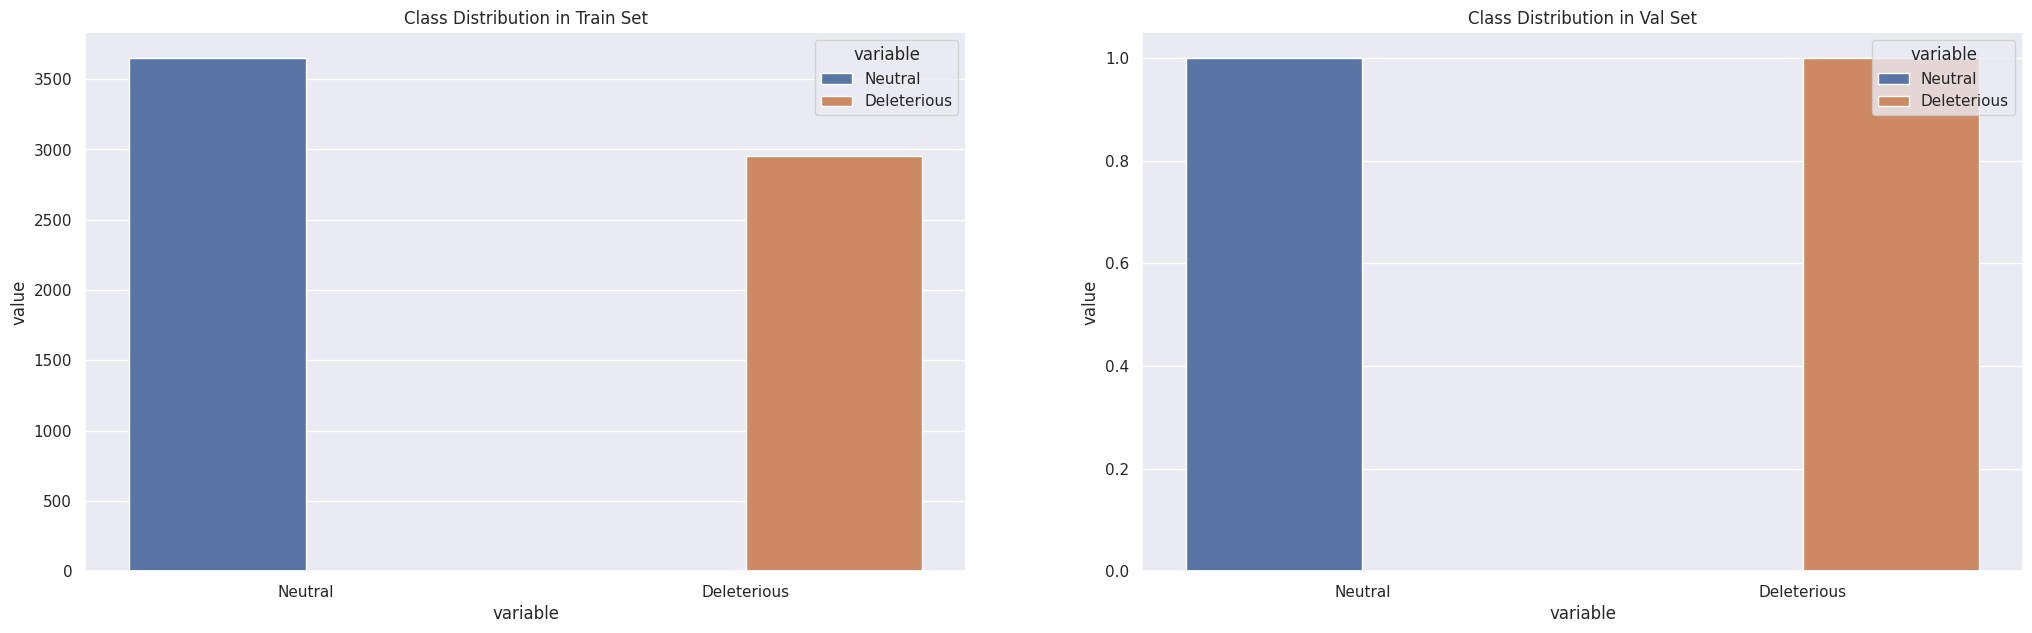

In [ ]:
temp = dif_mut_shuffled.mutation.str.split(pat='_',expand=True)
# seperate inputs and outputs
X = stacked_gmm
y = dif_mut_shuffled['label']

# Split, shuffle and stratify sequences, mutations, proteins and label
#X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, temp[1],  temp[0], test_size=0.1, stratify=y, random_state=69)
X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, temp[1],  temp[0], test_size=0.0002, stratify=y, random_state=69) #balance_ccommo
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

#del stacked_gmm, X
gc.collect()

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.737622 - Train accuracy: 57.569782 - Test loss: 0.647375 - Test accuracy: 50.000000
Epoch     1 - Train loss: 0.609030 - Train accuracy: 70.524879 - Test loss: 0.648539 - Test accuracy: 50.000000
Epoch     2 - Train loss: 0.589291 - Train accuracy: 71.814320 - Test loss: 0.630739 - Test accuracy: 50.000000
Epoch     3 - Train loss: 0.572645 - Train accuracy: 71.996359 - Test loss: 0.611729 - Test accuracy: 50.000000
Epoch     4 - Train loss: 0.544366 - Train accuracy: 73.725728 - Test loss: 0.570726 - Test accuracy: 50.000000
Epoch     5 - Train loss: 0.530958 - Train accuracy: 74.893811 - Test loss: 0.595318 - Test accuracy: 50.000000
Epoch     6 - Train loss: 0.504782 - Train accuracy: 76.107403 - Test loss: 0.579864 - Test accuracy: 50.000000
Epoch     7 - Train loss: 0.485578 - Train accuracy: 77.184466 - Test loss: 0.531981 - Test accuracy: 50.000000
Epoch     8 - Train loss: 0.466681 - Train accuracy: 78.549757 - Test loss: 0.535307 - Test accuracy: 50

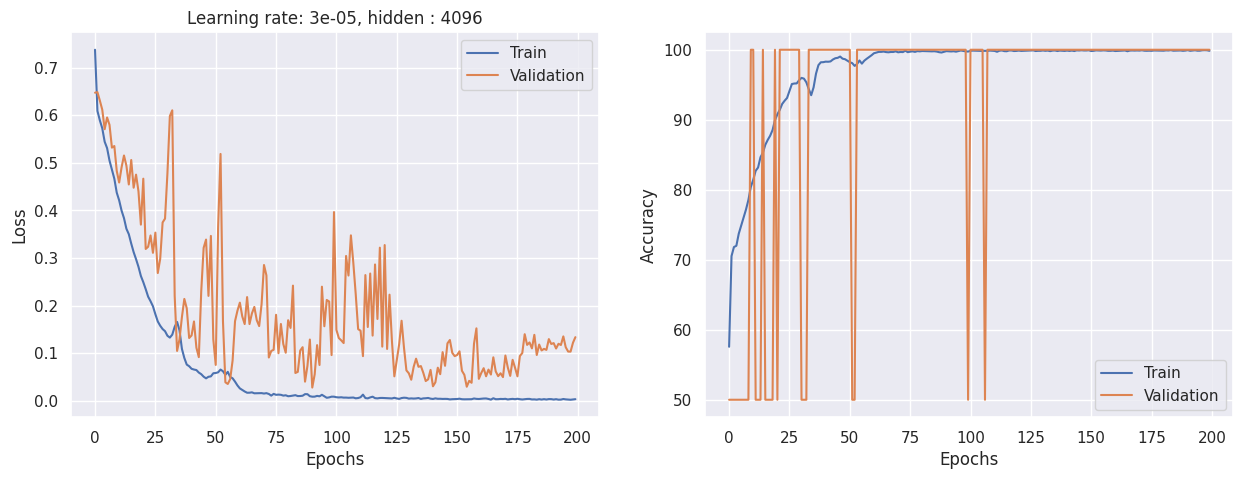

In [ ]:
BATCH_SIZE=64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=2, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set fixed random number seed
torch.manual_seed(42)
TRAIN_BATCH_SIZE = 64
epochs =200
lr = 3e-5
#h = 1024
#h = 2048
h = 4096
#h= 8192
#hidden2 =258
#hidden2=1024
hidden2=2048
#hidden2=4096

my_net = Classifier2L(h, hidden2, 0.3).to(device)
#my_net = Classifier(h, 0.3).to(device)
my_net.apply(init_weights)
param_optimizer = list(my_net.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.02,
    },
]

num_train_steps = int(len(X_train) / TRAIN_BATCH_SIZE * epochs)
optimizer = torch.optim.AdamW(optimizer_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=1000, num_training_steps=num_train_steps
)
#loss_fn = nn.BCELoss()

loss, acc = train_net_cross(my_net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler)

plt.rcParams["figure.figsize"] = (15,5)
sns.set()
# plot train/validation loss curves
plt.subplot(1, 2, 1)
plt.plot(loss[0])
plt.plot(loss[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Learning rate: {lr}, hidden : {h}')
plt.legend(('Train', 'Validation'))
#plt.title(f'Learning rate: {lr}, hidden : {h}, hidden2: {h2}')

plt.subplot(1, 2, 2)
plt.plot(acc[0])
plt.plot(acc[1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(('Train', 'Validation'))
plt.show()

In [ ]:
# RUN ONCE
#torch.save(my_net.state_dict(), '/content/drive/MyDrive/my_colab/3rdYear/GMM/model')

# Load model

In [ ]:
h = 4096
hidden2=2048
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Classifier2L(h, hidden2, 0.3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/my_colab/3rdYear/GMM/model'))
model.eval()

# DRGN

In [ ]:
# import difference for each mutation + labels
#dif_mut_drgn = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_DRGN2200AA_filtermix3517maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
dif_mut_drgn = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_DRGN_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
# exclude duplicates
#dif_mut_drgn.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

Deleterious mutations in dataset:  1695
Benign mutations in dataset:  1908
torch.Size([3603, 2200])


In [ ]:
dif_mut_drgn_temp = dif_mut_drgn.mutation.str.split(pat='_',expand=True)
labels_drgn = dif_mut_drgn['label'].tolist()
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
my_net.eval()

with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = my_net(X_batch)
        #print(y_test_pred)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())
        #print(predictions_drgn)

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

predictions_drgn = [1 if i>=0.5 else 0 for i in flat_list]
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn))
tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn).ravel()
print(classification_report(y_drgn, predictions_drgn))
print(tp, tn, fp, fn)
TPR =tp / (tp + fn)
print('Sensitivity: %.2f'  % (TPR*100))

TNR = tn / (tn + fp)
print('Specificity: %.2f'  % (TNR*100))
print(matthews_corrcoef(y_drgn, predictions_drgn))

              precision    recall  f1-score   support

           0       0.73      0.52      0.61      1908
           1       0.59      0.78      0.67      1695

    accuracy                           0.64      3603
   macro avg       0.66      0.65      0.64      3603
weighted avg       0.66      0.64      0.64      3603

1325 995 913 370
Sensitivity: 78.17
Specificity: 52.15
0.3119650804634715


In [ ]:
dif_mut_drgn_all = dif_mut_drgn
temp = dif_mut_drgn_all.mutation.str.split(pat='_',expand=True)
pos, AA_o, AA_t = [], [], []
test= temp[1].tolist()
for i in test:
  pos.append(i[1:-1])
  AA_o.append(i[0])
  AA_t.append(i[-1])

dif_mut_drgn_all['uniprot'] = temp[0].tolist()
dif_mut_drgn_all['D2D'] = flat_list # cont_value
dif_mut_drgn_all['AA_orig'] =AA_o
dif_mut_drgn_all['position'] =pos
dif_mut_drgn_all['AA_targ'] =AA_t

# compute TP etc
TP, TN, FP, FN=[],[],[],[]
for i, mut in dif_mut_drgn_all.iterrows():

  if (mut['label'] == 1) and (mut['D2D'] >=0.5):
    TP.append(1)
    TN.append(0)
    FP.append(0)
    FN.append(0)
  elif mut['label'] == 1 and mut['D2D'] < 0.5:
    TP.append(0)
    TN.append(0)
    FP.append(0)
    FN.append(1)
  elif mut['label'] == 0 and mut['D2D'] >=0.5:
    TP.append(0)
    TN.append(0)
    FP.append(1)
    FN.append(0)
  elif mut['label'] == 0 and mut['D2D'] < 0.5:
    TP.append(0)
    TN.append(1)
    FP.append(0)
    FN.append(0)
  else:
    TP.append(0)
    TN.append(0)
    FP.append(0)
    FN.append(0)

dif_mut_drgn_all['TP'] =TP
dif_mut_drgn_all['TN'] =TN
dif_mut_drgn_all['FP'] =FP
dif_mut_drgn_all['FN'] =FN

accuracy_D2D = (dif_mut_drgn_all['TP'].sum() + dif_mut_drgn_all['TN'].sum()) / (dif_mut_drgn_all['TP'].sum() + dif_mut_drgn_all['TN'].sum() + dif_mut_drgn_all['FP'].sum() + dif_mut_drgn_all['FN'].sum())

print(f'Accuracy of D2D predictor:  {accuracy_D2D*100:.2f} %')

Accuracy of D2D predictor:  64.39 %


In [ ]:
dif_mut_drgn_all['position'] = dif_mut_drgn_all['position'].astype(int)
dif_mut_drgn_all = dif_mut_drgn_all.drop(columns=['log_difference', 'fl_dif', 'fl_dif_pad'])
df_sorted = dif_mut_drgn_all.sort_values(by=['uniprot', 'position', 'AA_targ'])
filepath = '/content/drive/MyDrive/d2d_drgn_012023_resultsb.csv'
df_sorted.to_csv(filepath, index=False)

In [ ]:
with open('/content/drive/MyDrive/d2d_drgn_012023_results.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(predictions_drgn)

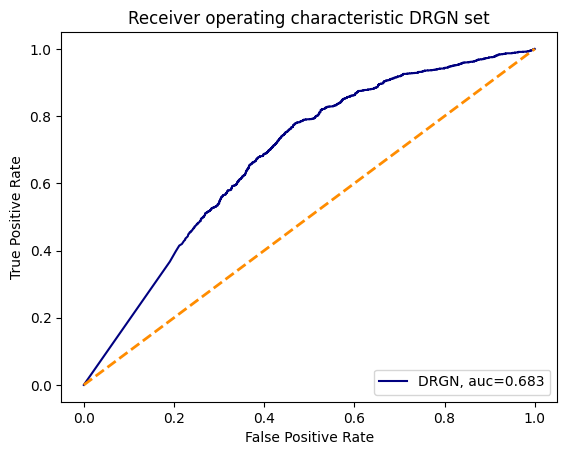

In [ ]:
lw = 2
import matplotlib
matplotlib.rc_file_defaults()
fpr, tpr, _ = metrics.roc_curve(y_drgn[:len(predictions_drgn)],  flat_list)
auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn)], flat_list)
plt.plot(fpr,tpr,color="navy",label="DRGN, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic DRGN set")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [ ]:
pos, AA_o, AA_t = [], [], []
test_mutation= dif_mut_drgn_temp[1].tolist()
for i in test_mutation:
  pos.append(i[1:-1])
  AA_o.append(i[0])
  AA_t.append(i[-1])

orig_drgn =AA_o
pos_drgn = pos
targ_drgn = AA_t
prot_drgn = dif_mut_drgn_temp[0]

In [ ]:
incorrect, correct = 0,0
incorrect_mu, incorrect_prot, correct_mu, correct_prot, correct_lab, incorrect_lab, incorrect_pre, cont_lab_inc, cont_lab_c, repres_inc, repres_c, temp_pos_inc, \
temp_targ_inc, temp_orig_inc, temp_pos_c, temp_targ_c, temp_orig_c, temp_len_c, temp_len_inc = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

for ind, pre in enumerate(predictions_drgn):
  if labels_drgn[ind] != pre:

    incorrect_prot.append(prot_drgn[ind])
    temp_pos_inc.append(pos_drgn[ind])
    #temp_len_inc.append(len_drgn[ind])
    temp_targ_inc.append(targ_drgn[ind])
    temp_orig_inc.append(orig_drgn[ind])
    incorrect += 1
    incorrect_lab.append(labels_drgn[ind])
    incorrect_pre.append(pre)
    cont_lab_inc.append(flat_list[ind]) # append the continuous values for comparison with EVE predictor
    repres_inc.append(X_drgn[ind])

  else:
    correct +=1
    correct_prot.append(prot_drgn[ind])
    temp_pos_c.append(pos_drgn[ind])
    #temp_len_c.append(len_drgn[ind])
    temp_targ_c.append(targ_drgn[ind])
    temp_orig_c.append(orig_drgn[ind])
    correct_lab.append(labels_drgn[ind] )
    cont_lab_c.append(flat_list[ind]) # append the continuous values for comparison with EVE predictor
    repres_c.append(X_drgn[ind])

df_incorrect_drgn = pd.DataFrame(list(zip(incorrect_prot, incorrect_lab, incorrect_pre , cont_lab_inc, temp_pos_inc, temp_orig_inc, temp_targ_inc)),#temp_len_inc)),
               columns =['Protein', 'Ground Truth', 'Prediction', 'Continuous prediction', 'Position', 'Original', 'Target'])#, 'Length'])
df_correct_drgn = pd.DataFrame(list(zip(correct_prot, correct_lab, cont_lab_c, temp_pos_c ,temp_orig_c, temp_targ_c)),# temp_len_c)),
               columns =['Protein', 'Ground Truth','Continuous prediction', 'Position', 'Original', 'Target'])#, 'Length'])

In [ ]:
dict_prot_c = {}
for ind, mutation in df_correct_drgn.iterrows():
    pr = mutation['Protein']
    if pr not in dict_prot_c:
      if mutation['Ground Truth'] == 0:
        dict_prot_c[pr]= [1,0]
      else:
        dict_prot_c[pr]= [0,1]
    else:
      if mutation['Ground Truth'] == 0:
        dict_prot_c[pr][0]+= 1
      else:
        dict_prot_c[pr][1]+= 1

dict_prot_inc = {}
for ind, mutation in df_incorrect_drgn.iterrows():
    pr = mutation['Protein']
    if pr not in dict_prot_inc:
      if mutation['Ground Truth'] == 0:
        dict_prot_inc[pr]= [1,0]
      else:
        dict_prot_inc[pr]= [0,1]
    else:
      if mutation['Ground Truth'] == 0:
        dict_prot_inc[pr][0]+= 1
      else:
        dict_prot_inc[pr][1]+= 1

dict_prot_dif_mut = {} # deleterious / benign samples in training set
for ind, mut in dif_mut.iterrows():
    pr = mut['mutation'].split('_')[0]
    if pr not in dict_prot_dif_mut:
      if mut['label'] == 0:
        dict_prot_dif_mut[pr]= [1,0]
      else:
        dict_prot_dif_mut[pr]= [0,1]
    else:
      if mut['label'] == 0:
        dict_prot_dif_mut[pr][0]+= 1
      else:
        dict_prot_dif_mut[pr][1]+= 1

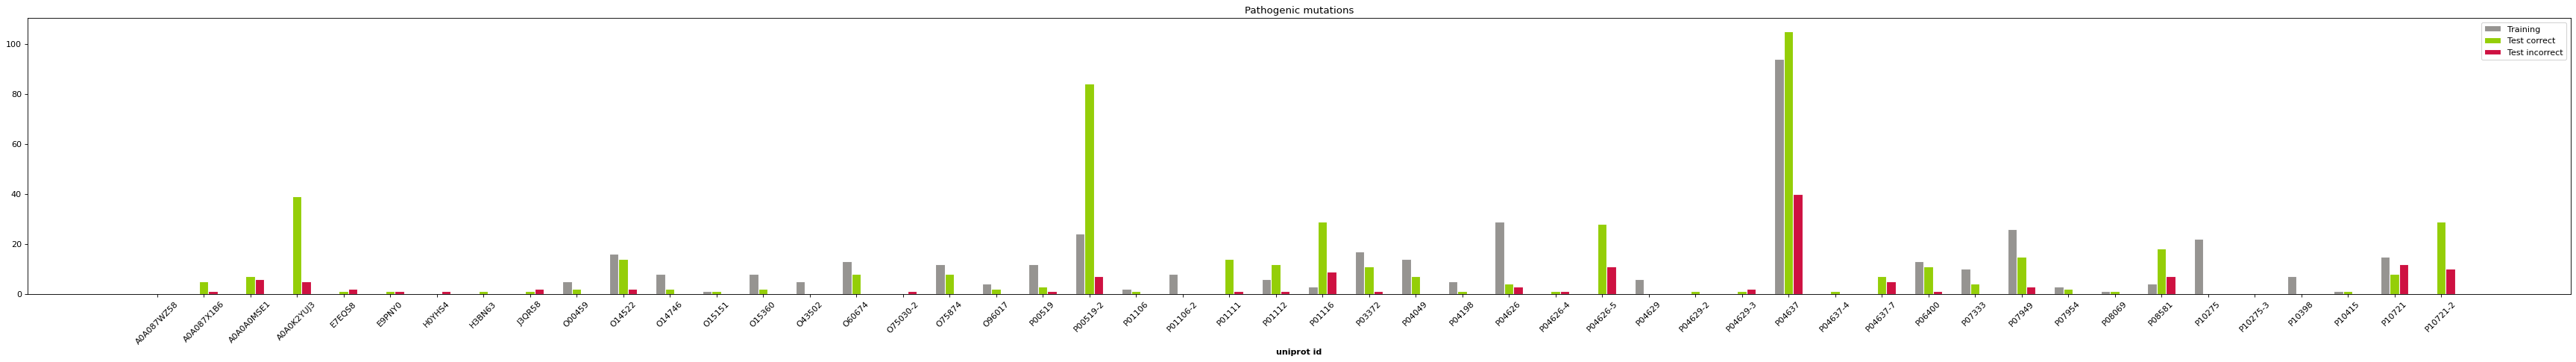

In [ ]:
list_prot = list(dict_prot_c.keys())
samples = len(dict_prot_c.keys())
barWidth = 0.2
figure(figsize=(55, 6), dpi=80)
bars1,bars2, bars3 = [], [], []
for keys in list_prot[:50]:
  #benign graph
  if keys in dict_prot_dif_mut:
    bars1.append(dict_prot_dif_mut[keys][1])
  else:
    bars1.append(0)
  if keys in dict_prot_c:
    bars2.append(dict_prot_c[keys][1])
  else:
    bars2.append(0)
  if keys in dict_prot_inc:
    bars3.append(dict_prot_inc[keys][1])
  else:
    bars3.append(0)

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='#969491', width=barWidth, edgecolor='white', label='Training')
plt.bar(r2, bars2, color='#94ce08', width=barWidth, edgecolor='white', label='Test correct')
plt.bar(r3, bars3, color='#ce1141', width=barWidth, edgecolor='white', label='Test incorrect')

# Add xticks on the middle of the group bars
plt.xlabel('uniprot id', fontweight='bold')
plt.title('Pathogenic mutations')

plt.xticks([r + barWidth for r in range(len(bars1))], list_prot, rotation=45)

# Create legend & Show graphic
plt.legend()

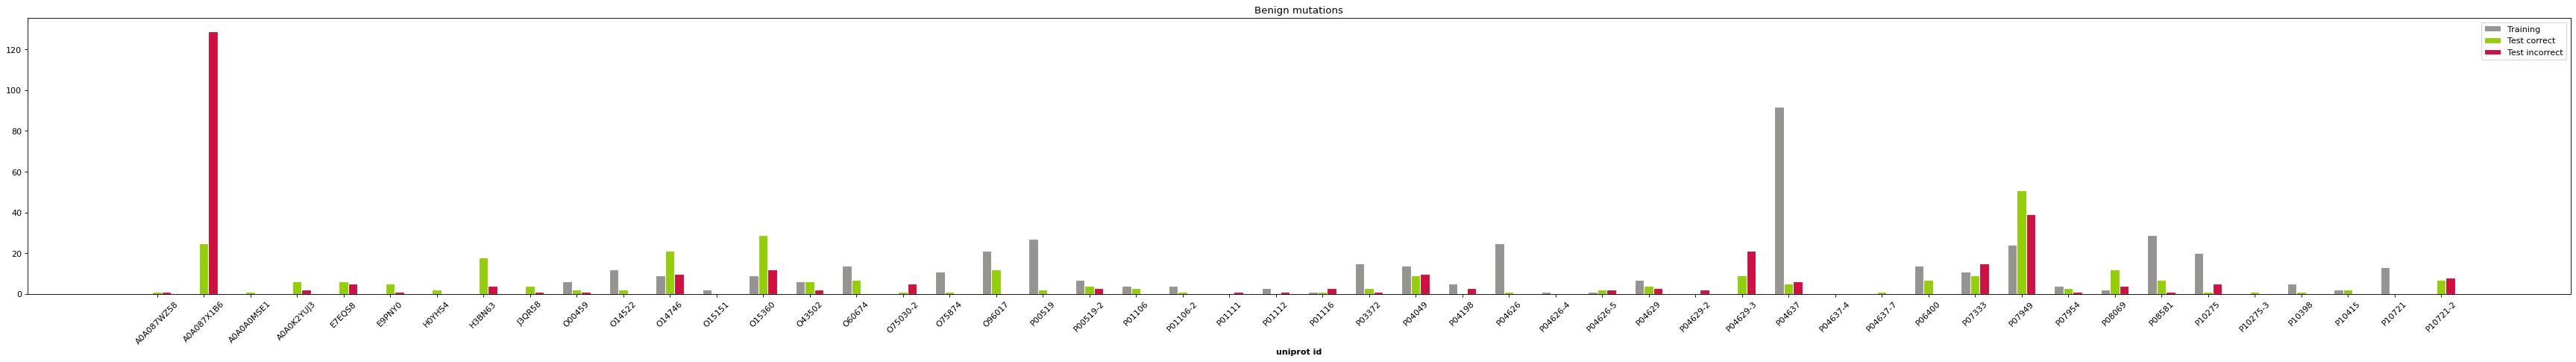

In [ ]:
list_prot = list(dict_prot_c.keys())
samples = len(dict_prot_c.keys())
barWidth = 0.2
figure(figsize=(55, 6), dpi=80)
bars1,bars2, bars3 = [], [], []
for keys in list_prot[:50]:
  #benign graph
  if keys in dict_prot_dif_mut:
    bars1.append(dict_prot_dif_mut[keys][0])
  else:
    bars1.append(0)
  if keys in dict_prot_c:
    bars2.append(dict_prot_c[keys][0])
  else:
    bars2.append(0)
  if keys in dict_prot_inc:
    bars3.append(dict_prot_inc[keys][0])
  else:
    bars3.append(0)

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='#969491', width=barWidth, edgecolor='white', label='Training')
plt.bar(r2, bars2, color='#94ce08', width=barWidth, edgecolor='white', label='Test correct')
plt.bar(r3, bars3, color='#ce1141', width=barWidth, edgecolor='white', label='Test incorrect')


# Add xticks on the middle of the group bars
plt.xlabel('uniprot id', fontweight='bold')
plt.title('Benign mutations')
plt.xticks([r + barWidth for r in range(len(bars1))], list_prot, rotation=45)

# Create legend & Show graphic
plt.legend()

### Drop in perfornace when DRGN is excluded from training set

In [ ]:
# import difference for each mutation + labels
dif_mut = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_Tier1_2_3_common_balanced+-2_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

# exclude duplicates
#dif_mut.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut[dif_mut['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut[dif_mut['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut['fl_dif_pad'] = fl_dif_pad

Deleterious mutations in dataset:  2956
Benign mutations in dataset:  3652


In [ ]:
# import difference for each mutation + labels
dif_mut_drgn = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_DRGN_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
# exclude duplicates
#dif_mut_drgn.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

Deleterious mutations in dataset:  1695
Benign mutations in dataset:  1908
torch.Size([3603, 2200])


In [ ]:
# remove DRGN mutations form training set
cond = dif_mut['mutation'].isin(dif_mut_drgn['mutation'])
dif_mut.drop(dif_mut[cond].index, inplace = True)

In [ ]:
stacked_flat =[]
for i, mut in dif_mut.iterrows():
  stacked_flat.append(torch.tensor(mut['fl_dif_pad']))

stacked_gmm = torch.stack(stacked_flat)
print(stacked_gmm.shape)

torch.Size([5516, 2200])


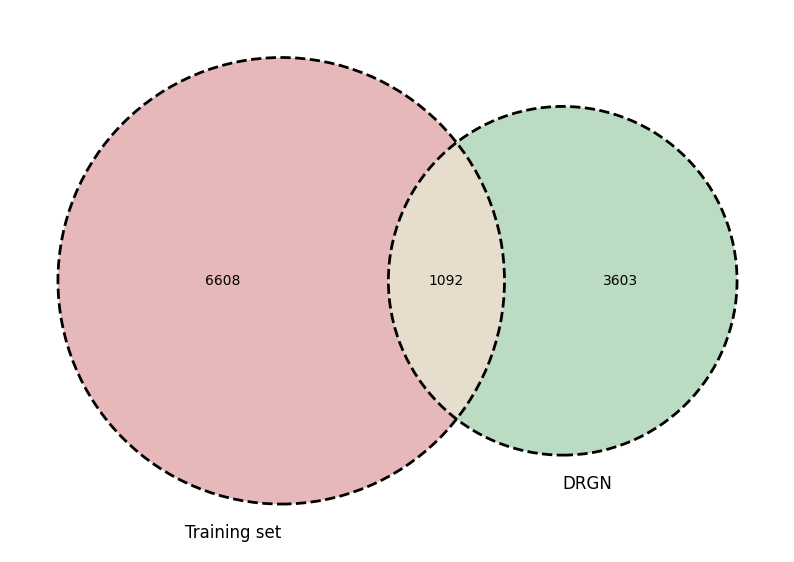

In [ ]:

out = venn2(subsets = (6608, 3603, 1092), set_labels = ('Training set', 'DRGN'))
c = venn2_circles(subsets= (6608, 3603, 1092), linestyle='dashed')

plt.show()

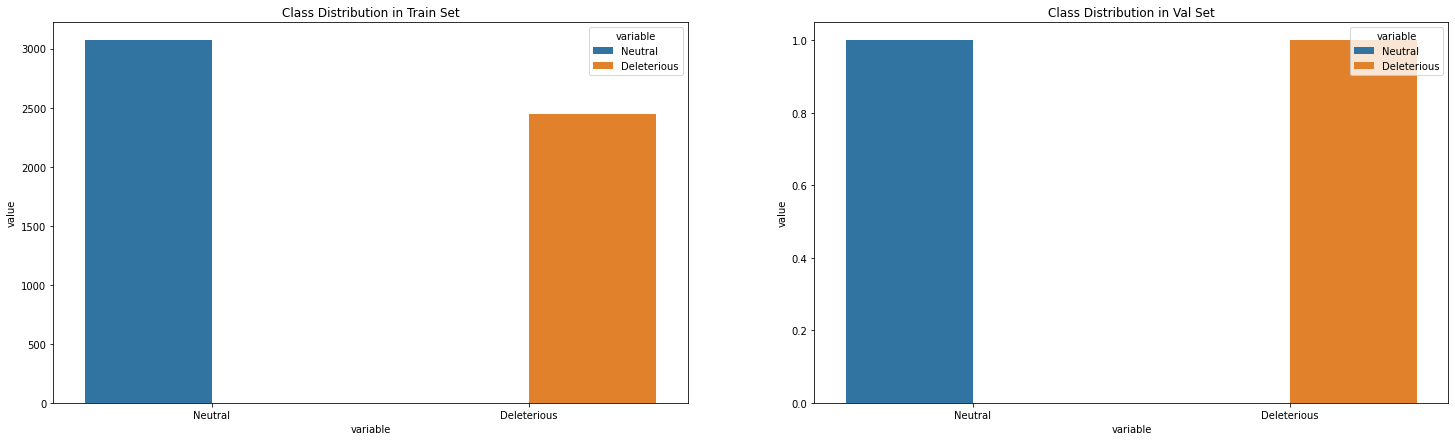

In [ ]:
temp = dif_mut.mutation.str.split(pat='_',expand=True)
# seperate inputs and outputs
X = stacked_gmm
y = dif_mut['label']

# Split, shuffle and stratify sequences, mutations, proteins and label

#X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, temp[1],  temp[0], test_size=0.1, stratify=y, random_state=69)
X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, temp[1],  temp[0], test_size=0.0002, stratify=y, random_state=69)
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

del stacked_gmm, X
gc.collect()

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')


BATCH_SIZE=64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True)
val_loader = DataLoader(dataset
=val_dataset, batch_size=2, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# implementation of a single training epoch
def train_epoch_cross(net, loader, loss_fn, optimizer, scheduler):

    # set the network in training mode
    net.train()

    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct = 0
    targets = []
    predictions = []

    for i, data in enumerate(loader):

        # sample data
        x, y = data
        x = x.to(device)
        y = y.to(device)

        # set all gradients equal to zero
        net.zero_grad()

        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        #y_pred_sq = np.squeeze(y_pred) # add when using loss_fn: BCEloss()

        pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer

        # compare predictions to true label
        #correct_tensor = pred.eq(y.float().view_as(pred))
        #correct = np.squeeze(correct_tensor.cpu().numpy())
        #num_correct += np.sum(correct)
        targets.extend(y.cpu().detach().numpy().tolist())
        predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

        #predictions_round = [round(p) for p in predictions]
        #correct_tensor = predictions_round.eq(targets.float().view_as(predictions_round))

        #loss = loss_fn(y_pred_sq, y.float())  #add when using loss_fn: BCEloss()
        loss = loss_fn(y_pred, y.float())

        # Specify L1 and L2 weights
        l1_weight = 0
        l2_weight = 0

        # Compute L1 and L2 loss component
        parameters = []
        for parameter in net.parameters():
            parameters.append(parameter.view(-1))
        l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
        l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))

        # Add L1 and L2 loss components
        loss += l1
        loss += l2

        loss_cum += loss.data.cpu().numpy()
        cnt += 1

        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
        scheduler.step()

        #break #for training one batch

    # compute the average loss
    #mytrain_acc = num_correct
    loss_avg = loss_cum / cnt

    #predictions = np.array(predictions) >= 0.5
    predictions = [1 if p[0] > 0.5 else 0 for p in predictions]
    mytrain_acc  = metrics.accuracy_score(targets, predictions)   *100
    #mytrain_acc = (num_correct/ (len(y)*cnt)) *100
    return loss_avg, mytrain_acc

def loss_fn(outputs, targets):
  return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))



def train_net_cross(net, train_loader, val_loader, loss_fn, optimizer, epochs , scheduler):

    # transfer the network to the GPU
    net = net.to(device)

    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    train_acc = np.zeros((epochs))
    train_acc_alt = np.zeros((epochs))

    test_acc = np.zeros((epochs))
    test_acc_alt = np.zeros((epochs))

    print("Begin training.")

    for epoch in tqdm(range(epochs)):

        # training
        train_loss[epoch], train_acc[epoch] = train_epoch_cross(net, train_loader, loss_fn, optimizer, scheduler)
        #predictions, outputs = eval(net, train_loader)
        #train_acc_alt[epoch] = metrics.accuracy_score(outputs, predictions)

        # validation
        test_loss[epoch], test_acc[epoch] = test_epoch(net, val_loader, loss_fn)
        #predictions, outputs = eval(net, val_loader)
        #test_acc_alt[epoch] = metrics.accuracy_score(outputs, predictions)

        print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f - Test loss: %.6f - Test accuracy: %.6f'
             % (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))

        #print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f'
        #    % (epoch, train_loss[epoch], train_acc[epoch]))# for training one batch

    return (train_loss, test_loss), (train_acc , test_acc)
    #return train_loss, train_acc # for training one batch

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.762819 - Train accuracy: 53.924419 - Test loss: 0.473098 - Test accuracy: 100.000000
Epoch     1 - Train loss: 0.625519 - Train accuracy: 68.768169 - Test loss: 0.414175 - Test accuracy: 100.000000
Epoch     2 - Train loss: 0.611069 - Train accuracy: 70.348837 - Test loss: 0.373835 - Test accuracy: 100.000000
Epoch     3 - Train loss: 0.587539 - Train accuracy: 71.202762 - Test loss: 0.374835 - Test accuracy: 100.000000
Epoch     4 - Train loss: 0.571141 - Train accuracy: 71.765988 - Test loss: 0.359634 - Test accuracy: 100.000000
Epoch     5 - Train loss: 0.541477 - Train accuracy: 73.437500 - Test loss: 0.387811 - Test accuracy: 100.000000
Epoch     6 - Train loss: 0.521409 - Train accuracy: 75.036337 - Test loss: 0.406848 - Test accuracy: 100.000000
Epoch     7 - Train loss: 0.506551 - Train accuracy: 75.654070 - Test loss: 0.445492 - Test accuracy: 100.000000
Epoch     8 - Train loss: 0.485533 - Train accuracy: 76.998547 - Test loss: 0.369950 - Test accu

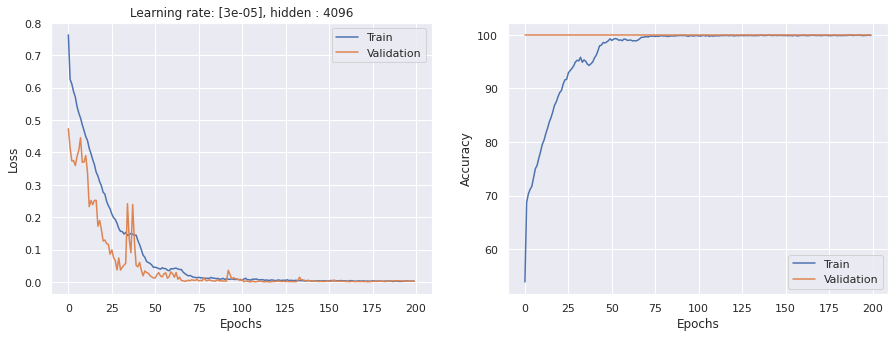

In [ ]:
# Set fixed random number seed
torch.manual_seed(42)
TRAIN_BATCH_SIZE = 64
epochs =200
lr = [3e-5]
#h = 1024
#h = 2048
h = 4096
#hidden2 =258
#hidden2=1024
hidden2=2048

my_net = Classifier2L(h, hidden2, 0.3).to(device)
#my_net = Classifier(h, 0.3).to(device)
my_net.apply(init_weights)
param_optimizer = list(my_net.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.02,
    },
]

num_train_steps = int(len(X_train) / TRAIN_BATCH_SIZE * epochs)
optimizer = torch.optim.AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=1000, num_training_steps=num_train_steps
)
#loss_fn = nn.BCELoss()

loss, acc = train_net_cross(my_net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler)

plt.rcParams["figure.figsize"] = (15,5)
sns.set()
# plot train/validation loss curves
plt.subplot(1, 2, 1)
plt.plot(loss[0])
plt.plot(loss[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Learning rate: {lr}, hidden : {h}')
plt.legend(('Train', 'Validation'))
#plt.title(f'Learning rate: {lr}, hidden : {h}, hidden2: {h2}')

plt.subplot(1, 2, 2)
plt.plot(acc[0])
plt.plot(acc[1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(('Train', 'Validation'))
plt.show()

In [ ]:
labels_drgn = dif_mut_drgn['label'].tolist()
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
my_net.eval()

with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = my_net(X_batch)
        #print(y_test_pred)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())
        #print(predictions_drgn)

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)


predictions_drgn = [1 if i>=0.5 else 0 for i in flat_list]
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn))
tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn).ravel()
print(classification_report(y_drgn, predictions_drgn))
print(tp, tn, fp, fn)
TPR =tp / (tp + fn)
print('Sensitivity: %.2f'  % (TPR*100))

TNR = tn / (tn + fp)
print('Specificity: %.2f'  % (TNR*100))
print(matthews_corrcoef(y_drgn, predictions_drgn))

              precision    recall  f1-score   support

           0       0.64      0.50      0.56      1908
           1       0.55      0.69      0.61      1695

    accuracy                           0.59      3603
   macro avg       0.60      0.59      0.59      3603
weighted avg       0.60      0.59      0.59      3603

1163 955 953 532
Sensitivity: 68.61
Specificity: 50.05
0.18923938233042958


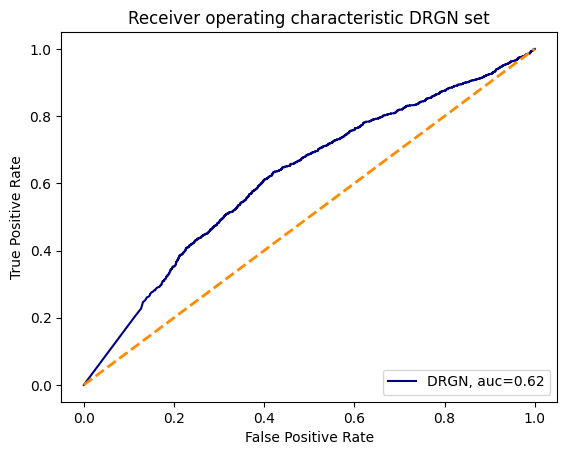

In [ ]:
lw = 2
import matplotlib
matplotlib.rc_file_defaults()
fpr, tpr, _ = metrics.roc_curve(y_drgn[:len(predictions_drgn)],  flat_list)
auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn)], flat_list)
plt.plot(fpr,tpr,color="navy",label="DRGN, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic DRGN set")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

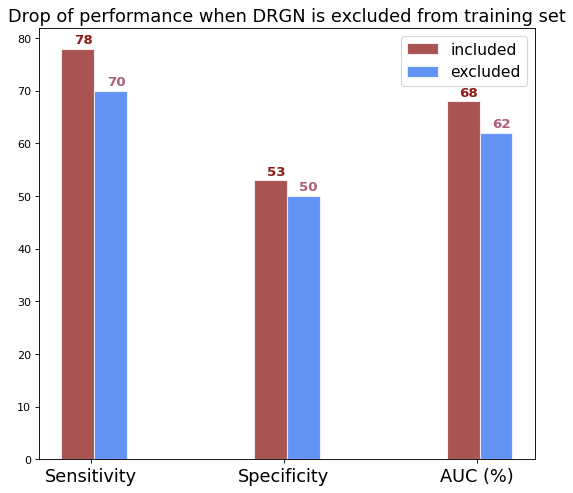

In [ ]:
included = [78, 53, 68]
excluded = [70, 50, 62]
barWidth = 0.17
fig = plt.figure(figsize=(8, 7), dpi=80)

bars1 = [included,excluded]
r1 = np.arange(len(included))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, included, color='#8d1b1a', width=barWidth, edgecolor='white', label='included', alpha=0.75)
plt.bar(r2, excluded, color='#2164f4', width=barWidth, edgecolor='white', label='excluded', alpha=0.7) #ad5f7d

# Add values above the bars
for i in range(len(included)):
    plt.text(x=r1[i]-0.02, y=included[i]+1, s=str(round(included[i],1)), fontweight='bold', fontsize=12, color='#8d1b1a')
    plt.text(x=r2[i]-0.02, y=excluded[i]+1, s=str(round(excluded[i],1)), fontweight='bold', fontsize=12, color='#ad5f7d')

# Add xticks on the middle of the group bars
plt.title('Drop of performance when DRGN is excluded from training set',fontname="Calibri", fontsize=16)
plt.xticks([r + barWidth-0.1 for r in range(3)],  ['Sensitivity', 'Specificity', 'AUC (%)'],fontname="Calibri", fontsize=16)

# Create legend & Show graphic
plt.legend(fontsize=14)

#### Error analysis

In [ ]:
dif_mut_drgn_all = dif_mut_drgn
temp = dif_mut_drgn_all.mutation.str.split(pat='_',expand=True)

In [ ]:
pos, AA_o, AA_t = [], [], []
test= temp[1].tolist()
for i in test:
  pos.append(i[1:-1])
  AA_o.append(i[0])
  AA_t.append(i[-1])

dif_mut_drgn_all['uniprot'] = temp[0].tolist()
dif_mut_drgn_all['D2D'] = flat_list # cont_value
dif_mut_drgn_all['AA_orig'] =AA_o
dif_mut_drgn_all['position'] =pos
dif_mut_drgn_all['AA_targ'] =AA_t

In [ ]:
# compute TP etc
TP, TN, FP, FN=[],[],[],[]
for i, mut in dif_mut_drgn_all.iterrows():

  if (mut['label'] == 1) and (mut['D2D'] >=0.5):
    TP.append(1)
    TN.append(0)
    FP.append(0)
    FN.append(0)
  elif mut['label'] == 1 and mut['D2D'] < 0.5:
    TP.append(0)
    TN.append(0)
    FP.append(0)
    FN.append(1)
  elif mut['label'] == 0 and mut['D2D'] >=0.5:
    TP.append(0)
    TN.append(0)
    FP.append(1)
    FN.append(0)
  elif mut['label'] == 0 and mut['D2D'] < 0.5:
    TP.append(0)
    TN.append(1)
    FP.append(0)
    FN.append(0)
  else:
    TP.append(0)
    TN.append(0)
    FP.append(0)
    FN.append(0)

dif_mut_drgn_all['TP'] =TP
dif_mut_drgn_all['TN'] =TN
dif_mut_drgn_all['FP'] =FP
dif_mut_drgn_all['FN'] =FN

accuracy_D2D = (dif_mut_drgn_all['TP'].sum() + dif_mut_drgn_all['TN'].sum()) / (dif_mut_drgn_all['TP'].sum() + dif_mut_drgn_all['TN'].sum() + dif_mut_drgn_all['FP'].sum() + dif_mut_drgn_all['FN'].sum())

print(f'Accuracy of D2D predictor:  {accuracy_D2D*100:.2f} %')

Accuracy of D2D predictor:  64.72 %


In [ ]:
dif_mut_drgn_all['position'] = dif_mut_drgn_all['position'].astype(int)

In [ ]:
dif_mut_drgn_all = dif_mut_drgn_all.drop(columns=['log_difference', 'fl_dif', 'fl_dif_pad'])

In [ ]:
df_sorted = dif_mut_drgn_all.sort_values(by=['uniprot', 'position', 'AA_targ'])
filepath = '/content/drive/MyDrive/D2D_DRGN_122200_sorted_maxpool.csv'
df_sorted.to_csv(filepath, index=False)

In [ ]:
sensitivity_D2D = dif_mut_drgn_all['TP'].sum()  / (dif_mut_drgn_all['TP'].sum() + dif_mut_drgn_all['FN'].sum())

In [ ]:
specificity_D2D = dif_mut_drgn_all['TN'].sum() /( dif_mut_drgn_all['TN'].sum() +  dif_mut_drgn_all['FP'].sum())

#### EVE versus D2D

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_012023_DEOGEN_etc.csv')

In [ ]:
# keep only rows where both EVE and D2D have values and append uniprot ids
eve_values, d2d_values, len_seq, uniprot_ids= [], [], [], []

for i, mut in results.iterrows():
  if math.isnan(mut['EVE']):
    continue
  if  math.isnan(mut['D2D']):
    continue
  eve_values.append(mut['EVE'])
  d2d_values.append(mut['D2D'])
  uniprot_ids.append(mut['uniprot'])

In [ ]:
eve_values_np = np.array(eve_values)

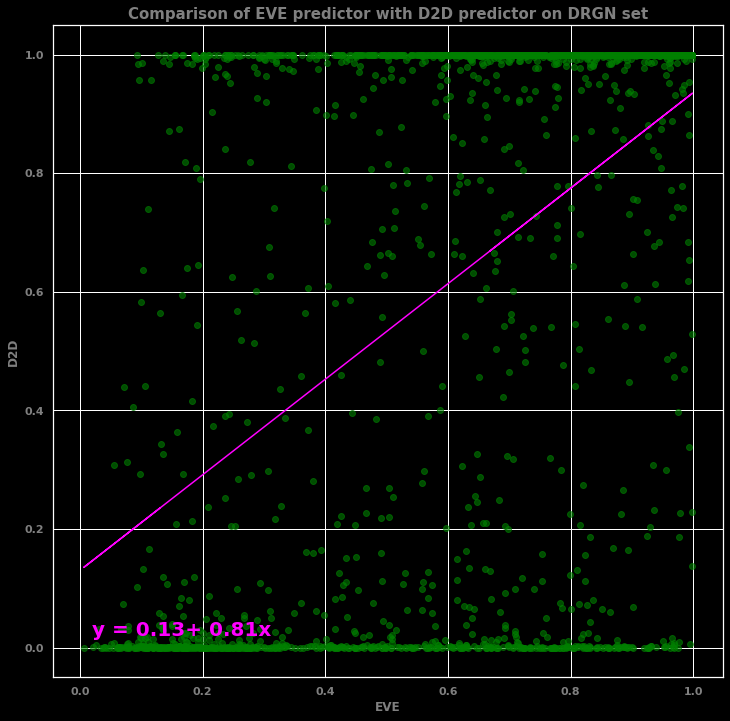

In [ ]:
# compute scatter plot EVE vs D2D
from scipy import stats
correlation, p_value = stats.pearsonr(eve_values, d2d_values)

import seaborn as sns
sns.set_theme()
plt.rcParams["figure.figsize"] = (12,12)
plt.figure(facecolor='black')

plt.rcParams['axes.facecolor'] = 'black'

plt.scatter(eve_values, d2d_values, alpha=0.6, color = 'green')
plt.xlabel('EVE', fontweight='bold', color = 'grey' )
plt.ylabel('D2D', fontweight='bold', color = 'grey')

#find line of best fit
a, b = np.polyfit(eve_values, d2d_values,1)
plt.plot(eve_values, a*eve_values_np+b, color = 'magenta')

plt.xticks(color = 'grey',fontweight='bold')
plt.yticks(color = 'grey',fontweight='bold')
plt.text(0.02, 0.02, 'y = ' + '{:.2f}'.format(b) + '+' + ' {:.2f}'.format(a) + 'x', size=20, color='magenta',  fontweight='bold')
plt.title("Comparison of EVE predictor with D2D predictor on DRGN set",fontsize = 15, fontweight='bold', color = 'grey')

plt.show()

Analysis of results where EVE ~=0 and D2D ~=1

In [ ]:
highEVElowD2D = results[(results['D2D'] >0.75) & (results['EVE']<0.32)]

### FATHMM vs Polyphen2 vs D2D vs EVE

In [ ]:
#results = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_082022_EVE_D2D_FATHMM_POLY2_maxpool2200new2.csv')
#results = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_122022_sorted.csv')
results = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_012023_DEOGEN_etc.csv')
print(len(results))

4048


In [ ]:
#results['Eve_score'] = pd.to_numeric(results['Eve_score'],errors='coerce')
#results['D2D_values'] = pd.to_numeric(results['D2D'],errors='coerce')
#results['FATHMM (threshold = -0.75)'] = pd.to_numeric(results['FATHMM (threshold = -0.75)'],errors='coerce')
#results['polyphen2'] = pd.to_numeric(results['polyphen2'],errors='coerce')
#results['DEOGEN'] = pd.to_numeric(results['DEOGEN'],errors='coerce')

In [ ]:
# compute TP for D2D
TP_D2D, TN_D2D, FP_D2D, FN_D2D=[],[],[],[]
for i, mut in results.iterrows():
  if mut['label'] == 1 and mut['D2D'] >=0.5:
    TP_D2D.append(1)
    TN_D2D.append(0)
    FP_D2D.append(0)
    FN_D2D.append(0)
  elif mut['label'] == 1 and mut['D2D'] < 0.5:
    TP_D2D.append(0)
    TN_D2D.append(0)
    FP_D2D.append(0)
    FN_D2D.append(1)
  elif mut['label'] == 0 and mut['D2D'] >=0.5:
    TP_D2D.append(0)
    TN_D2D.append(0)
    FP_D2D.append(1)
    FN_D2D.append(0)
  elif mut['label'] == 0 and mut['D2D'] < 0.5:
    TP_D2D.append(0)
    TN_D2D.append(1)
    FP_D2D.append(0)
    FN_D2D.append(0)
  else:
    TP_D2D.append(0)
    TN_D2D.append(0)
    FP_D2D.append(0)
    FN_D2D.append(0)

results['TP_D2D'] =TP_D2D
results['TN_D2D'] =TN_D2D
results['FP_D2D'] =FP_D2D
results['FN_D2D'] =FN_D2D
acc_D2D = (results['TP_D2D'].sum() + results['TN_D2D'].sum()) / (results['TP_D2D'].sum() + results['TN_D2D'].sum() + results['FP_D2D'].sum() + results['FN_D2D'].sum())

# compute TP for SIFT
results['SIFT'] = pd.to_numeric(results['SIFT'],errors='coerce')

TP_SIFT, TN_SIFT, FP_SIFT, FN_SIFT=[],[],[],[]
for i, mut in results.iterrows():
  if (mut['label'] == 1) and (mut['SIFT'] <=0.05):
    TP_SIFT.append(1)
    TN_SIFT.append(0)
    FP_SIFT.append(0)
    FN_SIFT.append(0)
  elif (mut['label'] == 1) and (mut['SIFT'] > 0.05):
    TP_SIFT.append(0)
    TN_SIFT.append(0)
    FP_SIFT.append(0)
    FN_SIFT.append(1)
  elif (mut['label'] == 0) and (mut['SIFT'] <=0.05):
    TP_SIFT.append(0)
    TN_SIFT.append(0)
    FP_SIFT.append(1)
    FN_SIFT.append(0)
  elif (mut['label'] == 0) and (mut['SIFT'] > 0.05):
    TP_SIFT.append(0)
    TN_SIFT.append(1)
    FP_SIFT.append(0)
    FN_SIFT.append(0)
  else:
    TP_SIFT.append(0)
    TN_SIFT.append(0)
    FP_SIFT.append(0)
    FN_SIFT.append(0)

results['TP_SIFT'] =TP_SIFT
results['TN_SIFT'] =TN_SIFT
results['FP_SIFT'] =FP_SIFT
results['FN_SIFT'] =FN_SIFT

acc_SIFT= (results['TP_SIFT'].sum() + results['TN_SIFT'].sum()) / (results['TP_SIFT'].sum() + results['TN_SIFT'].sum() + results['FP_SIFT'].sum() + results['FN_SIFT'].sum())

# compute TP etc
TP_DEOGEN, TN_DEOGEN, FP_DEOGEN, FN_DEOGEN=[],[],[],[]
for i, mut in results.iterrows():
  if mut['label'] == 1 and mut['DEOGEN2'] >0.5:
    TP_DEOGEN.append(1)
    TN_DEOGEN.append(0)
    FP_DEOGEN.append(0)
    FN_DEOGEN.append(0)
  elif mut['label'] == 1 and mut['DEOGEN2'] <= 0.5:
    TP_DEOGEN.append(0)
    TN_DEOGEN.append(0)
    FP_DEOGEN.append(0)
    FN_DEOGEN.append(1)
  elif mut['label'] == 0 and mut['DEOGEN2'] >0.5:
    TP_DEOGEN.append(0)
    TN_DEOGEN.append(0)
    FP_DEOGEN.append(1)
    FN_DEOGEN.append(0)
  elif mut['label'] == 0 and mut['DEOGEN2'] <= 0.5:
    TP_DEOGEN.append(0)
    TN_DEOGEN.append(1)
    FP_DEOGEN.append(0)
    FN_DEOGEN.append(0)
  else:
    TP_DEOGEN.append(0)
    TN_DEOGEN.append(0)
    FP_DEOGEN.append(0)
    FN_DEOGEN.append(0)

results['TP_DEOGEN'] =TP_DEOGEN
results['TN_DEOGEN'] =TN_DEOGEN
results['FP_DEOGEN'] =FP_DEOGEN
results['FN_DEOGEN'] =FN_DEOGEN

acc_DEOGEN = (results['TP_DEOGEN'].sum() + results['TN_DEOGEN'].sum()) / (results['TP_DEOGEN'].sum() + results['TN_DEOGEN'].sum() + results['FP_DEOGEN'].sum() + results['FN_DEOGEN'].sum())

# compute TP etc
TP_eve, TN_eve, FP_eve, FN_eve=[],[],[],[]
for i, mut in results.iterrows():
  if mut['label'] == 1 and mut['EVE'] >=0.5:
    TP_eve.append(1)
    TN_eve.append(0)
    FP_eve.append(0)
    FN_eve.append(0)
  elif mut['label'] == 1 and mut['EVE'] < 0.5:
    TP_eve.append(0)
    TN_eve.append(0)
    FP_eve.append(0)
    FN_eve.append(1)
  elif mut['label'] == 0 and mut['EVE'] >=0.5:
    TP_eve.append(0)
    TN_eve.append(0)
    FP_eve.append(1)
    FN_eve.append(0)
  elif mut['label'] == 0 and mut['EVE'] < 0.5:
    TP_eve.append(0)
    TN_eve.append(1)
    FP_eve.append(0)
    FN_eve.append(0)
  else:
    TP_eve.append(0)
    TN_eve.append(0)
    FP_eve.append(0)
    FN_eve.append(0)

results['TP_eve'] =TP_eve
results['TN_eve'] =TN_eve
results['FP_eve'] =FP_eve
results['FN_eve'] =FN_eve

acc_EVE = (results['TP_eve'].sum() + results['TN_eve'].sum()) / (results['TP_eve'].sum() + results['TN_eve'].sum() + results['FP_eve'].sum() + results['FN_eve'].sum())

In [ ]:
# compute TP etc
TP_FATH, TN_FATH, FP_FATH, FN_FATH=[],[],[],[]
for i, mut in results.iterrows():
  if mut['label'] == 1 and mut['FATHMM'] <-0.75:
    TP_FATH.append(1)
    TN_FATH.append(0)
    FP_FATH.append(0)
    FN_FATH.append(0)
  elif mut['label'] == 1 and mut['FATHMM'] >= -0.75:
    TP_FATH.append(0)
    TN_FATH.append(0)
    FP_FATH.append(0)
    FN_FATH.append(1)
  elif mut['label'] == 0 and mut['FATHMM'] <-0.75:
    TP_FATH.append(0)
    TN_FATH.append(0)
    FP_FATH.append(1)
    FN_FATH.append(0)
  elif mut['label'] == 0 and mut['FATHMM'] >= -0.75:
    TP_FATH.append(0)
    TN_FATH.append(1)
    FP_FATH.append(0)
    FN_FATH.append(0)
  else:
    TP_FATH.append(0)
    TN_FATH.append(0)
    FP_FATH.append(0)
    FN_FATH.append(0)

results['TP_FATH'] =TP_FATH
results['TN_FATH'] =TN_FATH
results['FP_FATH'] =FP_FATH
results['FN_FATH'] =FN_FATH
acc_FATH = (results['TP_FATH'].sum() + results['TN_FATH'].sum()) / (results['TP_FATH'].sum() + results['TN_FATH'].sum() + results['FP_FATH'].sum() + results['FN_FATH'].sum())

# compute TP etc
TP_pol, TN_pol, FP_pol, FN_pol=[],[],[],[]
for i, mut in results.iterrows():
  if mut['label'] == 1 and mut['PolyPhen2'] >=0.49:
    TP_pol.append(1)
    TN_pol.append(0)
    FP_pol.append(0)
    FN_pol.append(0)
  elif mut['label'] == 1 and mut['PolyPhen2'] < 0.49:
    TP_pol.append(0)
    TN_pol.append(0)
    FP_pol.append(0)
    FN_pol.append(1)
  elif mut['label'] == 0 and mut['PolyPhen2'] > 0.49:
    TP_pol.append(0)
    TN_pol.append(0)
    FP_pol.append(1)
    FN_pol.append(0)
  elif mut['label'] == 0 and mut['PolyPhen2'] < 0.49:
    TP_pol.append(0)
    TN_pol.append(1)
    FP_pol.append(0)
    FN_pol.append(0)
  else:
    TP_pol.append(0)
    TN_pol.append(0)
    FP_pol.append(0)
    FN_pol.append(0)

results['TP_pol'] =TP_pol
results['TN_pol'] =TN_pol
results['FP_pol'] =FP_pol
results['FN_pol'] =FN_pol

acc_pol = (results['TP_pol'].sum() + results['TN_pol'].sum()) / (results['TP_pol'].sum() + results['TN_pol'].sum() + results['FP_pol'].sum() + results['FN_pol'].sum())

In [ ]:
sens_SIFT = sum(TP_SIFT) / (sum(TP_SIFT) + sum(FN_SIFT))
spec_SIFT = sum(TN_SIFT) / (sum(TN_SIFT) + sum(FP_SIFT))
print(sens_SIFT, spec_SIFT, acc_SIFT)

#sensitivities & specificities
sens_D2D = sum(TP_D2D) / (sum(TP_D2D) + sum(FN_D2D))
spec_D2D = sum(TN_D2D) / (sum(TN_D2D) + sum(FP_D2D))
print(sens_D2D, spec_D2D, acc_D2D)

sens_EVE = sum(TP_eve) / (sum(TP_eve) + sum(FN_eve))
spec_EVE = sum(TN_eve) / (sum(TN_eve) + sum(FP_eve))
print(sens_EVE, spec_EVE, acc_EVE)

sens_FATH = sum(TP_FATH) / (sum(TP_FATH) + sum(FN_FATH))
spec_FATH = sum(TN_FATH) / (sum(TN_FATH) + sum(FP_FATH))
print(sens_FATH, spec_FATH, acc_FATH)

sens_pol = sum(TP_pol) / (sum(TP_pol) + sum(FN_pol))
spec_pol = sum(TN_pol) / (sum(TN_pol) + sum(FP_pol))
print(sens_pol, spec_pol, acc_pol)

sens_DEOGEN = sum(TP_DEOGEN) / (sum(TP_DEOGEN) + sum(FN_DEOGEN))
spec_DEOGEN = sum(TN_DEOGEN) / (sum(TN_DEOGEN) + sum(FP_DEOGEN))
print(sens_DEOGEN, spec_DEOGEN, acc_DEOGEN)

0.7312750142938822 0.3017997231195201 0.49361593462717057


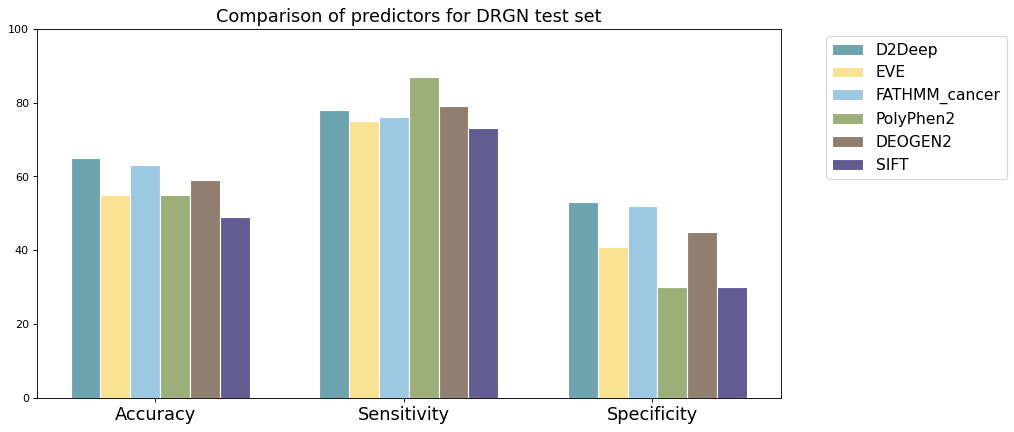

In [ ]:
D2Deep = [65, 78, 53]
EVE = [55, 75, 41 ]
FATHHM = [63, 76, 52]
PolyPhen2 = [55, 87, 30 ]
DEOGEN = [59, 79, 45 ]
SIFT = [49, 73, 30 ]

barWidth = 0.12
figure(figsize=(12, 6), dpi=80)

bars1 = [D2Deep, EVE, FATHHM, PolyPhen2, DEOGEN, SIFT ]
r1 = np.arange(len(D2Deep))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]


# Make the plot
plt.bar(r1, D2Deep, color = '#2292a7' , width=barWidth, edgecolor='white', label='D2Deep') #2166ac # ff0000 #334858 # 000000 '#ce1141' '#cd595a' da5a47
plt.bar(r2, EVE, color='#ffc907', width=barWidth, edgecolor='white', label='EVE') # 67a9cf # fbb034 # cd595a # be0027 #eeb111' 8ba753
plt.bar(r3, FATHHM, color='#56B4E9', width=barWidth, edgecolor='white', label='FATHMM_cancer') # d1e5f0 # c1d82f # 94938f # cf8d2e #02a388 #a6192e
plt.bar(r4, PolyPhen2, color='#82ad27', width=barWidth, edgecolor='white', label='PolyPhen2') # CCFFE5 # 007ea3 # dbc5b0 # e4e932 #0087b4
plt.bar(r5, DEOGEN, color='#695647', width=barWidth, edgecolor='white', label='DEOGEN2') # FFCCE5 # 00a4e4 # f8dfc2 # 2c9f45 #5654a4
plt.bar(r6, SIFT, color='#4234a4', width=barWidth, edgecolor='white', label='SIFT') # FFCCE5 # 9e4770 #f9ebdf # 371777

# Add xticks on the middle of the group bars
plt.title('Comparison of predictors for DRGN test set',fontname="Calibri", fontsize=16)
#plt.xticks([r + barWidth+0.16 for r in range(3)],  ['Sensitivity', 'Specificity', ], rotation=35,fontname="Comic Sans MS", fontsize=12)
plt.xticks([r + barWidth+0.16 for r in range(3)],  ['Accuracy', 'Sensitivity', 'Specificity'], fontname="Calibri", fontsize=16)
plt.ylim(0, 100)
plt.grid(axis = "y")
# Create legend & Show graphic
#plt.legend(fontsize=16)

# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=14)

In [ ]:
# double-check FATHMM conversion
results = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_012023_DEOGEN_etc.csv')
results = results.dropna(subset=['FATHMM'])
df = pd.DataFrame()
df['result'] = results['FATHMM'].tolist()
selected_rows = results[~results['FATHMM'].isnull()]
selected_rows['FATHMM_pos'] = 1- NormalizeData(selected_rows['FATHMM'])
condition1 = selected_rows['FATHMM'] < -0.75
selected_rows['FATHMM_inter'] =np.where(condition1, selected_rows['FATHMM_pos']+0.2, selected_rows['FATHMM_pos'] )
condition1 = selected_rows['FATHMM']<-9
value = 1
selected_rows['FATHMM_inter'] =np.where(condition1, value, selected_rows['FATHMM_inter'] )
df['processed'] = selected_rows['FATHMM_inter'].tolist()
# saving the dataframe
df.to_csv('FATHMM.csv')

<ipython-input-17-68b178aeb225>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['EVE_inter'] =np.where(condition1, selected_rows['EVE'] - 0.13, selected_rows['EVE'] )
<ipython-input-17-68b178aeb225>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['EVE_fin'] =np.where(condition2, selected_rows['EVE'] + 0.17, selected_rows['EVE_inter'] )
<ipython-input-17-68b178aeb225>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

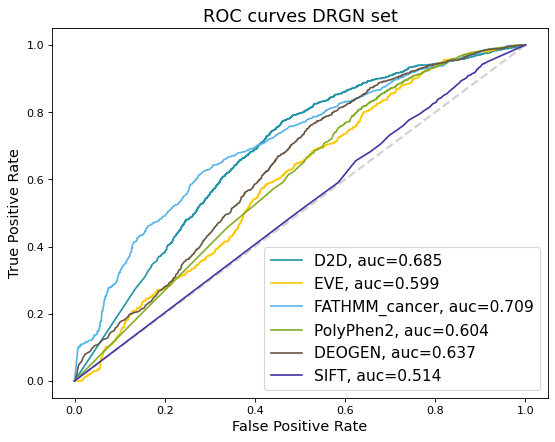

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_012023_DEOGEN_etc.csv')

figure(figsize=(8, 6), dpi=80)
lw=2

#D2D
# keep rows of resutls where D2D has values
selected_rows = results[~results['D2D'].isnull()]
fpr, tpr, _ = metrics.roc_curve(selected_rows['label'],  selected_rows['D2D'])
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['D2D']) #  probability estimates of the positive class
plt.plot(fpr,tpr,color="#2292a7",label="D2D, auc="+str(round(auc, 3))) #d20962


#EVE
selected_rows = results[~results['EVE'].isnull()]
condition1 = (selected_rows['EVE'] >= 0.5) & (selected_rows['EVE'] <= 0.62)
selected_rows['EVE_inter'] =np.where(condition1, selected_rows['EVE'] - 0.13, selected_rows['EVE'] )

condition2 = (selected_rows['EVE'] >= 0.38) & (selected_rows['EVE'] < 0.5)
selected_rows['EVE_fin'] =np.where(condition2, selected_rows['EVE'] + 0.17, selected_rows['EVE_inter'] )

fpr, tpr, _ = metrics.roc_curve(selected_rows['label'],  selected_rows['EVE_fin'])
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['EVE_fin'])
plt.plot(fpr,tpr,color="#ffc907",label="EVE, auc="+str(round(auc, 3))) # 00a78e

#FATHHM [-10, 10]
selected_rows = results[~results['FATHMM'].isnull()]
selected_rows['FATHMM_pos'] = 1- NormalizeData(selected_rows['FATHMM'])
condition1 = selected_rows['FATHMM'] < -0.75
selected_rows['FATHMM_inter'] =np.where(condition1, selected_rows['FATHMM_pos']+0.2, selected_rows['FATHMM_pos'] )
condition1 = selected_rows['FATHMM']<-9
value = 1
selected_rows['FATHMM_inter'] =np.where(condition1, value, selected_rows['FATHMM_inter'] )

fpr, tpr, _ = metrics.roc_curve(selected_rows['label'],  selected_rows['FATHMM_inter']) #+0.75
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['FATHMM_inter']) # +0.75
plt.plot(fpr,tpr,color="#56B4E9",label="FATHMM_cancer, auc="+str(round(auc, 3))) # 00bce4 ##a6192e

#Polyphen2
selected_rows = results[~results['PolyPhen2'].isnull()]
fpr, tpr, _ = metrics.roc_curve(selected_rows['label'],  selected_rows['PolyPhen2'])
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['PolyPhen2'])
plt.plot(fpr,tpr,color="#82ad27",label="PolyPhen2, auc="+str(round(auc, 3))) # 00bce4

#DEOGEN2
selected_rows = results[~results['DEOGEN2'].isnull()]
fpr, tpr, _ = metrics.roc_curve(selected_rows['label'],  selected_rows['DEOGEN2'])
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['DEOGEN2'])
plt.plot(fpr,tpr,color="#695647",label="DEOGEN, auc="+str(round(auc, 3))) # 7d3f98
plt.plot([0, 1], [0, 1], color="lightgray", lw=lw, linestyle="--")

#SIFT [0, 1]
selected_rows = results[~results['SIFT'].isnull()]
selected_rows['SIFT_pos'] = 1 - selected_rows['SIFT']
condition1 = selected_rows['SIFT']<=0.05
selected_rows['SIFT_inter'] =np.where(condition1,  1- selected_rows['SIFT'], 1- selected_rows['SIFT'] -0.5 )
condition2 = selected_rows['SIFT_inter']<0
selected_rows['SIFT_values'] =np.where(condition2,  0, selected_rows['SIFT_inter'] )

fpr, tpr, _ = metrics.roc_curve(selected_rows['label'], selected_rows['SIFT_values'])
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['SIFT_values'])
plt.plot(fpr,tpr,color="#4234a4",label="SIFT, auc="+str(round(auc, 3)))
plt.legend(loc=4, prop={'size': 14})
plt.xlabel("False Positive Rate", fontname="Calibri",fontsize=13)
plt.ylabel("True Positive Rate", fontname="Calibri",fontsize=13)
plt.title("ROC curves DRGN set",fontname="Calibri",fontsize=16)
plt.rcParams["figure.figsize"] = (8,8)

plt.show()

Keep the overlapping predictions

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_012023_DEOGEN_etc.csv')
results = results.dropna()
print(len(results))

1868


In [ ]:
# compute TP for D2D
TP_D2D, TN_D2D, FP_D2D, FN_D2D=[],[],[],[]
for i, mut in results.iterrows():
  if mut['label'] == 1 and mut['D2D'] >=0.5:
    TP_D2D.append(1)
    TN_D2D.append(0)
    FP_D2D.append(0)
    FN_D2D.append(0)
  elif mut['label'] == 1 and mut['D2D'] < 0.5:
    TP_D2D.append(0)
    TN_D2D.append(0)
    FP_D2D.append(0)
    FN_D2D.append(1)
  elif mut['label'] == 0 and mut['D2D'] >=0.5:
    TP_D2D.append(0)
    TN_D2D.append(0)
    FP_D2D.append(1)
    FN_D2D.append(0)
  elif mut['label'] == 0 and mut['D2D'] < 0.5:
    TP_D2D.append(0)
    TN_D2D.append(1)
    FP_D2D.append(0)
    FN_D2D.append(0)
  else:
    TP_D2D.append(0)
    TN_D2D.append(0)
    FP_D2D.append(0)
    FN_D2D.append(0)

results['TP_D2D'] =TP_D2D
results['TN_D2D'] =TN_D2D
results['FP_D2D'] =FP_D2D
results['FN_D2D'] =FN_D2D
acc_D2D = (results['TP_D2D'].sum() + results['TN_D2D'].sum()) / (results['TP_D2D'].sum() + results['TN_D2D'].sum() + results['FP_D2D'].sum() + results['FN_D2D'].sum())

# compute TP for SIFT
results['SIFT'] = pd.to_numeric(results['SIFT'],errors='coerce')

TP_SIFT, TN_SIFT, FP_SIFT, FN_SIFT=[],[],[],[]
for i, mut in results.iterrows():
  if (mut['label'] == 1) and (mut['SIFT'] <=0.05):
    TP_SIFT.append(1)
    TN_SIFT.append(0)
    FP_SIFT.append(0)
    FN_SIFT.append(0)
  elif (mut['label'] == 1) and (mut['SIFT'] > 0.05):
    TP_SIFT.append(0)
    TN_SIFT.append(0)
    FP_SIFT.append(0)
    FN_SIFT.append(1)
  elif (mut['label'] == 0) and (mut['SIFT'] <=0.05):
    TP_SIFT.append(0)
    TN_SIFT.append(0)
    FP_SIFT.append(1)
    FN_SIFT.append(0)
  elif (mut['label'] == 0) and (mut['SIFT'] > 0.05):
    TP_SIFT.append(0)
    TN_SIFT.append(1)
    FP_SIFT.append(0)
    FN_SIFT.append(0)
  else:
    TP_SIFT.append(0)
    TN_SIFT.append(0)
    FP_SIFT.append(0)
    FN_SIFT.append(0)

results['TP_SIFT'] =TP_SIFT
results['TN_SIFT'] =TN_SIFT
results['FP_SIFT'] =FP_SIFT
results['FN_SIFT'] =FN_SIFT

acc_SIFT= (results['TP_SIFT'].sum() + results['TN_SIFT'].sum()) / (results['TP_SIFT'].sum() + results['TN_SIFT'].sum() + results['FP_SIFT'].sum() + results['FN_SIFT'].sum())

# compute TP etc
TP_DEOGEN, TN_DEOGEN, FP_DEOGEN, FN_DEOGEN=[],[],[],[]
for i, mut in results.iterrows():
  if mut['label'] == 1 and mut['DEOGEN2'] >0.5:
    TP_DEOGEN.append(1)
    TN_DEOGEN.append(0)
    FP_DEOGEN.append(0)
    FN_DEOGEN.append(0)
  elif mut['label'] == 1 and mut['DEOGEN2'] <= 0.5:
    TP_DEOGEN.append(0)
    TN_DEOGEN.append(0)
    FP_DEOGEN.append(0)
    FN_DEOGEN.append(1)
  elif mut['label'] == 0 and mut['DEOGEN2'] >0.5:
    TP_DEOGEN.append(0)
    TN_DEOGEN.append(0)
    FP_DEOGEN.append(1)
    FN_DEOGEN.append(0)
  elif mut['label'] == 0 and mut['DEOGEN2'] <= 0.5:
    TP_DEOGEN.append(0)
    TN_DEOGEN.append(1)
    FP_DEOGEN.append(0)
    FN_DEOGEN.append(0)
  else:
    TP_DEOGEN.append(0)
    TN_DEOGEN.append(0)
    FP_DEOGEN.append(0)
    FN_DEOGEN.append(0)

results['TP_DEOGEN'] =TP_DEOGEN
results['TN_DEOGEN'] =TN_DEOGEN
results['FP_DEOGEN'] =FP_DEOGEN
results['FN_DEOGEN'] =FN_DEOGEN

acc_DEOGEN = (results['TP_DEOGEN'].sum() + results['TN_DEOGEN'].sum()) / (results['TP_DEOGEN'].sum() + results['TN_DEOGEN'].sum() + results['FP_DEOGEN'].sum() + results['FN_DEOGEN'].sum())

# compute TP etc
TP_eve, TN_eve, FP_eve, FN_eve=[],[],[],[]
for i, mut in results.iterrows():
  if mut['label'] == 1 and mut['EVE'] >=0.5:
    TP_eve.append(1)
    TN_eve.append(0)
    FP_eve.append(0)
    FN_eve.append(0)
  elif mut['label'] == 1 and mut['EVE'] < 0.5:
    TP_eve.append(0)
    TN_eve.append(0)
    FP_eve.append(0)
    FN_eve.append(1)
  elif mut['label'] == 0 and mut['EVE'] >=0.5:
    TP_eve.append(0)
    TN_eve.append(0)
    FP_eve.append(1)
    FN_eve.append(0)
  elif mut['label'] == 0 and mut['EVE'] < 0.5:
    TP_eve.append(0)
    TN_eve.append(1)
    FP_eve.append(0)
    FN_eve.append(0)
  else:
    TP_eve.append(0)
    TN_eve.append(0)
    FP_eve.append(0)
    FN_eve.append(0)

results['TP_eve'] =TP_eve
results['TN_eve'] =TN_eve
results['FP_eve'] =FP_eve
results['FN_eve'] =FN_eve

acc_EVE = (results['TP_eve'].sum() + results['TN_eve'].sum()) / (results['TP_eve'].sum() + results['TN_eve'].sum() + results['FP_eve'].sum() + results['FN_eve'].sum())

In [ ]:
# compute TP etc
TP_FATH, TN_FATH, FP_FATH, FN_FATH=[],[],[],[]
for i, mut in results.iterrows():
  if mut['label'] == 1 and mut['FATHMM'] <-0.75:
    TP_FATH.append(1)
    TN_FATH.append(0)
    FP_FATH.append(0)
    FN_FATH.append(0)
  elif mut['label'] == 1 and mut['FATHMM'] >= -0.75:
    TP_FATH.append(0)
    TN_FATH.append(0)
    FP_FATH.append(0)
    FN_FATH.append(1)
  elif mut['label'] == 0 and mut['FATHMM'] <-0.75:
    TP_FATH.append(0)
    TN_FATH.append(0)
    FP_FATH.append(1)
    FN_FATH.append(0)
  elif mut['label'] == 0 and mut['FATHMM'] >= -0.75:
    TP_FATH.append(0)
    TN_FATH.append(1)
    FP_FATH.append(0)
    FN_FATH.append(0)
  else:
    TP_FATH.append(0)
    TN_FATH.append(0)
    FP_FATH.append(0)
    FN_FATH.append(0)

results['TP_FATH'] =TP_FATH
results['TN_FATH'] =TN_FATH
results['FP_FATH'] =FP_FATH
results['FN_FATH'] =FN_FATH
acc_FATH = (results['TP_FATH'].sum() + results['TN_FATH'].sum()) / (results['TP_FATH'].sum() + results['TN_FATH'].sum() + results['FP_FATH'].sum() + results['FN_FATH'].sum())

# compute TP etc
TP_pol, TN_pol, FP_pol, FN_pol=[],[],[],[]
for i, mut in results.iterrows():
  if mut['label'] == 1 and mut['PolyPhen2'] >=0.49:
    TP_pol.append(1)
    TN_pol.append(0)
    FP_pol.append(0)
    FN_pol.append(0)
  elif mut['label'] == 1 and mut['PolyPhen2'] < 0.49:
    TP_pol.append(0)
    TN_pol.append(0)
    FP_pol.append(0)
    FN_pol.append(1)
  elif mut['label'] == 0 and mut['PolyPhen2'] > 0.49:
    TP_pol.append(0)
    TN_pol.append(0)
    FP_pol.append(1)
    FN_pol.append(0)
  elif mut['label'] == 0 and mut['PolyPhen2'] < 0.49:
    TP_pol.append(0)
    TN_pol.append(1)
    FP_pol.append(0)
    FN_pol.append(0)
  else:
    TP_pol.append(0)
    TN_pol.append(0)
    FP_pol.append(0)
    FN_pol.append(0)

results['TP_pol'] =TP_pol
results['TN_pol'] =TN_pol
results['FP_pol'] =FP_pol
results['FN_pol'] =FN_pol

acc_pol = (results['TP_pol'].sum() + results['TN_pol'].sum()) / (results['TP_pol'].sum() + results['TN_pol'].sum() + results['FP_pol'].sum() + results['FN_pol'].sum())

In [ ]:
sens_SIFT = sum(TP_SIFT) / (sum(TP_SIFT) + sum(FN_SIFT))
spec_SIFT = sum(TN_SIFT) / (sum(TN_SIFT) + sum(FP_SIFT))
print('SIFT:', round(sens_SIFT, 2), round(spec_SIFT, 2),round(acc_SIFT, 2))

#sensitivities & specificities
sens_D2D = sum(TP_D2D) / (sum(TP_D2D) + sum(FN_D2D))
spec_D2D = sum(TN_D2D) / (sum(TN_D2D) + sum(FP_D2D))
print('D2Deep:',round(sens_D2D, 2), round(spec_D2D, 2), round(acc_D2D, 2))

sens_EVE = sum(TP_eve) / (sum(TP_eve) + sum(FN_eve))
spec_EVE = sum(TN_eve) / (sum(TN_eve) + sum(FP_eve))
print('EVE:',round(sens_EVE, 2), round(spec_EVE, 2), round(acc_EVE, 2))

sens_FATH = sum(TP_FATH) / (sum(TP_FATH) + sum(FN_FATH))
spec_FATH = sum(TN_FATH) / (sum(TN_FATH) + sum(FP_FATH))
print('FATHMM:',round(sens_FATH, 2), round(spec_FATH, 2), round(acc_FATH, 2))

sens_pol = sum(TP_pol) / (sum(TP_pol) + sum(FN_pol))
spec_pol = sum(TN_pol) / (sum(TN_pol) + sum(FP_pol))
print('Polyphen2:',round(sens_pol, 2), round(spec_pol, 2), round(acc_pol, 2))

sens_DEOGEN = sum(TP_DEOGEN) / (sum(TP_DEOGEN) + sum(FN_DEOGEN))
spec_DEOGEN = sum(TN_DEOGEN) / (sum(TN_DEOGEN) + sum(FP_DEOGEN))
print('DEOGEN:',round(sens_DEOGEN, 2), round(spec_DEOGEN, 2), round(acc_DEOGEN, 2))

SIFT: 0.78 0.25 0.5
D2Deep: 0.8 0.5 0.64
EVE: 0.75 0.39 0.56
FATHMM: 0.8 0.46 0.62
Polyphen2: 0.89 0.21 0.53
DEOGEN: 0.89 0.23 0.54


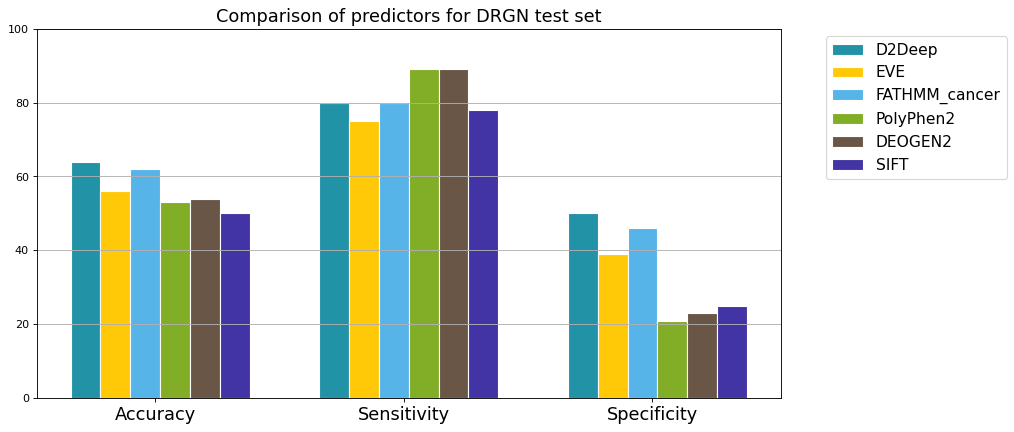

In [ ]:
D2Deep = [64, 80, 50]
EVE = [56, 75, 39 ]
FATHHM = [62, 80, 46]
PolyPhen2 = [53, 89, 21 ]
DEOGEN = [54, 89, 23 ]
SIFT = [50, 78, 25 ]

barWidth = 0.12
figure(figsize=(12, 6), dpi=80)

bars1 = [D2Deep, EVE, FATHHM, PolyPhen2, DEOGEN, SIFT ]
r1 = np.arange(len(D2Deep))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]


# Make the plot
plt.bar(r1, D2Deep, color = '#2292a7' , width=barWidth, edgecolor='white', label='D2Deep') #2166ac # ff0000 #334858 # 000000 '#ce1141' '#cd595a' da5a47
plt.bar(r2, EVE, color='#ffc907', width=barWidth, edgecolor='white', label='EVE') # 67a9cf # fbb034 # cd595a # be0027 #eeb111' 8ba753
plt.bar(r3, FATHHM, color='#56B4E9', width=barWidth, edgecolor='white', label='FATHMM_cancer') # #CC79A7 #a6192e #D55E00 #CC79A7
plt.bar(r4, PolyPhen2, color='#82ad27', width=barWidth, edgecolor='white', label='PolyPhen2') # CCFFE5 # 007ea3 # dbc5b0 # e4e932 #0087b4
plt.bar(r5, DEOGEN, color='#695647', width=barWidth, edgecolor='white', label='DEOGEN2') # FFCCE5 # 00a4e4 # f8dfc2 # 2c9f45 #5654a4
plt.bar(r6, SIFT, color='#4234a4', width=barWidth, edgecolor='white', label='SIFT') # FFCCE5 # 9e4770 #f9ebdf # 371777

# Add xticks on the middle of the group bars
plt.title('Comparison of predictors for DRGN test set',fontname="Calibri", fontsize=16)
#plt.xticks([r + barWidth+0.16 for r in range(3)],  ['Sensitivity', 'Specificity', ], rotation=35,fontname="Comic Sans MS", fontsize=12)
plt.xticks([r + barWidth+0.16 for r in range(3)],  ['Accuracy', 'Sensitivity', 'Specificity'], fontname="Calibri", fontsize=16)
plt.ylim(0, 100)
plt.grid(axis = "y")
# Create legend & Show graphic
#plt.legend(fontsize=16)

# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=14)

1868


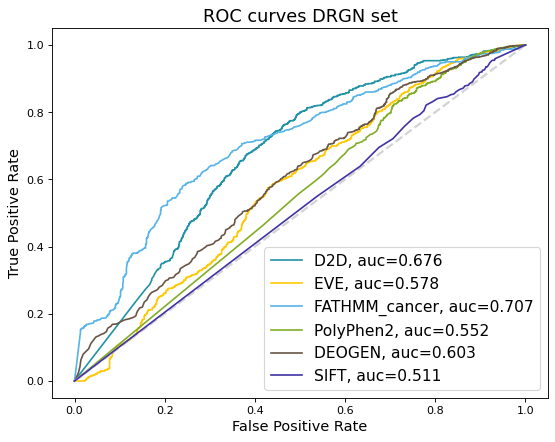

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_012023_DEOGEN_etc.csv')
results=results.dropna()

figure(figsize=(8, 6), dpi=80)
lw=2
#D2D
# keep rows of resutls where D2D has values
selected_rows = results[~results['D2D'].isnull()]
fpr, tpr, _ = metrics.roc_curve(selected_rows['label'],  selected_rows['D2D'])
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['D2D']) #  probability estimates of the positive class
plt.plot(fpr,tpr,color="#2292a7",label="D2D, auc="+str(round(auc, 3))) #d20962

#EVE
selected_rows = results[~results['EVE'].isnull()]
condition1 = (selected_rows['EVE'] >= 0.5) & (selected_rows['EVE'] <= 0.62)
selected_rows['EVE_inter'] =np.where(condition1, selected_rows['EVE'] - 0.13, selected_rows['EVE'] )

condition2 = (selected_rows['EVE'] >= 0.38) & (selected_rows['EVE'] < 0.5)
selected_rows['EVE_fin'] =np.where(condition2, selected_rows['EVE'] + 0.17, selected_rows['EVE_inter'] )

fpr, tpr, _ = metrics.roc_curve(selected_rows['label'],  selected_rows['EVE_fin'])
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['EVE_fin'])
plt.plot(fpr,tpr,color="#ffc907",label="EVE, auc="+str(round(auc, 3))) # 00a78e

#FATHHM [-10, 10]
selected_rows = results[~results['FATHMM'].isnull()]
selected_rows['FATHMM_pos'] = 1- NormalizeData(selected_rows['FATHMM'])
condition1 = selected_rows['FATHMM'] < -0.75
selected_rows['FATHMM_inter'] =np.where(condition1, selected_rows['FATHMM_pos']+0.2, selected_rows['FATHMM_pos'] )
condition1 = selected_rows['FATHMM']<-9
value = 1
selected_rows['FATHMM_inter'] =np.where(condition1, value, selected_rows['FATHMM_inter'] )

fpr, tpr, _ = metrics.roc_curve(selected_rows['label'],  selected_rows['FATHMM_inter']) #+0.75
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['FATHMM_inter']) # +0.75
plt.plot(fpr,tpr,color="#56B4E9",label="FATHMM_cancer, auc="+str(round(auc, 3))) # 00bce4 #

#Polyphen2
selected_rows = results[~results['PolyPhen2'].isnull()]
fpr, tpr, _ = metrics.roc_curve(selected_rows['label'],  selected_rows['PolyPhen2'])
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['PolyPhen2'])
plt.plot(fpr,tpr,color="#82ad27",label="PolyPhen2, auc="+str(round(auc, 3))) # 00bce4

#DEOGEN2
selected_rows = results[~results['DEOGEN2'].isnull()]
fpr, tpr, _ = metrics.roc_curve(selected_rows['label'],  selected_rows['DEOGEN2'])
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['DEOGEN2'])
plt.plot(fpr,tpr,color="#695647",label="DEOGEN, auc="+str(round(auc, 3))) # 7d3f98
plt.plot([0, 1], [0, 1], color="lightgray", lw=lw, linestyle="--")

#SIFT [0, 1]
selected_rows = results[~results['SIFT'].isnull()]
selected_rows['SIFT_pos'] = 1 - selected_rows['SIFT']
condition1 = selected_rows['SIFT']<=0.05
selected_rows['SIFT_inter'] =np.where(condition1,  1- selected_rows['SIFT'], 1- selected_rows['SIFT'] -0.5 )
condition2 = selected_rows['SIFT_inter']<0
selected_rows['SIFT_values'] =np.where(condition2,  0, selected_rows['SIFT_inter'] )

fpr, tpr, _ = metrics.roc_curve(selected_rows['label'], selected_rows['SIFT_values'])
auc = metrics.roc_auc_score(selected_rows['label'], selected_rows['SIFT_values'])
plt.plot(fpr,tpr,color="#4234a4",label="SIFT, auc="+str(round(auc, 3)))
plt.legend(loc=4, prop={'size': 14})
plt.xlabel("False Positive Rate", fontname="Calibri",fontsize=13)
plt.ylabel("True Positive Rate", fontname="Calibri",fontsize=13)
plt.title("ROC curves DRGN set",fontname="Calibri",fontsize=16)
plt.rcParams["figure.figsize"] = (8,8)

plt.show()

### Are there genes easier to predict than others? Outdated

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_122022_sorted.csv')

In [ ]:
# create D2D dictionary with keys: genes, values: (TP, TN, FP, FN)
genes = results['uniprot id'].unique()
D2D_results_genes = {}
for gene in genes:
  temp = results[results['uniprot id'] == gene]
  for i, mut in temp.iterrows():
    if mut['label'] == 1 and mut['D2D'] >=0.5:
      if gene in D2D_results_genes:
        D2D_results_genes[gene][0] +=1
      else:
        D2D_results_genes[gene] =[1, 0, 0, 0]
    elif mut['label'] == 1 and mut['D2D'] < 0.5:
      if gene in D2D_results_genes:
        D2D_results_genes[gene][3] +=1
      else:
        D2D_results_genes[gene] =[0, 0, 0, 1]
    elif mut['label'] == 0 and mut['D2D'] >=0.5:
      if gene in D2D_results_genes:
        D2D_results_genes[gene][2] +=1
      else:
        D2D_results_genes[gene] =[0, 0, 1, 0]
    elif mut['label'] == 0 and mut['D2D'] < 0.5:
      if gene in D2D_results_genes:
        D2D_results_genes[gene][1] +=1
      else:
        D2D_results_genes[gene]  =[0, 1, 0, 0]

#  for all genes, calculate sensitivity and specificity
D2D_results_genes_sens={}
D2D_results_genes_spec={}
for keys, values in D2D_results_genes.items():
  if D2D_results_genes[keys][0]>0:
    sens = round(D2D_results_genes[keys][0] / (D2D_results_genes[keys][0]+ D2D_results_genes[keys][3]),2)
  else:
    sens = 0
  if D2D_results_genes[keys][1]>0:
    spec =  round(D2D_results_genes[keys][1] / (D2D_results_genes[keys][1]+ D2D_results_genes[keys][2]),2)
  else:
    spec=0
  D2D_results_genes_sens[keys] =sens
  D2D_results_genes_spec[keys]= spec

dict_new = dict(sorted(D2D_results_genes_sens.items(), key=lambda item: item[1],reverse=True))
names_sens = list(dict_new.keys())
values_sens = list(dict_new.values())

dict_new = dict(sorted(D2D_results_genes_spec.items(), key=lambda item: item[1],reverse=True))
names_spec = list(dict_new.keys())
values_spec = list(dict_new.values())

#print(names_sens[:30])
#print(names_spec[:30])
# find 50 proteins with highest sensitivities AND specificities
easier_proteins = intersection(names_sens[:100], names_spec[:100])
hardest_proteins= intersection(names_sens[100:], names_spec[100:])
print(easier_proteins)
print(hardest_proteins)
#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_sens[:30], tick_label=names_sens[:30])
#plt.xticks(rotation=45)
#plt.show()

#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_spec[:30], tick_label=names_spec[:30])
#plt.xticks(rotation=45)
#plt.show()

['Q07812-1', 'O14746-1', 'P36888-1', 'P55317-1', 'Q86YC2-1', 'P51654-1', 'P16403-1', 'P38398-5', 'P42338-1', 'P16234-1', 'P12830-1', 'O96017-1', 'P23468-1', 'O14522-1', 'P10415-1', 'Q05209-1', 'Q9Y2L1-1', 'P23458-1', 'P01106-1', 'P22681-1', 'Q9BX63-1', 'P04626-1', 'Q99062-1', 'O15360-1', 'H0YHS4-1', 'P78545-1', 'P29323-1', 'Q16288-1', 'P45985-1', 'Q92560-1', 'P00519-2', 'P52333-1', 'P22607-1', 'O75874-1', 'P50148-1', 'Q96BI1-1', 'P03372-1', 'Q99708-1', 'P08069-1', 'Q14145-1', 'P42771-1', 'P38398-1', 'Q969H0-1', 'P63000-1', 'P30281-1', 'P35968-1', 'Q92574-1', 'P06400-1', 'P21860-1']
['Q9UIF7-2', 'P21802-20', 'P11362-2', 'A0A087WZ58-1', 'Q5JY90-1', 'P36507-1', 'Q15910-4', 'P35240-4', 'P04629-3', 'A0A087X1B6-1', 'P21802-3', 'O75030-4', 'P37231-1', 'P10721-2', 'P35240-1', 'Q96SW2-1', 'P21802-23', 'P21802-21', 'P04637-9', 'P36897-1', 'P11362-8', 'Q16288-3', 'C9JKM5-1', 'P15056-1', 'O75030-2', 'P10721-1', 'E7EQS8-1', 'P38398-8', 'P25445-1', 'P37231-2', 'P11362-21', 'P10275-1', 'P21802-8', 'Q

#### What are the training variants for those best / worst genes?

In [ ]:
dict_prot_dif_mut = {} # deleterious / benign samples in training set
for ind, mut in dif_mut.iterrows():
    pr = mut['mutation'].split('_')[0]
    if pr not in dict_prot_dif_mut:
      if mut['label'] == 0:
        dict_prot_dif_mut[pr]= [1,0]
      else:
        dict_prot_dif_mut[pr]= [0,1]
    else:
      if mut['label'] == 0:
        dict_prot_dif_mut[pr][0]+= 1
      else:
        dict_prot_dif_mut[pr][1]+= 1

In [ ]:
easy_flag, protein, train_del, train_ben, test_del, test_ben = [],[],[],[],[],[]
for prot in easier_proteins:
  easy_flag.append(1)
  protein.append(prot)
  if prot not in dict_prot_dif_mut:
    train_del.append(0)
    train_ben.append(0)
  else:
    train_del.append(dict_prot_dif_mut[prot][1])
    train_ben.append(dict_prot_dif_mut[prot][0])
  temp = results[results['uniprot id'] == prot]
  temp_del = temp[temp['label'] ==1]
  temp_ben = temp[temp['label'] ==0]
  test_del.append(len(temp_del))
  test_ben.append(len(temp_ben))

for prot in hardest_proteins:
  easy_flag.append(0)
  protein.append(prot)
  if prot not in dict_prot_dif_mut:
    train_del.append(0)
    train_ben.append(0)
  else:
    train_del.append(dict_prot_dif_mut[prot][1])
    train_ben.append(dict_prot_dif_mut[prot][0])
  temp = results[results['uniprot id'] == prot]
  temp_del = temp[temp['label'] ==1]
  temp_ben = temp[temp['label'] ==0]
  test_del.append(len(temp_del))
  test_ben.append(len(temp_ben))

easy_hard_comb= pd.DataFrame(list(zip(easy_flag, protein, train_del, train_ben, test_del, test_ben)),
               columns =['easy_flag', 'protein', 'train_del', 'train_ben', 'test_del', 'test_ben'])#, 'Length'])

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' wh

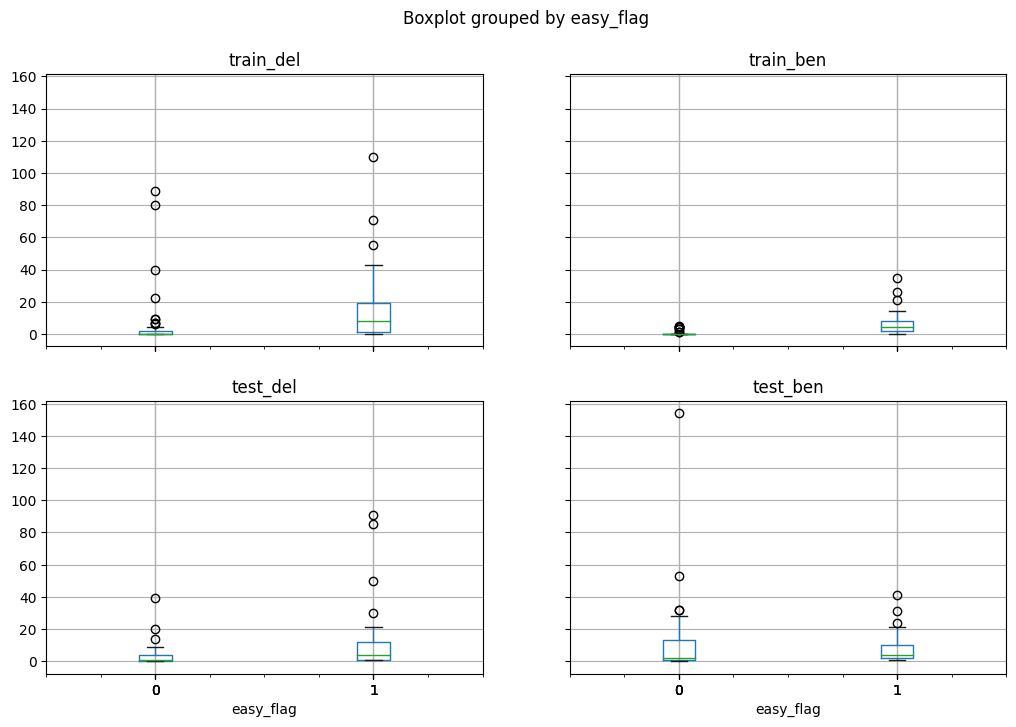

In [ ]:
easy_hard_comb.boxplot(column=['train_del', 'train_ben', 'test_del', 'test_ben'], by='easy_flag', figsize=(12, 8))
plt.show()

In [ ]:
easy_flag, protein, msa_len_orig, msa_final, msa_dif = [],[],[],[],[]
for prot in easier_proteins:
  easy_flag.append(1)
  protein.append(prot)
  if prot not in dict_prot_dif_mut:
    continue
  else:
    msa_len_orig.append(int(msa_orig_nb[prot]))
    msa_final.append(int(msa_final_nb[prot]))
    msa_dif.append(int(msa_orig_nb[prot]) - int(msa_final_nb[prot]))

for prot in hardest_proteins:
  easy_flag.append(0)
  protein.append(prot)
  if prot not in dict_prot_dif_mut:
    continue
  else:
    msa_len_orig.append(int(msa_orig_nb[prot]))
    msa_final.append(int(msa_final_nb[prot]))
    msa_dif.append(int(msa_orig_nb[prot]) - int(msa_final_nb[prot]))

easy_hard_msa= pd.DataFrame(list(zip(easy_flag, protein, msa_len_orig, msa_final, msa_dif)),
               columns =['easy_flag', 'protein', 'msa_len_orig', 'msa_final', 'msa_dif'])#, 'Length'])

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' wh

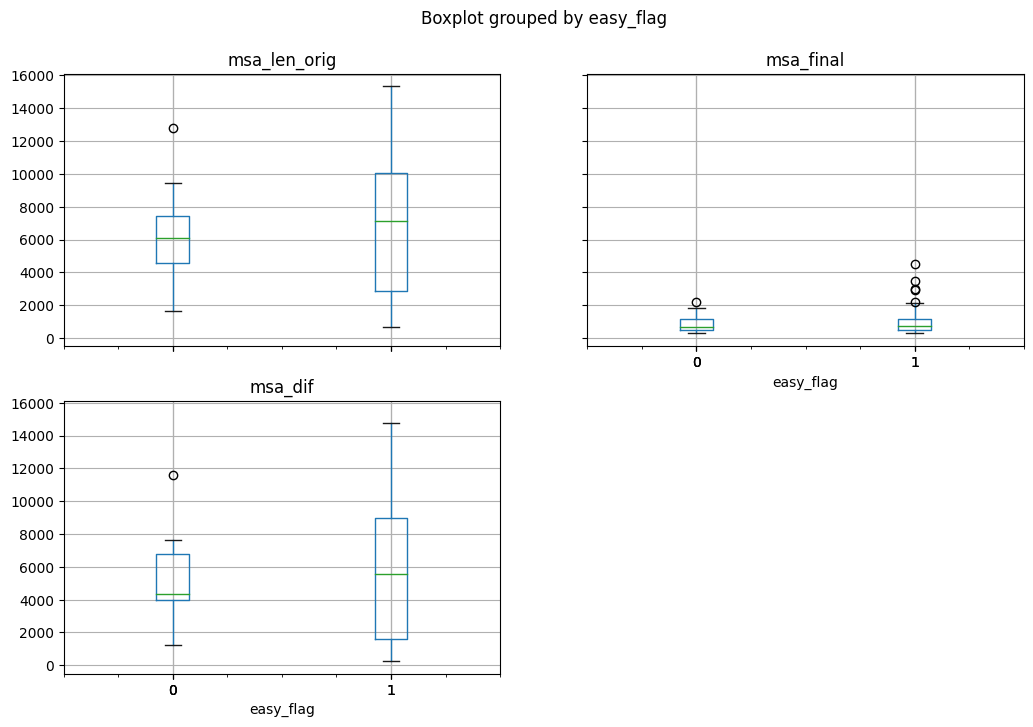

In [ ]:
easy_hard_msa.boxplot(column=['msa_len_orig', 'msa_final', 'msa_dif'], by='easy_flag', figsize=(12, 8))
plt.show()

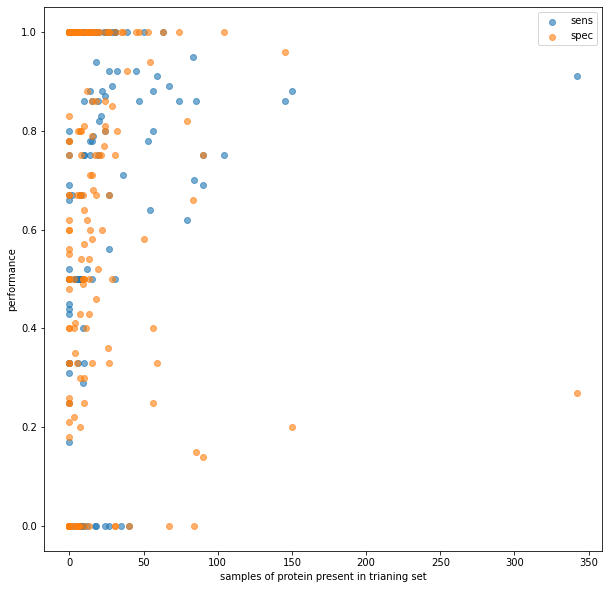

In [ ]:
samples_easy = 0
training_len, sens, spec = [], [], []
for i, easy_prot in enumerate(D2D_results_genes_sens.keys()):
  temp = dif_mut[dif_mut['mutation'].str.contains(easy_prot)]
  samples_easy += len(temp)
  training_len.append(len(temp))
  sens.append(D2D_results_genes_sens[easy_prot])
  spec.append(D2D_results_genes_spec[easy_prot])
plt.scatter(training_len, sens, label='sens', alpha = 0.6)
plt.scatter(training_len, spec, label='spec', alpha = 0.6)

# Add axis labels and a legend
plt.xlabel('samples of protein present in trianing set')
plt.ylabel('performance')
plt.legend()

# Show the plot
plt.show()

In [ ]:
from itertools import islice

def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

#### Rest

In [ ]:
# create EVE dictionary with keys: genes, values: (TP, TN, FP, FN)
genes = results['uniprot id'].unique()
EVE_results_genes = {}
for gene in genes:
  temp = results[results['uniprot id'] == gene]
  for i, mut in temp.iterrows():
    if mut['label'] == 1 and mut['EVE'] >=0.5:
      if gene in EVE_results_genes:
        EVE_results_genes[gene][0] +=1
      else:
        EVE_results_genes[gene] =[1, 0, 0, 0]
    elif mut['label'] == 1 and mut['EVE'] < 0.5:
      if gene in EVE_results_genes:
        EVE_results_genes[gene][3] +=1
      else:
        EVE_results_genes[gene] =[0, 0, 0, 1]
    elif mut['label'] == 0 and mut['EVE'] >=0.5:
      if gene in EVE_results_genes:
        EVE_results_genes[gene][2] +=1
      else:
        EVE_results_genes[gene] =[0, 0, 1, 0]
    elif mut['label'] == 0 and mut['EVE'] < 0.5:
      if gene in EVE_results_genes:
        EVE_results_genes[gene][1] +=1
      else:
        EVE_results_genes[gene]  =[0, 1, 0, 0]

#  for all genes, calculate sensitivity and specificity
EVE_results_genes_sens={}
EVE_results_genes_spec={}
for keys, values in EVE_results_genes.items():
  if EVE_results_genes[keys][0]>0:
    sens = round(EVE_results_genes[keys][0] / (EVE_results_genes[keys][0]+ EVE_results_genes[keys][3]),2)
  else:
    sens = 0
  if EVE_results_genes[keys][1]>0:
    spec =  round(EVE_results_genes[keys][1] / (EVE_results_genes[keys][1]+ EVE_results_genes[keys][2]),2)
  else:
    spec=0
  EVE_results_genes_sens[keys] =sens
  EVE_results_genes_spec[keys]= spec

dict_new = dict(sorted(EVE_results_genes_sens.items(), key=lambda item: item[1],reverse=True))
names_sens = list(dict_new.keys())
values_sens = list(dict_new.values())

dict_new = dict(sorted(EVE_results_genes_spec.items(), key=lambda item: item[1],reverse=True))
names_spec = list(dict_new.keys())
values_spec = list(dict_new.values())

print(names_sens[:30])
#print(names_spec[:30])
# find 50 proteins with highest sensitivities AND specificities
easier_proteins = intersection(names_sens[:70], names_spec[:70])
#print(easier_proteins)
#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_sens[:30], tick_label=names_sens[:30])
#plt.xticks(rotation=45)
#plt.show()

#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_spec[:30], tick_label=names_spec[:30])
#plt.xticks(rotation=45)
#plt.show()

['O14746-1', 'O15360-1', 'O75874-1', 'P00519-1', 'P01106-1', 'P04198-1', 'P07333-1', 'P07954-1', 'P16871-1', 'P21912-1', 'P23508-1', 'P29992-1', 'P30153-1', 'P35240-1', 'P37173-1', 'P41212-1', 'P48436-1', 'P48735-1', 'P50148-1', 'P51654-1', 'P54278-1', 'P58012-1', 'P63000-1', 'Q01196-1', 'Q07812-1', 'Q07864-1', 'Q13485-1', 'Q5JWF2-1', 'Q86YC2-1', 'Q8NEZ4-1']


In [ ]:
# create DEOGEN2 dictionary with keys: genes, values: (TP, TN, FP, FN)
genes = results['uniprot id'].unique()
DEOGEN2_results_genes = {}
for gene in genes:
  temp = results[results['uniprot id'] == gene]
  for i, mut in temp.iterrows():
    if mut['label'] == 1 and mut['DEOGEN2'] >=0.5:
      if gene in DEOGEN2_results_genes:
        DEOGEN2_results_genes[gene][0] +=1
      else:
        DEOGEN2_results_genes[gene] =[1, 0, 0, 0]
    elif mut['label'] == 1 and mut['DEOGEN2'] < 0.5:
      if gene in DEOGEN2_results_genes:
        DEOGEN2_results_genes[gene][3] +=1
      else:
        DEOGEN2_results_genes[gene] =[0, 0, 0, 1]
    elif mut['label'] == 0 and mut['DEOGEN2'] >=0.5:
      if gene in DEOGEN2_results_genes:
        DEOGEN2_results_genes[gene][2] +=1
      else:
        DEOGEN2_results_genes[gene] =[0, 0, 1, 0]
    elif mut['label'] == 0 and mut['DEOGEN2'] < 0.5:
      if gene in DEOGEN2_results_genes:
        DEOGEN2_results_genes[gene][1] +=1
      else:
        DEOGEN2_results_genes[gene]  =[0, 1, 0, 0]

#  for all genes, calculate sensitivity and specificity
DEOGEN2_results_genes_sens={}
DEOGEN2_results_genes_spec={}
for keys, values in DEOGEN2_results_genes.items():
  if DEOGEN2_results_genes[keys][0]>0:
    sens = round(DEOGEN2_results_genes[keys][0] / (DEOGEN2_results_genes[keys][0]+ DEOGEN2_results_genes[keys][3]),2)
  else:
    sens = 0
  if DEOGEN2_results_genes[keys][1]>0:
    spec =  round(DEOGEN2_results_genes[keys][1] / (DEOGEN2_results_genes[keys][1]+ DEOGEN2_results_genes[keys][2]),2)
  else:
    spec=0
  DEOGEN2_results_genes_sens[keys] =sens
  DEOGEN2_results_genes_spec[keys]= spec

dict_new = dict(sorted(DEOGEN2_results_genes_sens.items(), key=lambda item: item[1],reverse=True))
names_sens = list(dict_new.keys())
values_sens = list(dict_new.values())

dict_new = dict(sorted(DEOGEN2_results_genes_spec.items(), key=lambda item: item[1],reverse=True))
names_spec = list(dict_new.keys())
values_spec = list(dict_new.values())

print(names_sens[:30])
#print(names_spec[:30])
# find 50 proteins with highest sensitivities AND specificities
easier_proteins = intersection(names_sens[:90], names_spec[:90])
#print(easier_proteins)
#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_sens[:30], tick_label=names_sens[:30])
#plt.xticks(rotation=45)
#plt.show()

#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_spec[:30], tick_label=names_spec[:30])
#plt.xticks(rotation=45)
#plt.show()

['H0YHS4-1', 'O14746-1', 'O15151-1', 'O15360-1', 'O60674-1', 'O75874-1', 'P00519-1', 'P01106-1', 'P01111-1', 'P01112-1', 'P03372-1', 'P04049-1', 'P07954-1', 'P08069-1', 'P08922-1', 'P10415-1', 'P11362-1', 'P11802-1', 'P16885-1', 'P21359-1', 'P21802-1', 'P21860-1', 'P21912-1', 'P22455-1', 'P22681-1', 'P23458-1', 'P25445-1', 'P29992-1', 'P30153-1', 'P31749-1']


In [ ]:
# create polyphen2 dictionary with keys: genes, values: (TP, TN, FP, FN)
genes = results['uniprot id'].unique()
polyphen2_results_genes = {}
for gene in genes:
  temp = results[results['uniprot id'] == gene]
  for i, mut in temp.iterrows():
    if mut['label'] == 1 and mut['polyphen2'] >=0.49:
      if gene in polyphen2_results_genes:
        polyphen2_results_genes[gene][0] +=1
      else:
        polyphen2_results_genes[gene] =[1, 0, 0, 0]
    elif mut['label'] == 1 and mut['polyphen2'] < 0.49:
      if gene in polyphen2_results_genes:
        polyphen2_results_genes[gene][3] +=1
      else:
        polyphen2_results_genes[gene] =[0, 0, 0, 1]
    elif mut['label'] == 0 and mut['polyphen2'] >=0.49:
      if gene in polyphen2_results_genes:
        polyphen2_results_genes[gene][2] +=1
      else:
        polyphen2_results_genes[gene] =[0, 0, 1, 0]
    elif mut['label'] == 0 and mut['polyphen2'] < 0.49:
      if gene in polyphen2_results_genes:
        polyphen2_results_genes[gene][1] +=1
      else:
        polyphen2_results_genes[gene]  =[0, 1, 0, 0]

#  for all genes, calculate sensitivity and specificity
polyphen2_results_genes_sens={}
polyphen2_results_genes_spec={}
for keys, values in polyphen2_results_genes.items():
  if polyphen2_results_genes[keys][0]>0:
    sens = round(polyphen2_results_genes[keys][0] / (polyphen2_results_genes[keys][0]+ polyphen2_results_genes[keys][3]),2)
  else:
    sens = 0
  if polyphen2_results_genes[keys][1]>0:
    spec =  round(polyphen2_results_genes[keys][1] / (polyphen2_results_genes[keys][1]+ polyphen2_results_genes[keys][2]),2)
  else:
    spec=0
  polyphen2_results_genes_sens[keys] =sens
  polyphen2_results_genes_spec[keys]= spec

dict_new = dict(sorted(polyphen2_results_genes_sens.items(), key=lambda item: item[1],reverse=True))
names_sens = list(dict_new.keys())
values_sens = list(dict_new.values())

dict_new = dict(sorted(polyphen2_results_genes_spec.items(), key=lambda item: item[1],reverse=True))
names_spec = list(dict_new.keys())
values_spec = list(dict_new.values())

print(names_sens[:30])
#print(names_spec[:30])
# find 50 proteins with highest sensitivities AND specificities
easier_proteins = intersection(names_sens[:90], names_spec[:90])
#print(easier_proteins)
#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_sens[:30], tick_label=names_sens[:30])
#plt.xticks(rotation=45)
#plt.show()

#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_spec[:30], tick_label=names_spec[:30])
#plt.xticks(rotation=45)
#plt.show()

['E7EQS8-1', 'O14746-1', 'O15151-1', 'O15360-1', 'O60674-1', 'O96017-1', 'P00519-2', 'P01106-1', 'P04198-1', 'P04626-1', 'P04626-5', 'P04629-3', 'P07333-1', 'P07954-1', 'P08922-1', 'P10415-1', 'P11362-1', 'P12830-1', 'P16403-1', 'P16871-1', 'P16885-1', 'P20936-1', 'P21912-1', 'P22455-1', 'P23458-1', 'P29992-1', 'P30153-1', 'P35240-1', 'P35968-1', 'P36507-1']


In [ ]:
# create SIFT dictionary with keys: genes, values: (TP, TN, FP, FN)
genes = results['uniprot id'].unique()
SIFT_results_genes = {}
for gene in genes:
  temp = results[results['uniprot id'] == gene]
  for i, mut in temp.iterrows():
    if mut['label'] == 1 and mut['SIFT'] <=0.05:
      if gene in SIFT_results_genes:
        SIFT_results_genes[gene][0] +=1
      else:
        SIFT_results_genes[gene] =[1, 0, 0, 0]
    elif mut['label'] == 1 and mut['SIFT'] > 0.05:
      if gene in SIFT_results_genes:
        SIFT_results_genes[gene][3] +=1
      else:
        SIFT_results_genes[gene] =[0, 0, 0, 1]
    elif mut['label'] == 0 and mut['SIFT'] <=0.05:
      if gene in SIFT_results_genes:
        SIFT_results_genes[gene][2] +=1
      else:
        SIFT_results_genes[gene] =[0, 0, 1, 0]
    elif mut['label'] == 0 and mut['SIFT'] > 0.05:
      if gene in SIFT_results_genes:
        SIFT_results_genes[gene][1] +=1
      else:
        SIFT_results_genes[gene]  =[0, 1, 0, 0]


#  for all genes, calculate sensitivity and specificity
SIFT_results_genes_sens={}
SIFT_results_genes_spec={}
for keys, values in SIFT_results_genes.items():
  if SIFT_results_genes[keys][0]>0:
    sens = round(SIFT_results_genes[keys][0] / (SIFT_results_genes[keys][0]+ SIFT_results_genes[keys][3]),2)
  else:
    sens = 0
  if SIFT_results_genes[keys][1]>0:
    spec =  round(SIFT_results_genes[keys][1] / (SIFT_results_genes[keys][1]+ SIFT_results_genes[keys][2]),2)
  else:
    spec=0
  SIFT_results_genes_sens[keys] =sens
  SIFT_results_genes_spec[keys]= spec

dict_new = dict(sorted(SIFT_results_genes_sens.items(), key=lambda item: item[1],reverse=True))
names_sens = list(dict_new.keys())
values_sens = list(dict_new.values())

dict_new = dict(sorted(SIFT_results_genes_spec.items(), key=lambda item: item[1],reverse=True))
names_spec = list(dict_new.keys())
values_spec = list(dict_new.values())

print(names_sens[:30])
#print(names_spec[:30])
# find 50 proteins with highest sensitivities AND specificities
easier_proteins = intersection(names_sens[:90], names_spec[:90])
#print(easier_proteins)
#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_sens[:30], tick_label=names_sens[:30])
#plt.xticks(rotation=45)
#plt.show()

#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_spec[:30], tick_label=names_spec[:30])
#plt.xticks(rotation=45)
#plt.show()

['E7EQS8-1', 'E7EVR7-1', 'H0YHS4-1', 'O75874-1', 'O96017-1', 'P01106-1', 'P01111-1', 'P01112-1', 'P04198-1', 'P04637-6', 'P04637-9', 'P07954-1', 'P11802-1', 'P12830-1', 'P16403-1', 'P16885-1', 'P21359-1', 'P21802-21', 'P21912-1', 'P22455-1', 'P22681-1', 'P25054-3', 'P29992-1', 'P30153-1', 'P30281-1', 'P35240-1', 'P36897-1', 'P37173-1', 'P38398-1', 'P40238-1']


In [ ]:
# create FATHMM dictionary with keys: genes, values: (TP, TN, FP, FN)
genes = results['uniprot id'].unique()
FATHMM_results_genes = {}
for gene in genes:
  temp = results[results['uniprot id'] == gene]
  for i, mut in temp.iterrows():
    if mut['label'] == 1 and mut['FATHMM'] <=-0.75:
      if gene in FATHMM_results_genes:
        FATHMM_results_genes[gene][0] +=1
      else:
        FATHMM_results_genes[gene] =[1, 0, 0, 0]
    elif mut['label'] == 1 and mut['FATHMM'] >-0.75:
      if gene in FATHMM_results_genes:
        FATHMM_results_genes[gene][3] +=1
      else:
        FATHMM_results_genes[gene] =[0, 0, 0, 1]
    elif mut['label'] == 0 and mut['FATHMM'] <=-0.75:
      if gene in FATHMM_results_genes:
        FATHMM_results_genes[gene][2] +=1
      else:
        FATHMM_results_genes[gene] =[0, 0, 1, 0]
    elif mut['label'] == 0 and mut['FATHMM'] > -0.75:
      if gene in FATHMM_results_genes:
        FATHMM_results_genes[gene][1] +=1
      else:
        FATHMM_results_genes[gene]  =[0, 1, 0, 0]


#  for all genes, calculate sensitivity and specificity
FATHMM_results_genes_sens={}
FATHMM_results_genes_spec={}
for keys, values in FATHMM_results_genes.items():
  if FATHMM_results_genes[keys][0]>0:
    sens = round(FATHMM_results_genes[keys][0] / (FATHMM_results_genes[keys][0]+ FATHMM_results_genes[keys][3]),2)
  else:
    sens = 0
  if FATHMM_results_genes[keys][1]>0:
    spec =  round(FATHMM_results_genes[keys][1] / (FATHMM_results_genes[keys][1]+ FATHMM_results_genes[keys][2]),2)
  else:
    spec=0
  FATHMM_results_genes_sens[keys] =sens
  FATHMM_results_genes_spec[keys]= spec

dict_new = dict(sorted(FATHMM_results_genes_sens.items(), key=lambda item: item[1],reverse=True))
names_sens = list(dict_new.keys())
values_sens = list(dict_new.values())

dict_new = dict(sorted(FATHMM_results_genes_spec.items(), key=lambda item: item[1],reverse=True))
names_spec = list(dict_new.keys())
values_spec = list(dict_new.values())

print(names_sens[:30])
#print(names_spec[:30])
# find 50 proteins with highest sensitivities AND specificities
easier_proteins = intersection(names_sens[:90], names_spec[:90])
#print(easier_proteins)
#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_sens[:30], tick_label=names_sens[:30])
#plt.xticks(rotation=45)
#plt.show()

#figure(figsize=(30, 10), dpi=80)
#plt.bar(range(30), values_spec[:30], tick_label=names_spec[:30])
#plt.xticks(rotation=45)
#plt.show()

['E7EVR7-1', 'E9PNY0-1', 'O60674-1', 'O75874-1', 'P00519-1', 'P01111-1', 'P01112-1', 'P01116-1', 'P04049-1', 'P04626-1', 'P04637-1', 'P06400-1', 'P07333-1', 'P07949-1', 'P07954-1', 'P08069-1', 'P08581-1', 'P08922-1', 'P11362-1', 'P15056-1', 'P16234-1', 'P22455-1', 'P22681-1', 'P23458-1', 'P29992-1', 'P36888-1', 'P40337-1', 'P40337-2', 'P40692-1', 'P42336-1']


# Entire gene calculation

## TP53

In [ ]:
# import difference for each mutation
test = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_P04637_2200AA_57_maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

fl_dif = []
for x in test['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

test['fl_dif'] = fl_dif


# pad to 2200 AA
N= 2200
fl_dif_pad, positions, proteins_temp =[], [], []
for i, mut in test.iterrows():
  mut_temp = mut.mutation.split('_')[1]
  proteins_temp.append(mut.mutation.split('_')[0])
  positions.append(mut_temp[1: -1])
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
test['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in test.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

torch.Size([7467, 2200])


In [ ]:
labels_drgn = test['label'].tolist()
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
my_net.eval()

with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = my_net(X_batch)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

In [ ]:
test['D2D_values'] = flat_list
test['pos'] = positions
test['pos'] = pd.to_numeric(test['pos'],errors='coerce')
test = test.sort_values(by='pos', ascending=True)

fig = px.scatter(test, x='pos', y='D2D_values',
                 color =  test['D2D_values'])
                 #symbol = test['label_proc'],
                 #symbol_sequence= ['x','circle-open', 'x', 'circle-open', 'x'],
                 #color_discrete_sequence = ['red', 'green', 'salmon', 'gold', 'blue'], opacity = 0.55, width =1300, height =400)

# Change the bar mode
fig.update_layout(barmode='group', title="TP53  - all mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    title_font_family="Arial")
fig.show()

In [ ]:
df = pd.DataFrame(test['mutation'],columns=['mutation'])
newList = [round(n, 4) for n in flat_list]
df['prediction']=newList
df.to_csv('/content/drive/MyDrive/TP53_d2d_results2.csv', index=False)

## BRAF

In [ ]:
# import difference for each mutation
test = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_P15056_2200AA_57_maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

fl_dif = []
for x in test['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

test['fl_dif'] = fl_dif

# pad to 2200 AA
N= 2200
fl_dif_pad, positions, proteins_temp =[], [], []
for i, mut in test.iterrows():
  mut_temp = mut.mutation.split('_')[1]
  proteins_temp.append(mut.mutation.split('_')[0])
  positions.append(mut_temp[1: -1])
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
test['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in test.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

torch.Size([14554, 2200])


In [ ]:
labels_drgn = test['label'].tolist()
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
my_net.eval()

with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = my_net(X_batch)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

In [ ]:
test['D2D_values'] = flat_list
test['pos'] = positions
test['pos'] = pd.to_numeric(test['pos'],errors='coerce')
test = test.sort_values(by='pos', ascending=True)

fig = px.scatter(test, x='pos', y='D2D_values',
                 color =  test['D2D_values'])
                 #symbol = test['label_proc'],
                 #symbol_sequence= ['x','circle-open', 'x', 'circle-open', 'x'],
                 #color_discrete_sequence = ['red', 'green', 'salmon', 'gold', 'blue'], opacity = 0.55, width =1300, height =400)


# Change the bar mode
fig.update_layout(barmode='group', title="BRAF  - all mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    title_font_family="Arial")
fig.show()

In [ ]:
df = pd.DataFrame(test['mutation'],columns=['mutation'])
newList = [round(n, 4) for n in flat_list]
df['prediction']=newList
df.to_csv('/content/drive/MyDrive/BRAF_d2d_results.csv', index=False)

## AR

In [ ]:
# import difference for each mutation
test = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_P10275_2200AA_57_maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

fl_dif = []
for x in test['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

test['fl_dif'] = fl_dif

# pad to 2200 AA
N= 2200
fl_dif_pad, positions, proteins_temp =[], [], []
for i, mut in test.iterrows():
  mut_temp = mut.mutation.split('_')[1]
  proteins_temp.append(mut.mutation.split('_')[0])
  positions.append(mut_temp[1: -1])
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
test['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in test.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

torch.Size([17480, 2200])


In [ ]:
labels_drgn = test['label'].tolist()
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
model.eval()

with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

In [ ]:
test['D2D_values'] = flat_list
test['pos'] = positions
test['pos'] = pd.to_numeric(test['pos'],errors='coerce')
test = test.sort_values(by='pos', ascending=True)

fig = px.scatter(test, x='pos', y='D2D_values',
                 color =  test['D2D_values'])
                 #symbol = test['label_proc'],
                 #symbol_sequence= ['x','circle-open', 'x', 'circle-open', 'x'],
                 #color_discrete_sequence = ['red', 'green', 'salmon', 'gold', 'blue'], opacity = 0.55, width =1300, height =400)


# Change the bar mode
fig.update_layout(barmode='group', title="AR  - all mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    title_font_family="Arial")
fig.show()

In [ ]:
df = pd.DataFrame(test['mutation'],columns=['mutation'])
newList = [round(n, 4) for n in flat_list]
df['prediction']=newList
df.to_csv('/content/drive/MyDrive/AR_d2d_results.csv', index=False)

## PTEN

In [ ]:
# import difference for each mutation
test = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_P60484_2200AA_57_maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

fl_dif = []
for x in test['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

test['fl_dif'] = fl_dif

# pad to 2200 AA
N= 2200
fl_dif_pad, positions, proteins_temp =[], [], []
for i, mut in test.iterrows():
  mut_temp = mut.mutation.split('_')[1]
  proteins_temp.append(mut.mutation.split('_')[0])
  positions.append(mut_temp[1: -1])
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
test['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in test.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

labels_drgn = test['label'].tolist()
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
model.eval()

with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

torch.Size([7657, 2200])


In [ ]:
test['D2D_values'] = flat_list
test['pos'] = positions
test['pos'] = pd.to_numeric(test['pos'],errors='coerce')
test = test.sort_values(by='pos', ascending=True)

fig = px.scatter(test, x='pos', y='D2D_values',
                 color =  test['D2D_values'])
                 #symbol = test['label_proc'],
                 #symbol_sequence= ['x','circle-open', 'x', 'circle-open', 'x'],
                 #color_discrete_sequence = ['red', 'green', 'salmon', 'gold', 'blue'], opacity = 0.55, width =1300, height =400)


# Change the bar mode
fig.update_layout(barmode='group', title="PTEN - all mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    title_font_family="Arial")
fig.show()

In [ ]:
df = pd.DataFrame(test['mutation'],columns=['mutation'])
newList = [round(n, 4) for n in flat_list]
df['prediction']=newList
df.to_csv('/content/drive/MyDrive/PTEN_d2d_results.csv', index=False)

## CHEK2

In [ ]:
# import difference for each mutation
test = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_O96017_2200AA_57_maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

fl_dif = []
for x in test['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

test['fl_dif'] = fl_dif

# pad to 2200 AA
N= 2200
fl_dif_pad, positions, proteins_temp =[], [], []
for i, mut in test.iterrows():
  mut_temp = mut.mutation.split('_')[1]
  proteins_temp.append(mut.mutation.split('_')[0])
  positions.append(mut_temp[1: -1])
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
test['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in test.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

labels_drgn = test['label'].tolist()
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
model.eval()

with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

torch.Size([10317, 2200])


In [ ]:
test['D2D_values'] = flat_list
test['pos'] = positions
test['pos'] = pd.to_numeric(test['pos'],errors='coerce')
test = test.sort_values(by='pos', ascending=True)

fig = px.scatter(test, x='pos', y='D2D_values',
                 color =  test['D2D_values'])
                 #symbol = test['label_proc'],
                 #symbol_sequence= ['x','circle-open', 'x', 'circle-open', 'x'],
                 #color_discrete_sequence = ['red', 'green', 'salmon', 'gold', 'blue'], opacity = 0.55, width =1300, height =400)


# Change the bar mode
fig.update_layout(barmode='group', title="CHEK2 - all mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    title_font_family="Arial")
fig.show()

In [ ]:
df = pd.DataFrame(test['mutation'],columns=['mutation'])
newList = [round(n, 4) for n in flat_list]
df['prediction']=newList
df.to_csv('/content/drive/MyDrive/CHEK2_d2d_results.csv', index=False)

## ABL1 etc

In [ ]:
drive_path = '/content/drive/MyDrive/'

In [ ]:
def predict_protein(protein_name, drive_path, length =2200):

  # import representation of gene
  path_representations = drive_path+'log_probWT_MUT_'+protein+'_2200AA_57_maxpool.csv'
  test = pd.read_csv(path_representations, header = None, names = ['mutation', 'log_difference', 'label'])

  fl_dif = []
  for x in test['log_difference']:
    p = x[1:-1].split(',')
    fl_dif.append([float(i) for i in p])

  test['fl_dif'] = fl_dif

  # pad to length AA
  N= length
  fl_dif_pad, positions, proteins_temp =[], [], []
  for i, mut in test.iterrows():
    mut_temp = mut.mutation.split('_')[1]
    proteins_temp.append(mut.mutation.split('_')[0])
    positions.append(mut_temp[1: -1])
    a = mut['fl_dif']
    new_a = a + [0] * (N - len(a))
    fl_dif_pad.append(new_a)
  test['fl_dif_pad'] = fl_dif_pad

  stacked_flat_drgn =[]
  for i, mut in test.iterrows():
    stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

  stacked_drgn = torch.stack(stacked_flat_drgn)
  print(stacked_drgn.shape)

  labels_drgn = test['label'].tolist()
  X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

  drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
  drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

  y_pred_list = []
  predictions_drgn= []
  model.eval()

  with torch.no_grad():
      for X_batch, _ in drgn_loader:
          X_batch = X_batch.to(device)
          y_test_pred = model(X_batch)
          predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

  flat_list = []
  for sublist in predictions_drgn:
      for item in sublist:
          flat_list.append(item)

  df = pd.DataFrame(test['mutation'],columns=['mutation'])
  newList = [round(n, 4) for n in flat_list]
  df['D2Deep_prediction']=newList

  # add WT and mutated sequence
  temp= pd.read_csv(drive_path+'gene_panel/' + protein_name+'_all.csv')
  df['WT_sequence'] = temp['WT_sequence']
  df['mut_sequence'] = temp['mut_sequence']
  df['AA_orig'] = temp['AA_orig']
  df['position'] = temp['position']
  df['AA_targ'] = temp['AA_targ']

  df.to_csv(drive_path+protein_name+'_d2d_results.csv', index=False)

  return None

In [ ]:
proteins = ['P00519', 'Q6UWZ7', 'Q04771', 'Q9NZK5', 'O43918', 'P31749', 'P31751', 'Q9Y243', 'Q9UPS8', 'Q9H6X2', 'P10398', 'Q99728', 'O14757', 'P07333', 'P35222', 'P41212', 'P23468']
for protein in proteins:
  predict_protein(protein, drive_path)

torch.Size([21470, 2200])
torch.Size([7771, 2200])
torch.Size([9671, 2200])
torch.Size([9709, 2200])
torch.Size([10355, 2200])
torch.Size([9120, 2200])
torch.Size([9139, 2200])
torch.Size([9101, 2200])
torch.Size([32490, 2200])
torch.Size([10716, 2200])
torch.Size([11514, 2200])
torch.Size([14763, 2200])
torch.Size([9044, 2200])
torch.Size([18468, 2200])
torch.Size([14839, 2200])
torch.Size([8588, 2200])
torch.Size([36328, 2200])


# Germline versus somatic

panel expert, multiple submitters, single submitter

In [ ]:
h = 4096
hidden2=2048

model = Classifier2L(h, hidden2, 0.3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/my_colab/3rdYear/GMM/model'))
model.eval()

# somatic
# import difference for each mutation + labels
dif_mut_drgn = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_balanced_somatic_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
# exclude duplicates
#dif_mut_drgn.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

Deleterious mutations in dataset:  37
Benign mutations in dataset:  17
torch.Size([54, 2200])


In [ ]:
dif_mut_drgn_temp = dif_mut_drgn.mutation.str.split(pat='_',expand=True)
labels_drgn = dif_mut_drgn['label'].tolist()
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(y_test_pred)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())
        #print(predictions_drgn)

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

predictions_drgn = [1 if i>=0.5 else 0 for i in flat_list]
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn))
tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn).ravel()
print(classification_report(y_drgn, predictions_drgn))
print(tp, tn, fp, fn)
TPR =tp / (tp + fn)
print('Sensitivity: %.2f'  % (TPR*100))

TNR = tn / (tn + fp)
print('Specificity: %.2f'  % (TNR*100))
print(matthews_corrcoef(y_drgn, predictions_drgn))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        17
           1       0.94      0.86      0.90        37

    accuracy                           0.87        54
   macro avg       0.85      0.87      0.86        54
weighted avg       0.88      0.87      0.87        54

32 15 2 5
Sensitivity: 86.49
Specificity: 88.24
0.7186510738462267


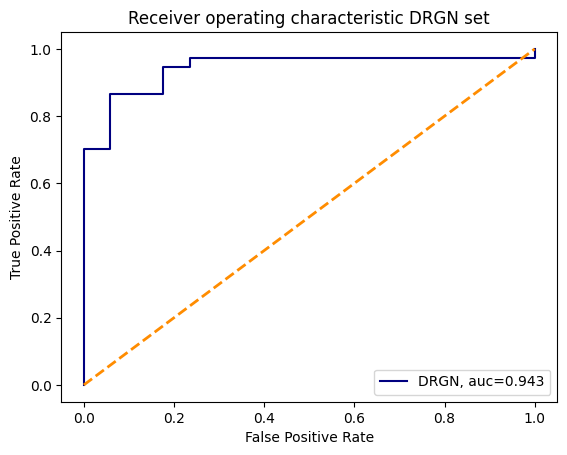

In [ ]:
lw = 2
import matplotlib
matplotlib.rc_file_defaults()
fpr, tpr, _ = metrics.roc_curve(y_drgn[:len(predictions_drgn)],  flat_list)
auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn)], flat_list)
plt.plot(fpr,tpr,color="navy",label="DRGN, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic DRGN set")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

Deleterious mutations in dataset:  21
Benign mutations in dataset:  16
torch.Size([37, 2200])
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        16
           1       0.82      0.67      0.74        21

    accuracy                           0.73        37
   macro avg       0.74      0.74      0.73        37
weighted avg       0.75      0.73      0.73        37

14 13 3 7
Sensitivity: 66.67
Specificity: 81.25
0.47633970000822057


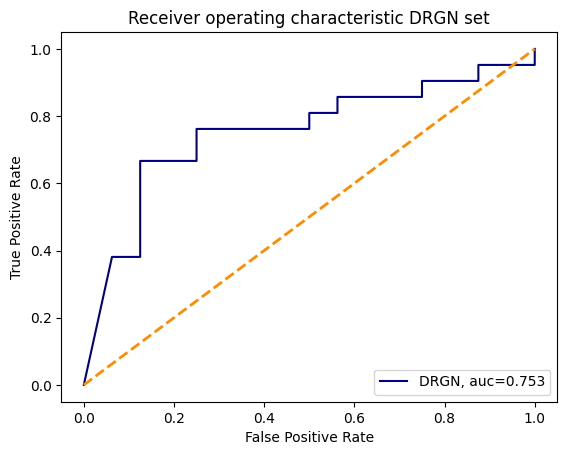

In [ ]:
# germline
dif_mut_drgn = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_balanced_germline_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
# exclude duplicates
dif_mut_drgn.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

dif_mut_drgn_temp = dif_mut_drgn.mutation.str.split(pat='_',expand=True)
labels_drgn = dif_mut_drgn['label'].tolist()
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(y_test_pred)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())
        #print(predictions_drgn)

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

predictions_drgn = [1 if i>=0.5 else 0 for i in flat_list]
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn))
tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn).ravel()
print(classification_report(y_drgn, predictions_drgn))
print(tp, tn, fp, fn)
TPR =tp / (tp + fn)
print('Sensitivity: %.2f'  % (TPR*100))

TNR = tn / (tn + fp)
print('Specificity: %.2f'  % (TNR*100))
print(matthews_corrcoef(y_drgn, predictions_drgn))


lw = 2
import matplotlib
matplotlib.rc_file_defaults()
fpr, tpr, _ = metrics.roc_curve(y_drgn[:len(predictions_drgn)],  flat_list)
auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn)], flat_list)
plt.plot(fpr,tpr,color="navy",label="DRGN, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic DRGN set")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

no conflicts

In [ ]:
h = 4096
hidden2=2048

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Classifier2L(h, hidden2, 0.3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/my_colab/3rdYear/GMM/model'))
model.eval()

Classifier2L(
  (batchnorm1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_1): Linear(in_features=2200, out_features=4096, bias=True)
  (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
  (layer_3): Linear(in_features=2048, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)

without excluding mutations present in training set

Deleterious mutations in dataset:  111
Benign mutations in dataset:  18
torch.Size([129, 2200])
              precision    recall  f1-score   support

           0       0.40      0.89      0.55        18
           1       0.98      0.78      0.87       111

    accuracy                           0.80       129
   macro avg       0.69      0.84      0.71       129
weighted avg       0.90      0.80      0.83       129

87 16 2 24
Sensitivity: 78.38
Specificity: 88.89
0.5039373266922467


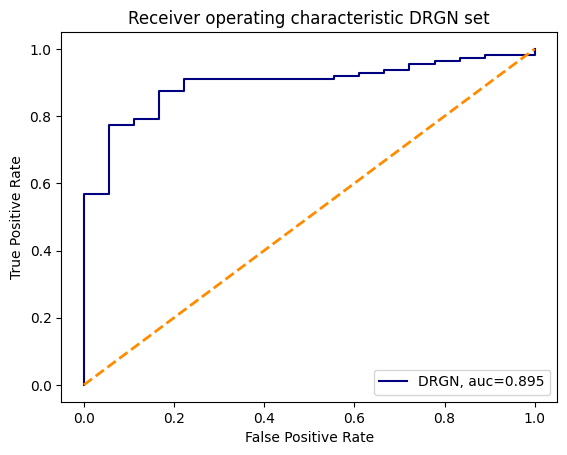

In [ ]:
# somatic
dif_mut_drgn_somatic = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_balanced_somatic_noconflicts2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn_somatic['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn_somatic['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn_somatic[dif_mut_drgn_somatic['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn_somatic[dif_mut_drgn_somatic['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn_somatic.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn_somatic['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn_somatic.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

dif_mut_drgn_temp = dif_mut_drgn_somatic.mutation.str.split(pat='_',expand=True)
labels_drgn = dif_mut_drgn_somatic['label'].tolist()
X_drgn, y_drgn_somatic = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn_somatic).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#y_pred_list = []
predictions_drgn_somatic= []
with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(y_test_pred)
        predictions_drgn_somatic.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())
        #print(predictions_drgn)

flat_list_somatic = []
for sublist in predictions_drgn_somatic:
    for item in sublist:
        flat_list_somatic.append(item)

predictions_drgn_somatic = [1 if i>=0.5 else 0 for i in flat_list_somatic]
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_somatic, predictions_drgn_somatic))
tn, fp, fn, tp = confusion_matrix(y_drgn_somatic, predictions_drgn_somatic).ravel()
print(classification_report(y_drgn_somatic, predictions_drgn_somatic))
print(tp, tn, fp, fn)
TPR =tp / (tp + fn)
print('Sensitivity: %.2f'  % (TPR*100))
TNR = tn / (tn + fp)
print('Specificity: %.2f'  % (TNR*100))
print(matthews_corrcoef(y_drgn_somatic, predictions_drgn_somatic))

lw = 2
import matplotlib
matplotlib.rc_file_defaults()
fpr_somatic, tpr_somatic, _ = metrics.roc_curve(y_drgn_somatic[:len(predictions_drgn_somatic)],  flat_list_somatic)
auc_somatic = metrics.roc_auc_score(y_drgn_somatic[:len(predictions_drgn_somatic)], flat_list_somatic)
plt.plot(fpr_somatic,tpr_somatic,color="navy",label="DRGN, auc="+str(round(auc_somatic, 3)))
plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic DRGN set")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

Deleterious mutations in dataset:  111
Benign mutations in dataset:  18
torch.Size([129, 2200])
              precision    recall  f1-score   support

           0       0.26      0.83      0.39        18
           1       0.96      0.61      0.75       111

    accuracy                           0.64       129
   macro avg       0.61      0.72      0.57       129
weighted avg       0.86      0.64      0.70       129

68 15 3 43
Sensitivity: 61.26
Specificity: 83.33
0.3106252752772197


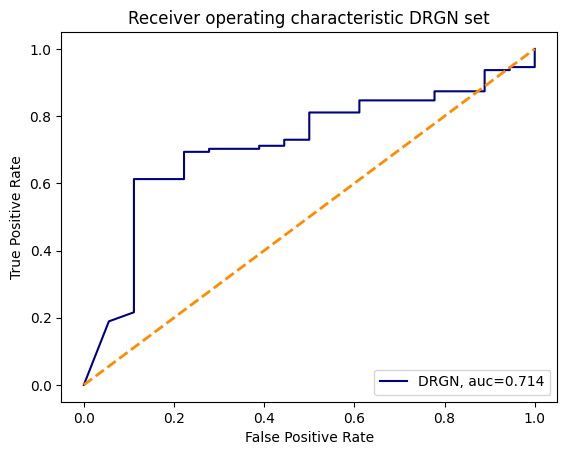

In [ ]:
# germline
dif_mut_drgn_germline = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_balanced_germline_noconflicts2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn_germline['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn_germline['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn_germline[dif_mut_drgn_germline['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn_germline[dif_mut_drgn_germline['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn_germline.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn_germline['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn_germline.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

dif_mut_drgn_temp = dif_mut_drgn_germline.mutation.str.split(pat='_',expand=True)
labels_drgn = dif_mut_drgn_germline['label'].tolist()
X_drgn, y_drgn_germline  = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn_germline).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

predictions_drgn_germline= []
with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        predictions_drgn_germline.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

flat_list_germline = []
for sublist in predictions_drgn_germline:
    for item in sublist:
        flat_list_germline.append(item)

predictions_drgn_germline = [1 if i>=0.5 else 0 for i in flat_list_germline]
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_germline, predictions_drgn_germline))
tn, fp, fn, tp = confusion_matrix(y_drgn_germline, predictions_drgn_germline).ravel()
print(classification_report(y_drgn_germline, predictions_drgn_germline))
print(tp, tn, fp, fn)
TPR =tp / (tp + fn)
print('Sensitivity: %.2f'  % (TPR*100))

TNR = tn / (tn + fp)
print('Specificity: %.2f'  % (TNR*100))
print(matthews_corrcoef(y_drgn_germline, predictions_drgn_germline))


lw = 2
import matplotlib
matplotlib.rc_file_defaults()
fpr, tpr, _ = metrics.roc_curve(y_drgn_germline[:len(predictions_drgn_germline)],  flat_list_germline)
auc = metrics.roc_auc_score(y_drgn_germline[:len(predictions_drgn_germline)], flat_list_germline)
plt.plot(fpr,tpr,color="navy",label="DRGN, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic DRGN set")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

exclude mutations present in training set

In [ ]:
# training set
dif_mut = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_Tier1_2_3_common_balanced+-2_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

# somatic
dif_mut_drgn_somatic = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_balanced_somatic_noconflicts2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

In [ ]:
new_somatic = pd.DataFrame(columns = ['mutation', 'log_difference', 'label'])
count=0
for i in dif_mut_drgn_somatic['mutation'].unique():
  temp = dif_mut_drgn_somatic[dif_mut_drgn_somatic['mutation'] == i]
  temp_test = dif_mut[dif_mut['mutation'] == i]
  if len(temp_test) == 0:
    new_somatic = pd.concat([new_somatic, temp],ignore_index=True, axis=0)
  count+=1

In [ ]:
len(new_somatic)

97

In [ ]:
# germline
dif_mut_drgn_germline = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_balanced_germline_noconflicts2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
new_germline = pd.DataFrame(columns = ['mutation', 'log_difference', 'label'])
count=0
for i in dif_mut_drgn_germline['mutation'].unique():
  temp = dif_mut_drgn_germline[dif_mut_drgn_germline['mutation'] == i]
  temp_test = dif_mut[dif_mut['mutation'] == i]
  if len(temp_test) == 0:
    new_germline = pd.concat([new_germline, temp],ignore_index=True, axis=0)
  count+=1

In [ ]:
len(new_germline)

113

Deleterious mutations in dataset:  81
Benign mutations in dataset:  16
torch.Size([97, 2200])
              precision    recall  f1-score   support

           0       0.45      0.88      0.60        16
           1       0.97      0.79      0.87        81

    accuracy                           0.80        97
   macro avg       0.71      0.83      0.73        97
weighted avg       0.88      0.80      0.83        97

64 14 2 17
Sensitivity: 79.01
Specificity: 87.50
0.5293610101416655


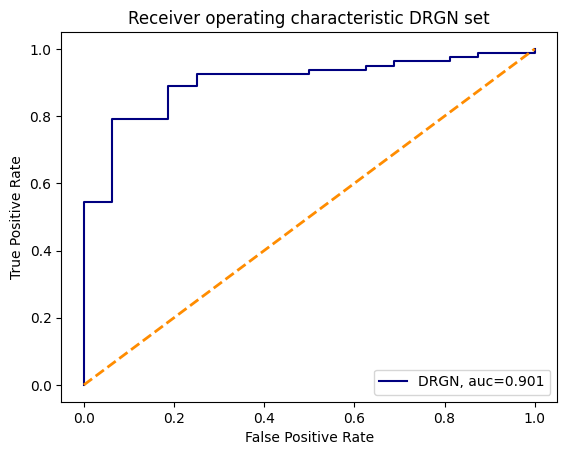

In [ ]:
dif_mut_drgn_somatic = new_somatic

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn_somatic['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn_somatic['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn_somatic[dif_mut_drgn_somatic['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn_somatic[dif_mut_drgn_somatic['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn_somatic.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn_somatic['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn_somatic.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

dif_mut_drgn_temp = dif_mut_drgn_somatic.mutation.str.split(pat='_',expand=True)
labels_drgn = dif_mut_drgn_somatic['label'].tolist()
X_drgn, y_drgn_somatic_excl = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn_somatic_excl).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(y_test_pred)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())
        #print(predictions_drgn)

flat_list_somatic_excl = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list_somatic_excl.append(item)

predictions_drgn_somatic_excl = [1 if i>=0.5 else 0 for i in flat_list_somatic_excl]
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_somatic_excl, predictions_drgn_somatic_excl))
tn, fp, fn, tp = confusion_matrix(y_drgn_somatic_excl, predictions_drgn_somatic_excl).ravel()
print(classification_report(y_drgn_somatic_excl, predictions_drgn_somatic_excl))
print(tp, tn, fp, fn)
TPR =tp / (tp + fn)
print('Sensitivity: %.2f'  % (TPR*100))
TNR = tn / (tn + fp)
print('Specificity: %.2f'  % (TNR*100))
print(matthews_corrcoef(y_drgn_somatic_excl, predictions_drgn_somatic_excl))

lw = 2
import matplotlib
matplotlib.rc_file_defaults()
fpr, tpr, _ = metrics.roc_curve(y_drgn_somatic_excl[:len(predictions_drgn_somatic_excl)],  flat_list_somatic_excl)
auc = metrics.roc_auc_score(y_drgn_somatic_excl[:len(predictions_drgn_somatic_excl)], flat_list_somatic_excl)
plt.plot(fpr,tpr,color="navy",label="DRGN, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic DRGN set")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [ ]:
pos, AA_o, AA_t = [], [], []
test_mutation= dif_mut_drgn_temp[1].tolist()
for i in test_mutation:
  pos.append(i[1:-1])
  AA_o.append(i[0])
  AA_t.append(i[-1])

orig_drgn =AA_o
pos_drgn = pos
targ_drgn = AA_t
prot_drgn = dif_mut_drgn_temp[0].tolist()
incorrect, correct = 0,0
incorrect_mu, incorrect_prot, correct_mu, correct_prot, correct_lab, incorrect_lab, incorrect_pre, cont_lab_inc, cont_lab_c, repres_inc, repres_c, temp_pos_inc, \
temp_targ_inc, temp_orig_inc, temp_pos_c, temp_targ_c, temp_orig_c, temp_len_c, temp_len_inc = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

for ind, pre in enumerate(predictions_drgn):
  if labels_drgn[ind] != pre:
    incorrect_prot.append(prot_drgn[ind])
    temp_pos_inc.append(pos_drgn[ind])
    temp_targ_inc.append(targ_drgn[ind])
    temp_orig_inc.append(orig_drgn[ind])
    incorrect += 1
    incorrect_lab.append(labels_drgn[ind])
    incorrect_pre.append(pre)
    cont_lab_inc.append(flat_list[ind]) # append the continuous values for comparison with EVE predictor
    repres_inc.append(X_drgn[ind])

  else:
    correct +=1
    correct_prot.append(prot_drgn[ind])
    temp_pos_c.append(pos_drgn[ind])
    temp_targ_c.append(targ_drgn[ind])
    temp_orig_c.append(orig_drgn[ind])
    correct_lab.append(labels_drgn[ind] )
    cont_lab_c.append(flat_list[ind]) # append the continuous values for comparison with EVE predictor
    repres_c.append(X_drgn[ind])

df_incorrect_somatic = pd.DataFrame(list(zip(incorrect_prot, incorrect_lab, incorrect_pre , cont_lab_inc, temp_pos_inc, temp_orig_inc, temp_targ_inc)),#temp_len_inc)),
               columns =['Protein', 'Ground Truth', 'Prediction', 'Continuous prediction', 'Position', 'Original', 'Target'])#, 'Length'])
df_correct_somatic = pd.DataFrame(list(zip(correct_prot, correct_lab, cont_lab_c, temp_pos_c ,temp_orig_c, temp_targ_c)),# temp_len_c)),
               columns =['Protein', 'Ground Truth','Continuous prediction', 'Position', 'Original', 'Target'])#, 'Length'])

In [ ]:
group1 = np.random.normal(loc=0, scale=1, size=100)
group2 = np.random.normal(loc=2, scale=1, size=100)
data = np.concatenate([group1, group2])

In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity

# Generate example data
group1 = np.random.multivariate_normal(mean=[0, 1], cov=[[1, 0.5], [0.5, 1]], size=100)
group2 = np.random.multivariate_normal(mean=[6, 9], cov=[[1, 0.5], [0.5, 1]], size=100)

# Fit a Gaussian kernel density estimator to each group
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(group1)
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(group2)


# Calculate the probability of a point belonging to each group
point = np.array([6, 9])
prob_group1 = np.exp(kde1.score_samples(point.reshape(1, -1)))
prob_group2 = np.exp(kde2.score_samples(point.reshape(1, -1)))


print(f"Probability of point {point} belonging to group 1: {prob_group1}")
print(f"Probability of point {point} belonging to group 2: {prob_group2}")

Probability of point [6 9] belonging to group 1: [1.50310518e-40]
Probability of point [6 9] belonging to group 2: [0.14428885]


Deleterious mutations in dataset:  102
Benign mutations in dataset:  11
torch.Size([113, 2200])
              precision    recall  f1-score   support

           0       0.16      0.73      0.27        11
           1       0.95      0.60      0.73       102

    accuracy                           0.61       113
   macro avg       0.56      0.66      0.50       113
weighted avg       0.88      0.61      0.69       113

61 8 3 41
Sensitivity: 59.80
Specificity: 72.73
0.1945845744818609


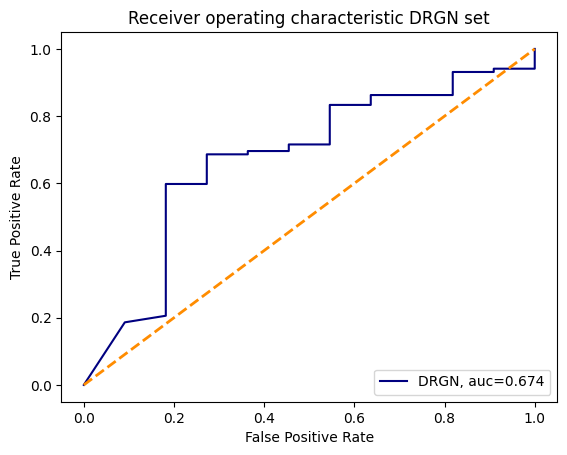

In [ ]:
dif_mut_drgn = new_germline

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

dif_mut_drgn_temp = dif_mut_drgn.mutation.str.split(pat='_',expand=True)
labels_drgn = dif_mut_drgn['label'].tolist()
X_drgn, y_drgn_germline_excl = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn_germline_excl).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

predictions_drgn= []
with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

flat_list_germline_excl = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list_germline_excl.append(item)

predictions_drgn_germline_excl = [1 if i>=0.5 else 0 for i in flat_list_germline_excl]
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_germline_excl, predictions_drgn_germline_excl))
tn, fp, fn, tp = confusion_matrix(y_drgn_germline_excl, predictions_drgn_germline_excl).ravel()
print(classification_report(y_drgn_germline_excl, predictions_drgn_germline_excl))
print(tp, tn, fp, fn)
TPR =tp / (tp + fn)
print('Sensitivity: %.2f'  % (TPR*100))

TNR = tn / (tn + fp)
print('Specificity: %.2f'  % (TNR*100))
print(matthews_corrcoef(y_drgn_germline_excl, predictions_drgn_germline_excl))


lw = 2
import matplotlib
matplotlib.rc_file_defaults()
fpr, tpr, _ = metrics.roc_curve(y_drgn_germline_excl[:len(predictions_drgn_germline_excl)],  flat_list_germline_excl)
auc = metrics.roc_auc_score(y_drgn_germline_excl[:len(predictions_drgn_germline_excl)], flat_list_germline_excl)
plt.plot(fpr,tpr,color="navy",label="DRGN, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic DRGN set")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

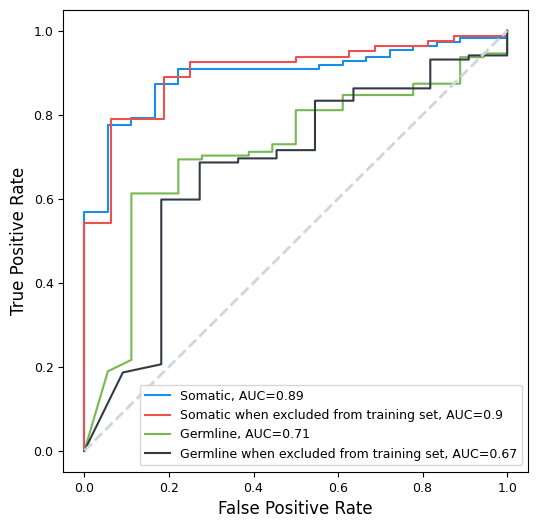

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
matplotlib.rcParams.update({'font.size': 9})

fpr_somatic, tpr_somatic, _ = metrics.roc_curve(y_drgn_somatic[:len(predictions_drgn_somatic)],  flat_list_somatic)
auc_somatic = metrics.roc_auc_score(y_drgn_somatic[:len(predictions_drgn_somatic)], flat_list_somatic)
plt.plot(fpr_somatic,tpr_somatic,color="#168eea",label="Somatic, AUC="+str(round(auc_somatic, 2)))

fpr_somatic_excl, tpr_somatic_excl, _ = metrics.roc_curve(y_drgn_somatic_excl[:len(predictions_drgn_somatic_excl)],  flat_list_somatic_excl)
auc_somatic_excl = metrics.roc_auc_score(y_drgn_somatic_excl[:len(predictions_drgn_somatic_excl)], flat_list_somatic_excl)
plt.plot(fpr_somatic_excl,tpr_somatic_excl,color="#ee4f4f",label="Somatic when excluded from training set, AUC="+str(round(auc_somatic_excl, 2)))

fpr_germline, tpr_germline, _ = metrics.roc_curve(y_drgn_germline[:len(predictions_drgn_germline)],  flat_list_germline)
auc_germline = metrics.roc_auc_score(y_drgn_germline[:len(predictions_drgn_germline)], flat_list_germline)
plt.plot(fpr_germline,tpr_germline,color="#76b852",label="Germline, AUC="+str(round(auc_germline, 2)))

fpr_germline_excl, tpr_germline_excl, _ = metrics.roc_curve(y_drgn_germline_excl[:len(predictions_drgn_germline_excl)],  flat_list_germline_excl)
auc_germline_excl = metrics.roc_auc_score(y_drgn_germline_excl[:len(predictions_drgn_germline_excl)], flat_list_germline_excl)
plt.plot(fpr_germline_excl,tpr_germline_excl,color="#323b43",label="Germline when excluded from training set, AUC="+str(round(auc_germline_excl, 2)))

plt.plot([0, 1], [0, 1], color="#ced7df", lw=lw, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate",fontsize=12)
#plt.title("Receiver operating characteristic DRGN set")
plt.show()

In [ ]:
pos, AA_o, AA_t = [], [], []
test_mutation= dif_mut_drgn_temp[1].tolist()
for i in test_mutation:
  pos.append(i[1:-1])
  AA_o.append(i[0])
  AA_t.append(i[-1])

orig_drgn =AA_o
pos_drgn = pos
targ_drgn = AA_t
prot_drgn = dif_mut_drgn_temp[0].tolist()
incorrect, correct = 0,0
incorrect_mu, incorrect_prot, correct_mu, correct_prot, correct_lab, incorrect_lab, incorrect_pre, cont_lab_inc, cont_lab_c, repres_inc, repres_c, temp_pos_inc, \
temp_targ_inc, temp_orig_inc, temp_pos_c, temp_targ_c, temp_orig_c, temp_len_c, temp_len_inc = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

for ind, pre in enumerate(predictions_drgn):
  if labels_drgn[ind] != pre:

    incorrect_prot.append(prot_drgn[ind])
    temp_pos_inc.append(pos_drgn[ind])
    temp_targ_inc.append(targ_drgn[ind])
    temp_orig_inc.append(orig_drgn[ind])
    incorrect += 1
    incorrect_lab.append(labels_drgn[ind])
    incorrect_pre.append(pre)
    cont_lab_inc.append(flat_list[ind]) # append the continuous values for comparison with EVE predictor
    repres_inc.append(X_drgn[ind])

  else:
    correct +=1
    correct_prot.append(prot_drgn[ind])
    temp_pos_c.append(pos_drgn[ind])
    temp_targ_c.append(targ_drgn[ind])
    temp_orig_c.append(orig_drgn[ind])
    correct_lab.append(labels_drgn[ind] )
    cont_lab_c.append(flat_list[ind]) # append the continuous values for comparison with EVE predictor
    repres_c.append(X_drgn[ind])

df_incorrect_germline = pd.DataFrame(list(zip(incorrect_prot, incorrect_lab, incorrect_pre , cont_lab_inc, temp_pos_inc, temp_orig_inc, temp_targ_inc)),#temp_len_inc)),
               columns =['Protein', 'Ground Truth', 'Prediction', 'Continuous prediction', 'Position', 'Original', 'Target'])#, 'Length'])
df_correct_germline = pd.DataFrame(list(zip(correct_prot, correct_lab, cont_lab_c, temp_pos_c ,temp_orig_c, temp_targ_c)),# temp_len_c)),
               columns =['Protein', 'Ground Truth','Continuous prediction', 'Position', 'Original', 'Target'])#, 'Length'])

how many of somatic are in training set


In [ ]:
# import difference for each mutation + labels
dif_mut = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_Tier1_2_3_common_balanced+-2_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

In [ ]:
somatic_mutations = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_balanced_somatic_noconflicts2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
somatic_mutations.drop_duplicates(subset = 'mutation', inplace =True)
test_somatic = somatic_mutations['mutation'].unique()
dif_mut_test_somatic = dif_mut['mutation'].unique()

shared_elements = set(test_somatic) & set(dif_mut_test_somatic)
print(len(shared_elements))
shared_elements = list(shared_elements)

31


In [ ]:
# how many of the shared are in the correct one
count_correct =0
corr_list = []
for i in shared_elements:
  prot = i.split('_')[0]
  temp = df_correct_somatic[df_correct_somatic['Protein'] == prot]
  for j, temp_temp in temp.iterrows():
    string_temp = temp_temp['Protein'] + '_' + temp_temp['Original']+  temp_temp['Position']+  temp_temp['Target']
    if string_temp == i:
      count_correct +=1
      corr_list.append(string_temp)

In [ ]:
print(count_correct)

24


In [ ]:
# how many of the shared are in the incorrect one
count_incorrect =0
incorr_list = []
for i in shared_elements:
  prot = i.split('_')[0]
  temp = df_incorrect_somatic[df_incorrect_somatic['Protein'] == prot]
  for j, temp_temp in temp.iterrows():
    string_temp = temp_temp['Protein'] + '_' + temp_temp['Original']+  temp_temp['Position']+  temp_temp['Target']
    if string_temp == i:
      count_incorrect +=1
      incorr_list.append(string_temp)

In [ ]:
print(count_incorrect)

7


how many of germline are in training set

In [ ]:
germline_mutations = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_balanced_germline_noconflicts2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
germline_mutations.drop_duplicates(subset = 'mutation', inplace =True)
test_germline = germline_mutations['mutation'].unique()
dif_mut_test_germline = dif_mut['mutation'].unique()

shared_elements = set(test_germline) & set(dif_mut_test_germline)
print(len(shared_elements))
shared_elements = list(shared_elements)

16


In [ ]:
# how many of the shared are in the correct one
count_correct =0
corr_list = []
for i in shared_elements:
  prot = i.split('_')[0]
  temp = df_correct_germline[df_correct_germline['Protein'] == prot]
  for j, temp_temp in temp.iterrows():
    string_temp = temp_temp['Protein'] + '_' + temp_temp['Original']+  temp_temp['Position']+  temp_temp['Target']
    if string_temp == i:
      count_correct +=1
      corr_list.append(string_temp)

In [ ]:
print(count_correct)

14


In [ ]:
# how many of the shared are in the incorrect one
count_incorrect =0
incorr_list = []
for i in shared_elements:
  prot = i.split('_')[0]
  temp = df_incorrect_germline[df_incorrect_germline['Protein'] == prot]
  for j, temp_temp in temp.iterrows():
    string_temp = temp_temp['Protein'] + '_' + temp_temp['Original']+  temp_temp['Position']+  temp_temp['Target']
    if string_temp == i:
      count_incorrect +=1
      incorr_list.append(string_temp)
print(count_incorrect)

2


# ClinVar: TP53, PTEN, MSH2, BRAF

### input TP53 Clinvar expert panel and multiple submitters annotations, check if mutation iscorerct and check if D2D prediction is correct

In [ ]:
import pandas as pd

tp53_clinvar = pd.read_csv('TP53_expert_multiple_single_submitters.txt', delimiter='\t', usecols=['Name', 'Gene(s)', 'Condition(s)' ,'Protein change', 'Clinical significance (Last reviewed)'])
tp53_clinvar['label'] = tp53_clinvar['Clinical significance (Last reviewed)'].apply(clean_labels)
tp53_clinvar['condition'] = tp53_clinvar['Condition(s)'].apply(cancer_labels)

tp53_predictions = pd.read_csv('P04637_all_results2.csv')

FileNotFoundError: ignored

In [ ]:
def clean_labels(val):
    if 'Likely benign' in val:
        return 'likely benign'
    elif 'Benign' in val:
        return 'benign'
    elif 'Likely pathogenic' in val:
        return 'likely pathogenic'
    elif 'Pathogenic' in val:
        return 'pathogenic'
    else:
        return 'VUS'

def cancer_labels(val):
    if 'cancer' in val:
        return 'cancer'
    else:
        return 'non_canceric'

In [ ]:
def AAconvert(AminoAcid):

  aa = {
      'Ala' : 'A',
      'Arg' : 'R',
      'Asn' : 'N',
      'Asp' : 'D',
      'Cys' : 'C',
      'Glu' : 'E',
      'Gln' : 'Q',
      'Gly' : 'G',
      'His' : 'H',
      'Ile' : 'I',
      'Leu' : 'L',
      'Lys' : 'K',
      'Met' : 'M',
      'Phe' : 'F',
      'Pro' : 'P',
      'Ser' : 'S',
      'Thr' : 'T',
      'Trp' : 'W',
      'Tyr' : 'Y',
      'Val' : 'V',
      'Ter' : '*'

  }
  return aa[AminoAcid]

def d2d_performance_vs_clinvar_correct(d2d_predictions, clinvar_file, cancer_flag=False):
  if cancer_flag == True:
    clinvar_file = clinvar_file[clinvar_file['condition']=='cancer']
  d2d_predictions['conc_mutation'] = d2d_predictions['AA_orig'] + d2d_predictions['position'].astype(str) + d2d_predictions['AA_targ']
  correct, incorrect, vus_nb, count_mutations = 0,0,0,0
  incorrect_mutation, correct_mutation = [], []
  for i, mut in clinvar_file.iterrows():
    mutations = mut['Name'].split('(p.')[1][:-1]
    mutation= AAconvert(mutations[:3])+ mutations[3:-3]+ AAconvert(mutations[-3:])
    temp = d2d_predictions[d2d_predictions['conc_mutation'] == mutation]
    if len(temp) >0:
      count_mutations+=1
      #if (mut['label'] == 'benign' and float(temp['D2D_prediction']) <0.5) or (mut['label'] == 'pathogenic' and float(temp['D2D_prediction']) >=0.5) :
      if ('benign' in mut['label']and float(temp['D2D_prediction']) <0.5) or ('pathogenic' in mut['label'] and float(temp['D2D_prediction']) >=0.5) :
        correct+=1
        correct_mutation.append([mut['label'],temp['conc_mutation'].values[0]])
      elif (mut['label'] == 'pathogenic' and float(temp['D2D_prediction']) <0.5) or (mut['label'] == 'benign' and float(temp['D2D_prediction']) >=0.5):
        incorrect+=1
        incorrect_mutation.append([mut['label'],temp['conc_mutation'].values[0]])
      else:
        vus_nb+=1
  return correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation

In [ ]:
'''def d2d_performance_vs_clinvar(d2d_predictions, clinvar_file, cancer_flag=False):
  if cancer_flag == True:
    clinvar_file = clinvar_file[clinvar_file['condition']=='cancer']
  d2d_predictions['conc_mutation'] = d2d_predictions['AA_orig'] + d2d_predictions['position'].astype(str) + d2d_predictions['AA_targ']
  correct, incorrect, vus_nb, count_mutations = 0,0,0,0
  incorrect_mutation, correct_mutation = [], []
  for i, mut in clinvar_file.iterrows():
    mutations = mut['Protein change'].split(', ')
    for mutation in mutations:
      temp = d2d_predictions[d2d_predictions['conc_mutation'] == mutation]
      if len(temp) >0:
        count_mutations+=1
        if (mut['label'] == 'benign' and float(temp['D2D_prediction']) <0.5) or (mut['label'] == 'pathogenic' and float(temp['D2D_prediction']) >=0.5) :
          correct+=1
          correct_mutation.append([mut['label'],temp['conc_mutation'].values[0]])
        elif (mut['label'] == 'pathogenic' and float(temp['D2D_prediction']) <0.5) or (mut['label'] == 'benign' and float(temp['D2D_prediction']) >=0.5):
          incorrect+=1
          incorrect_mutation.append([mut['label'],temp['conc_mutation'].values[0]])
        else:
          vus_nb+=1
  return correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation
'''

In [ ]:
correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation = d2d_performance_vs_clinvar_correct(tp53_predictions,tp53_clinvar, False)

print(f'Correct labels for TP53: {correct} out of {count_mutations-vus_nb} with known significance. Accuracy: {round(correct / (count_mutations-vus_nb),3)}')
print('--------------------------')
print('Inorrect labels for TP53: ', incorrect)
print('--------------------------')
print(f'VUS labels for TP53: {vus_nb}, VUS percentage in gene annotations {round(vus_nb/count_mutations,3)}')

Correct labels for TP53: 251 out of 262 with known significance. Accuracy: 0.958
--------------------------
Inorrect labels for TP53:  11
--------------------------
VUS labels for TP53: 645, VUS percentage in gene annotations 0.711


In [ ]:
def d2d_performance_vs_clinvar_labels_correct(d2d_predictions, clinvar_file, cancer_flag=False):
  if cancer_flag == True:
    clinvar_file = clinvar_file[clinvar_file['condition']=='cancer']
  d2d_predictions['conc_mutation'] = d2d_predictions['AA_orig'] + d2d_predictions['position'].astype(str) + d2d_predictions['AA_targ']

  correct, incorrect, vus_nb, count_mutations = 0,0,0,0
  incorrect_mutation, correct_mutation = [], []
  clinvar_file = clinvar_file[clinvar_file['Protein change'].notna()]
  predictions_clinvar_labels = pd.DataFrame(columns =  ["uniprot id", "WT_sequence","mut_sequence", "AA_orig", "position", "AA_targ", "D2D_prediction", "conc_mutation","lab_clinvar"])

  for i, mut in clinvar_file.iterrows():
    mutations = mut['Name'].split('(p.')[1][:-1]
    mutation= AAconvert(mutations[:3])+ mutations[3:-3]+ AAconvert(mutations[-3:])

    temp = d2d_predictions[d2d_predictions['conc_mutation'] == mutation]

    if len(temp) >0:
      count_mutations+=1
      if (mut['label'] == 'benign' and float(temp['D2D_prediction']) <0.5) or (mut['label'] == 'likely benign' and float(temp['D2D_prediction']) <0.5)  or (mut['label'] == 'pathogenic' and float(temp['D2D_prediction']) >=0.5) or (mut['label'] == 'likely pathogenic' and float(temp['D2D_prediction']) >=0.5):
        correct+=1
        correct_mutation.append([mut['label'],temp['conc_mutation'].values[0]])
        temp['lab_clinvar'] = mut['label']
        temp['condition'] = str(mut['condition'])
        predictions_clinvar_labels = predictions_clinvar_labels.append(temp)
      elif (mut['label'] == 'pathogenic' and float(temp['D2D_prediction']) <0.5) or (mut['label'] == 'likely pathogenic' and float(temp['D2D_prediction']) <0.5) or  (mut['label'] == 'benign' and float(temp['D2D_prediction']) >=0.5) or (mut['label'] == 'likely benign' and float(temp['D2D_prediction']) >=0.5):
        incorrect+=1
        incorrect_mutation.append([mut['label'],temp['conc_mutation'].values[0]])
        temp['condition'] = str(mut['condition'])
        temp['lab_clinvar'] = mut['label']
        predictions_clinvar_labels = predictions_clinvar_labels.append(temp)
      elif mut['label'] == 'VUS' and float(temp['D2D_prediction'] < 0.5):
        temp['lab_clinvar'] = ['VUS, D2D benign']
        temp['condition'] = str(mut['condition'])
        vus_nb+=1
        temp['condition'] = str(mut['condition'])
        predictions_clinvar_labels = predictions_clinvar_labels.append(temp)
      elif mut['label'] == 'VUS' and float(temp['D2D_prediction'] >= 0.5):
        temp['lab_clinvar'] = ['VUS, D2D deleterious']
        temp['condition'] = str(mut['condition'])
        vus_nb+=1
        predictions_clinvar_labels = predictions_clinvar_labels.append(temp)
    else:
      pass # another reference genome

  return correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation, predictions_clinvar_labels

In [ ]:
braf_clinvar = pd.read_csv('BRAF_expert_multiple_single_submitters.txt',  delimiter = '\t', usecols=['Name', 'Gene(s)', 'Condition(s)' ,'Protein change', 'Clinical significance (Last reviewed)'])
braf_clinvar['label'] = braf_clinvar['Clinical significance (Last reviewed)'].apply(clean_labels)
braf_clinvar['condition'] = braf_clinvar['Condition(s)'].apply(cancer_labels)

braf_predictions = pd.read_csv('P15056_all_results.csv', sep=',')

correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation  = d2d_performance_vs_clinvar_correct(braf_predictions,braf_clinvar, False)

print(f'Correct labels for BRAF: {correct} out of {count_mutations-vus_nb} with known significance. Accuracy: {round(correct / (count_mutations-vus_nb),3)}')
print('--------------------------')
print('Inorrect labels for BRAF: ', incorrect)
print('--------------------------')
print(f'VUS labels for BRAF: {vus_nb}, VUS percentage in gene annotations {round(vus_nb/count_mutations,3)}')

Correct labels for BRAF: 98 out of 103 with known significance. Accuracy: 0.951
--------------------------
Inorrect labels for BRAF:  5
--------------------------
VUS labels for BRAF: 249, VUS percentage in gene annotations 0.707


In [ ]:
ar_clinvar = pd.read_csv('AR_expert_multiple_single_submitters.txt', delimiter = '\t', usecols=['Name', 'Gene(s)', 'Condition(s)' ,'Protein change', 'Clinical significance (Last reviewed)'])
ar_clinvar['label'] = ar_clinvar['Clinical significance (Last reviewed)'].apply(clean_labels)
ar_clinvar['condition'] = ar_clinvar['Condition(s)'].apply(cancer_labels)

ar_predictions = pd.read_csv('AR_d2d_results.csv', sep=',')

# for converting d2d_results to d2d_performance_vs_clinvar format
temp = ar_predictions.mutation.str.split(pat='_',expand=True)[0]
ar_predictions['uniprot id'] = temp
temp = ar_predictions.mutation.str.split(pat='_',expand=True)[1]
ar_predictions= ar_predictions.drop('mutation', axis=1)
ar_predictions['mutation']= temp
ar_predictions['AA_orig'] = ar_predictions['mutation'].str[:1]
ar_predictions['AA_targ'] = ar_predictions['mutation'].str[-1:]
ar_predictions['position'] = ar_predictions['mutation'].str[1:-1]
# drop original column
ar_predictions = ar_predictions.drop('mutation', axis=1)
ar_predictions = ar_predictions.rename(columns={"prediction": "D2D_prediction"})

correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation  = d2d_performance_vs_clinvar_correct(ar_predictions,ar_clinvar, False)

print(f'Correct labels for BRAF: {correct} out of {count_mutations-vus_nb} with known significance. Accuracy: {round(correct / (count_mutations-vus_nb),3)}')
print('--------------------------')
print('Inorrect labels for BRAF: ', incorrect)
print('--------------------------')
print(f'VUS labels for BRAF: {vus_nb}, VUS percentage in gene annotations {round(vus_nb/count_mutations,3)}')

Correct labels for BRAF: 100 out of 110 with known significance. Accuracy: 0.909
--------------------------
Inorrect labels for BRAF:  10
--------------------------
VUS labels for BRAF: 73, VUS percentage in gene annotations 0.399


In [ ]:
chek2_clinvar = pd.read_csv('CHEK2_expert_multiple_single_submitters.txt', delimiter = '\t', usecols=['Name', 'Gene(s)', 'Condition(s)' ,'Protein change', 'Clinical significance (Last reviewed)'])
chek2_clinvar['label'] = chek2_clinvar['Clinical significance (Last reviewed)'].apply(clean_labels)
chek2_clinvar['condition'] = chek2_clinvar['Condition(s)'].apply(cancer_labels)

chek2_predictions = pd.read_csv('CHEK2_d2d_results.csv', sep=',')

# for converting d2d_results to d2d_performance_vs_clinvar format
temp = chek2_predictions.mutation.str.split(pat='_',expand=True)[0]
chek2_predictions['uniprot id'] = temp
temp = chek2_predictions.mutation.str.split(pat='_',expand=True)[1]
chek2_predictions= chek2_predictions.drop('mutation', axis=1)
chek2_predictions['mutation']= temp
chek2_predictions['AA_orig'] = chek2_predictions['mutation'].str[:1]
chek2_predictions['AA_targ'] = chek2_predictions['mutation'].str[-1:]
chek2_predictions['position'] = chek2_predictions['mutation'].str[1:-1]
# drop original column
chek2_predictions = chek2_predictions.drop('mutation', axis=1)
chek2_predictions = chek2_predictions.rename(columns={"prediction": "D2D_prediction"})

correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation  = d2d_performance_vs_clinvar_correct(chek2_predictions,chek2_clinvar, False)

print(f'Correct labels for CHEK2: {correct} out of {count_mutations-vus_nb} with known significance. Accuracy: {round(correct / (count_mutations-vus_nb),3)}')
print('--------------------------')
print('Inorrect labels for CHEK2: ', incorrect)
print('--------------------------')
print(f'VUS labels for CHEK2: {vus_nb}, VUS percentage in gene annotations {round(vus_nb/count_mutations,3)}')

Correct labels for CHEK2: 9 out of 9 with known significance. Accuracy: 1.0
--------------------------
Inorrect labels for CHEK2:  0
--------------------------
VUS labels for CHEK2: 1499, VUS percentage in gene annotations 0.994


In [ ]:
pten_clinvar = pd.read_csv('PTEN_expert_multiple_single_submitters.txt', delimiter = '\t', usecols=['Name', 'Gene(s)', 'Condition(s)' ,'Protein change', 'Clinical significance (Last reviewed)'])
pten_clinvar['label'] = pten_clinvar['Clinical significance (Last reviewed)'].apply(clean_labels)
pten_clinvar['condition'] = pten_clinvar['Condition(s)'].apply(cancer_labels)

pten_predictions = pd.read_csv('PTEN_d2d_results.csv', sep=',')

# for converting d2d_results to d2d_performance_vs_clinvar format
temp = pten_predictions.mutation.str.split(pat='_',expand=True)[0]
pten_predictions['uniprot id'] = temp
temp = pten_predictions.mutation.str.split(pat='_',expand=True)[1]
pten_predictions= pten_predictions.drop('mutation', axis=1)
pten_predictions['mutation']= temp
pten_predictions['AA_orig'] = pten_predictions['mutation'].str[:1]
pten_predictions['AA_targ'] = pten_predictions['mutation'].str[-1:]
pten_predictions['position'] = pten_predictions['mutation'].str[1:-1]
# drop original column
pten_predictions = pten_predictions.drop('mutation', axis=1)
pten_predictions = pten_predictions.rename(columns={"prediction": "D2D_prediction"})

correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation  = d2d_performance_vs_clinvar_correct(pten_predictions,pten_clinvar, False)

print(f'Correct labels for PTEN: {correct} out of {count_mutations-vus_nb} with known significance. Accuracy: {round(correct / (count_mutations-vus_nb),3)}')
print('--------------------------')
print('Inorrect labels for PTEN: ', incorrect)
print('--------------------------')
print(f'VUS labels for PTEN: {vus_nb}, VUS percentage in gene annotations {round(vus_nb/count_mutations,3)}')

Correct labels for PTEN: 143 out of 154 with known significance. Accuracy: 0.929
--------------------------
Inorrect labels for PTEN:  11
--------------------------
VUS labels for PTEN: 607, VUS percentage in gene annotations 0.798


### clinvar vs predictions figures

TP53

In [ ]:
tp53_clinvar = pd.read_csv('TP53_expert_multiple_single_submitters.txt', delimiter = '\t' , usecols=['Name', 'Gene(s)', 'Condition(s)' ,'Protein change', 'Clinical significance (Last reviewed)'])
tp53_clinvar['label'] = tp53_clinvar['Clinical significance (Last reviewed)'].apply(clean_labels)
tp53_clinvar['condition'] = tp53_clinvar['Condition(s)'].apply(cancer_labels)

tp53_predictions = pd.read_csv('/content/drive/MyDrive/TP53_d2d_results2.csv')
#tp53_predictions = tp53_predictions.drop(columns='Unnamed: 0')

# for converting d2d_results to d2d_performance_vs_clinvar format
temp = tp53_predictions.mutation.str.split(pat='_',expand=True)[0]
tp53_predictions['uniprot id'] = temp

temp = tp53_predictions.mutation.str.split(pat='_',expand=True)[1]
tp53_predictions= tp53_predictions.drop('mutation', axis=1)
tp53_predictions['mutation']= temp

tp53_predictions['AA_orig'] = tp53_predictions['mutation'].str[:1]
tp53_predictions['AA_targ'] = tp53_predictions['mutation'].str[-1:]
tp53_predictions['position'] = tp53_predictions['mutation'].str[1:-1]

# drop original column
tp53_predictions = tp53_predictions.drop('mutation', axis=1)
tp53_predictions = tp53_predictions.rename(columns={"prediction": "D2D_prediction"})

correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation, predictions_clinvar_labels = d2d_performance_vs_clinvar_labels_correct(tp53_predictions,tp53_clinvar, True)

Streaming output truncated to the last 5000 lines.
<ipython-input-38-ffce402c5b68>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-ffce402c5b68>:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-38-ffce402c5b68>:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-ffce402c5b68>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFram

In [ ]:
predictions_clinvar_labels['pos'] = pd.to_numeric(predictions_clinvar_labels['position'],errors='coerce')
test = predictions_clinvar_labels.sort_values(by='position', ascending=True)

In [ ]:
fig = px.scatter(test, x='pos', y='D2D_prediction',
                 color =  test['lab_clinvar'],
                 symbol = test['lab_clinvar'],
                 symbol_sequence= ['circle-open', 'circle-open','x','x', 'x', 'x'],
                 color_discrete_sequence = ['#a4c639' ,'#ffce54' ,  '#ffa7b1','#ed5564','blue', '#82AAE3'], opacity = 0.85, width =1300, height =400,  hover_data=['conc_mutation', 'D2D_prediction' ])


# Change the bar mode
fig.update_layout(barmode='group', title="TP53 Gene - cancer related mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

BRAF

In [ ]:
braf_clinvar = pd.read_csv('BRAF_expert_multiple_single_submitters.txt',delimiter = '\t' , usecols=['Name','Gene(s)', 'Condition(s)' ,'Protein change', 'Clinical significance (Last reviewed)'])
braf_clinvar['label'] = braf_clinvar['Clinical significance (Last reviewed)'].apply(clean_labels)
braf_clinvar['condition'] = braf_clinvar['Condition(s)'].apply(cancer_labels)

braf_predictions = pd.read_csv('/content/drive/MyDrive/BRAF_d2d_results.csv')

# for converting d2d_results to d2d_performance_vs_clinvar format
temp = braf_predictions.mutation.str.split(pat='_',expand=True)[0]
braf_predictions['uniprot id'] = temp

temp = braf_predictions.mutation.str.split(pat='_',expand=True)[1]
braf_predictions= braf_predictions.drop('mutation', axis=1)
braf_predictions['mutation']= temp

braf_predictions['AA_orig'] = braf_predictions['mutation'].str[:1]
braf_predictions['AA_targ'] = braf_predictions['mutation'].str[-1:]
braf_predictions['position'] = braf_predictions['mutation'].str[1:-1]

# drop original column
braf_predictions = braf_predictions.drop('mutation', axis=1)
braf_predictions = braf_predictions.rename(columns={"prediction": "D2D_prediction"})

correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation, predictions_clinvar_labels = d2d_performance_vs_clinvar_labels_correct(braf_predictions,braf_clinvar, False)

Streaming output truncated to the last 5000 lines.
<ipython-input-38-ffce402c5b68>:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-38-ffce402c5b68>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-ffce402c5b68>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-ffce402c5b68>:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a

In [ ]:
predictions_clinvar_labels['pos'] = pd.to_numeric(predictions_clinvar_labels['position'],errors='coerce')
test = predictions_clinvar_labels.sort_values(by='position', ascending=True)
fig = px.scatter(test, x='pos', y='D2D_prediction',
                 color =  test['lab_clinvar'],
                 symbol = test['lab_clinvar'],

                 symbol_sequence= ['circle-open','circle-open', 'x','x', 'x', 'x'],
                 #color_discrete_sequence = ['#a4c639','#ffce54' , 'blue', '#FABE8C',  '#ed5564' ,'#82AAE3'], opacity = 0.85, width =1300, height =400,  hover_data=['conc_mutation', 'D2D_prediction' ])
                 color_discrete_sequence = ['#a4c639','#ffce54' ,'#82AAE3' ,  '#ffa7b1',  'blue', '#ed5564'], opacity = 0.85, width =1300, height =400,  hover_data=['conc_mutation', 'D2D_prediction' ])
# Change the bar mode
fig.update_layout(barmode='group', title="BRAF Gene - cancer related mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

AR

In [ ]:
correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation, predictions_clinvar_labels = d2d_performance_vs_clinvar_labels_correct(ar_predictions,ar_clinvar, False)

<ipython-input-38-ffce402c5b68>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-ffce402c5b68>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-ffce402c5b68>:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-38-ffce402c5b68>:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [ ]:
predictions_clinvar_labels['pos'] = pd.to_numeric(predictions_clinvar_labels['position'],errors='coerce')
test = predictions_clinvar_labels.sort_values(by='position', ascending=True)
fig = px.scatter(test, x='pos', y='D2D_prediction',
                 color =  test['lab_clinvar'],
                 symbol = test['lab_clinvar'],

                 symbol_sequence= ['x','x', 'x','circle-open', 'x','circle-open'],
                 #color_discrete_sequence = ['#82AAE3','#a4c639','blue', '#FABE8C', '#ffce54' ,  '#ed5564' ], opacity = 0.85, width =1300, height =400,  hover_data=['conc_mutation', 'D2D_prediction' ])
                 color_discrete_sequence = ['#ffa7b1','#82AAE3','#ed5564', '#ffce54', 'blue' ,  '#a4c639' ], opacity = 0.85, width =1300, height =400,  hover_data=['conc_mutation', 'D2D_prediction' ])

# Change the bar mode
fig.update_layout(barmode='group', title="AR Gene ",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

CHEK2

In [ ]:
correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation, predictions_clinvar_labels = d2d_performance_vs_clinvar_labels_correct(chek2_predictions,chek2_clinvar, False)

Streaming output truncated to the last 5000 lines.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-ffce402c5b68>:41: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-38-ffce402c5b68>:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-ffce402c5b68>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
predictions_clinvar_labels['pos'] = pd.to_numeric(predictions_clinvar_labels['position'],errors='coerce')
test = predictions_clinvar_labels.sort_values(by='position', ascending=True)
fig = px.scatter(test, x='pos', y='D2D_prediction',
                 color =  test['lab_clinvar'],
                 symbol = test['lab_clinvar'],

                 symbol_sequence= ['circle-open','x','circle-open','x' ],
                 color_discrete_sequence = [ '#a4c639' , '#ffa7b1', '#FABE8C', '#82AAE3' ], opacity = 0.85, width =1300, height =400,  hover_data=['conc_mutation', 'D2D_prediction' ])
                 #color_discrete_sequence = ['#82AAE3','#a4c639','blue', '#FABE8C', '#ffce54' ,  '#ed5564' ], opacity = 0.85, width =1300, height =400,  hover_data=['conc_mutation', 'D2D_prediction' ])

# Change the bar mode
fig.update_layout(barmode='group', title="CHEK2 Gene ",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

PTEN

In [ ]:
correct, incorrect, vus_nb, count_mutations, incorrect_mutation, correct_mutation, predictions_clinvar_labels = d2d_performance_vs_clinvar_labels_correct(pten_predictions,pten_clinvar, True)

Streaming output truncated to the last 5000 lines.
<ipython-input-38-ffce402c5b68>:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-ffce402c5b68>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-ffce402c5b68>:41: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-38-ffce402c5b68>:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFram

In [ ]:
predictions_clinvar_labels['pos'] = pd.to_numeric(predictions_clinvar_labels['position'],errors='coerce')
test = predictions_clinvar_labels.sort_values(by='position', ascending=True)
fig = px.scatter(test, x='pos', y='D2D_prediction',
                 color =  test['lab_clinvar'],
                 symbol = test['lab_clinvar'],

                 symbol_sequence= ['circle-open','circle-open','x','x' ],
                 color_discrete_sequence = ['#ffce54', '#a4c639',  '#ffa7b1' , '#ed5564' ], opacity = 0.85, width =1300, height =400,  hover_data=['conc_mutation', 'D2D_prediction' ])
                 #color_discrete_sequence = ['#82AAE3','#a4c639','blue', '#FABE8C', '#ffce54' ,  '#ed5564' ], opacity = 0.85, width =1300, height =400,  hover_data=['conc_mutation', 'D2D_prediction' ])

# Change the bar mode
fig.update_layout(barmode='group', title="PTEN Gene - cancer related mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

### Clinvar single/multiple/panel/expert labels - Predictor comparison

In [ ]:
import pandas as pd
# read clinvar csv containing clinvar labels
#clinvar_5genes = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/5genes_clinvarlabels_D2D_confidence_new.csv')
#clinvar_5genes = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/5genes_clinvarlabels_D2D_confidence_new2.csv')
clinvar_5genes = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/5genes_clinvarlabels_D2D_confidence_all.csv')

In [ ]:
clinvar_5genes = clinvar_5genes[clinvar_5genes['condition'] == 'cancer']

D2Deep

In [ ]:
clinvar_5genes.head()

uniprot id                                        WT_sequence  \
0     P04637  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...   
1     P04637  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...   
2     P04637  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...   
3     P04637  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...   
4     P04637  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...   

                                        mut_sequence AA_orig  position  \
0  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...       D       393   
1  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...       E       388   
2  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...       E       388   
3  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...       E       388   
4  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...       K       386   

  AA_targ  D2D_prediction conc_mutation    lab_clinvar  overall_confidence  \
0       Y          0.0020         D393Y  likely benign             0.22794   
1       D          0.0304         E388D  likely benign             0.23128   
2       A          0.0016         E388A  likely benign             0.23128   
3       Q          0.0135         E388Q  likely benign             0.23128   
4       R          0.0027         K386R  likely benign             0.25810   

   Log_prob     condition  correct_label  log_normalized  clinvar_label  SIFT  \
0    38.603        cancer              1         0.38603              0  0.00   
1    38.436        cancer              1         0.38436              0  0.07   
2    38.436  non_canceric              1         0.38436              0  0.05   
3    38.436        cancer              1         0.38436              0  0.04   
4    37.095        cancer              1         0.37095              0  0.00   

   Polyphen2  EVE  DEOGEN2  FATHMM_cancer  
0      1.000  NaN    0.907          -8.66  
1      0.544  NaN    0.507          -8.30  
2      0.894  NaN    0.715          -8.29  
3      0.997  NaN    0.646          -8.32  
4      0.999  NaN    0.521          -8.64

In [ ]:
clinvar_5genes['uniprot id'].unique()

array(['P04637', 'P15056', 'P60484', 'O96017', 'P10275'], dtype=object)

In [ ]:
def notNaN(num):
    return num == num

In [ ]:
gene_list = clinvar_5genes['uniprot id'].unique().tolist()
#gene_list.remove('P10275') # DEOGEN2 does not contain P10275
#gene_list.remove('O96017') # EVE does not contain O96017

TP, TN, FP, FN=0,0,0,0
TP_weig, TN_weig, FP_weig, FN_weig=0,0,0,0
#for gene in clinvar_5genes['uniprot id'].unique().tolist():
for gene in gene_list:
  clinvar_gene = clinvar_5genes[clinvar_5genes['uniprot id'] == gene]
  for i, mut in clinvar_gene.iterrows():
    if mut['D2D_prediction'] >= 0.5 and mut['clinvar_label'] == 1:
      TP+=1
      TP_weig+=mut['overall_confidence']
    elif mut['D2D_prediction'] < 0.5 and mut['clinvar_label'] == 0:
      TN+=1
      TN_weig+=mut['overall_confidence']
    elif mut['D2D_prediction'] < 0.5 and mut['clinvar_label'] == 1:
      FN+=1
      FN_weig+=mut['overall_confidence']
    else:
      FP+=1
      FP_weig+=mut['overall_confidence']
print('sensitivity', round(TP/(TP+FN),3))
print('specificty', round(TN/(TN+FP),3))
print('Accuracy', round((TP+TN)/ (TN+TP+FN+FP),3))
print(f'Over {TP+TN+FP+FN} clinvar mutations')

# total_weight = clinvar_5genes_noP10275['overall_confidence'].sum()
total_weight = clinvar_5genes['overall_confidence'].sum()
print('sensitivity weig', round(TP_weig/(TP_weig+FN_weig),3))
print('specificty weig', round(TN_weig/(TN_weig+FP_weig),3))
print('Accuracy weig', round((TP_weig+TN_weig)/ (TN_weig+TP_weig+FN_weig+FP_weig),3))

sensitivity 0.853
specificty 0.842
Accuracy 0.851
Over 690 clinvar mutations
sensitivity weig 0.951
specificty weig 0.796
Accuracy weig 0.929


DEOGEN2

In [ ]:
gene_list = clinvar_5genes['uniprot id'].unique().tolist()
#gene_list.remove('P10275') # DEOGEN2 does not contain P10275
#gene_list.remove('O96017') # EVE does not contain O96017

# append results of predictor
results_predictor =[]
TP, TN, FP, FN=0,0,0,0
for gene in gene_list:
  clinvar_gene = clinvar_5genes[clinvar_5genes['uniprot id'] == gene]
  # find deogen file with protein's results
  if gene !=  'P10275':
    gene_variants = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/DEOGEN2/' + gene + '.txt', skiprows=4, delimiter=',')

    for i, mut in clinvar_gene.iterrows():
      mutation = mut['AA_orig'] +  str(mut['position']) + mut['AA_targ']
      deogen_score = gene_variants[gene_variants['mutation'] == mutation]['score'].values[0]
      results_predictor.append(deogen_score)
      if deogen_score > 0.5 and mut['clinvar_label'] == 1:
        TP+=1
      elif deogen_score <= 0.5 and mut['clinvar_label'] == 0:
        TN+=1
      elif deogen_score <= 0.5 and mut['clinvar_label'] == 1:
        FN+=1
      else:
        FP+=1
  else:
    results_predictor.extend([None] * len(clinvar_gene)) # append Na for missing predictions

print('sensitivity', round(TP/(TP+FN),3))
print('specificty',round( TN/(TN+FP),3))
print('Accuracy', round((TP+TN)/ (TN+TP+FN+FP),3) )
print(f'Over {TP+TN+FP+FN} clinvar mutations')

sensitivity 0.996
specificty 0.472
Accuracy 0.883
Over 574 clinvar mutations


In [ ]:
# RUN ONCE
clinvar_5genes['DEOGEN2'] = results_predictor

EVE

In [ ]:
gene_list = clinvar_5genes['uniprot id'].unique().tolist()
#gene_list.remove('P10275') # DEOGEN2 does not contain P10275
#gene_list.remove('O96017') # EVE does not contain O96017

TP, TN, FP, FN=0,0,0,0
# append results of predictor
results_predictor =[]

for gene in gene_list:
  clinvar_gene = clinvar_5genes[clinvar_5genes['uniprot id'] == gene]

  if gene != 'O96017':
    gene_variants = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/EVE/' + gene + '.csv', usecols=['wt_aa', 'position', 'mt_aa','EVE_scores_ASM'])   # find eve file with protein's results
    gene_variants['mutation_conc'] = gene_variants['wt_aa']  + gene_variants['position'].astype(str)+gene_variants['mt_aa']

    for i, mut in clinvar_gene.iterrows():
      mutation = mut['AA_orig'] +  str(mut['position']) + mut['AA_targ']
      if len(gene_variants[gene_variants['mutation_conc'] == mutation]['EVE_scores_ASM']) >0:
        eve_score = gene_variants[gene_variants['mutation_conc'] == mutation]['EVE_scores_ASM'].values[0]
        results_predictor.append(eve_score)
        if eve_score > 0.63 and mut['clinvar_label'] == 1:
          TP+=1
        elif eve_score <= 0.38 and mut['clinvar_label'] == 0:
          TN+=1
        elif eve_score <= 0.38 and mut['clinvar_label'] == 1:
          FN+=1
        elif eve_score > 0.63 and mut['clinvar_label'] == 0:
          FP+=1

  else:
    results_predictor.extend([None] * len(clinvar_gene)) # append Na for missing predictions

print('sensitivity', round(TP/(TP+FN),3))
print('specificty',round( TN/(TN+FP),3))
print('Accuracy', round((TP+TN)/ (TN+TP+FN+FP),3) )
print(f'Over {TP+TN+FP+FN} clinvar mutations')

sensitivity 0.853
specificty 0.941
Accuracy 0.864
Over 516 clinvar mutations


In [ ]:
# RUN ONCE
clinvar_5genes['EVE'] = results_predictor

FATHMM_cancer

In [ ]:
gene_list = clinvar_5genes['uniprot id'].unique().tolist()

TP, TN, FP, FN=0,0,0,0
for gene in gene_list:
  # find deogen file with protein's results
  gene_variants = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/FATHMM_cancer/' + gene + '.txt', delimiter = '\t', usecols=['Substitution', 'Score'])

  clinvar_gene = clinvar_5genes[clinvar_5genes['uniprot id'] == gene]
  for i, mut in clinvar_gene.iterrows():
    mutation = mut['AA_orig'] +  str(mut['position']) + mut['AA_targ']
    if len(gene_variants[gene_variants['Substitution'] == mutation]['Score']) >0:
      fathmm_score = gene_variants[gene_variants['Substitution'] == mutation]['Score'].values[0]
      if fathmm_score <= -0.75 and mut['clinvar_label'] == 1:
        TP+=1
      elif fathmm_score >-0.75 and mut['clinvar_label'] == 0:
        TN+=1
      elif fathmm_score > -0.75  and mut['clinvar_label'] == 1:
        FN+=1
      elif fathmm_score <= -0.75 and mut['clinvar_label'] == 0:
        FP+=1
print('sensitivity', round(TP/(TP+FN),3))
print('specificty',round( TN/(TN+FP),3))
print('Accuracy', round((TP+TN)/ (TN+TP+FN+FP),3) )
print(f'Over {TP+TN+FP+FN} clinvar mutations')

sensitivity 0.939
specificty 0.109
Accuracy 0.758
Over 586 clinvar mutations


SIFT

In [ ]:
gene_list = clinvar_5genes['uniprot id'].unique().tolist()

TP, TN, FP, FN=0,0,0,0
for gene in gene_list:
  clinvar_gene = clinvar_5genes[clinvar_5genes['uniprot id'] == gene]
  for i, mut in clinvar_gene.iterrows():
    if mut['SIFT']  < 0.05 and mut['clinvar_label'] == 1:
      TP+=1
    elif mut['SIFT']  >= 0.05  and mut['clinvar_label'] == 0:
      TN+=1
    elif mut['SIFT']  >= 0.05  and mut['clinvar_label'] == 1:
      FN+=1
    elif mut['SIFT']  < 0.05 and mut['clinvar_label'] == 0:
      FP+=1
print('sensitivity', round(TP/(TP+FN),3))
print('specificty',round( TN/(TN+FP),3))
print('Accuracy', round((TP+TN)/ (TN+TP+FN+FP),3) )
print(f'Over {TP+TN+FP+FN} clinvar mutations')

sensitivity 0.808
specificty 0.669
Accuracy 0.78
Over 690 clinvar mutations


Polyphen2

In [ ]:
gene_list = clinvar_5genes['uniprot id'].unique().tolist()

TP, TN, FP, FN=0,0,0,0
for gene in gene_list:
  clinvar_gene = clinvar_5genes[clinvar_5genes['uniprot id'] == gene]
  for i, mut in clinvar_gene.iterrows():
    if mut['Polyphen2']  >= 0.5 and mut['clinvar_label'] == 1:
      TP+=1
    elif mut['Polyphen2']  < 0.5 and mut['clinvar_label'] == 0:
      TN+=1
    elif mut['Polyphen2']  < 0.5 and mut['clinvar_label'] == 1:
      FN+=1
    elif mut['Polyphen2']  >= 0.5 and mut['clinvar_label'] == 0:
      FP+=1
print('sensitivity', round(TP/(TP+FN),3))
print('specificty',round( TN/(TN+FP),3))
print('Accuracy', round((TP+TN)/ (TN+TP+FN+FP),3) )
print(f'Over {TP+TN+FP+FN} clinvar mutations')

sensitivity 0.93
specificty 0.683
Accuracy 0.877
Over 584 clinvar mutations


In [ ]:
clinvar_5genes.to_csv('5genes_clinvarlabels_all.csv')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

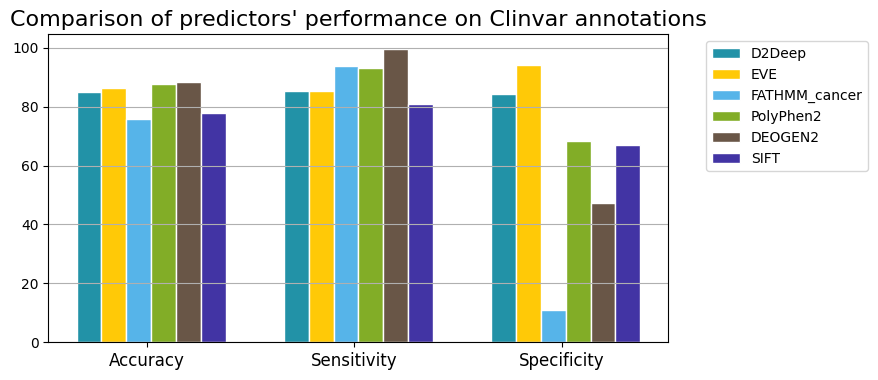

In [ ]:
D2Deep = [85.1, 85.3, 84.2]
EVE = [86.4, 85.3, 94.1]
FATHHM = [75.8, 93.9, 10.9]
PolyPhen2 = [87.7, 93, 68.3]
DEOGEN = [88.3, 99.6, 47.2]
SIFT = [78, 80.8, 66.9]
plt.rcParams["figure.figsize"] = (8,4)
barWidth = 0.12

bars1 = [D2Deep, EVE, FATHHM,PolyPhen2,DEOGEN, SIFT ]
r1 = np.arange(len(D2Deep))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

# Make the plot
plt.bar(r1, D2Deep, color = '#2292a7' , width=barWidth, edgecolor='white', label='D2Deep') #2166ac # ff0000 #334858 # 000000 '#ce1141' '#cd595a' da5a47
plt.bar(r2, EVE, color='#ffc907', width=barWidth, edgecolor='white', label='EVE') # 67a9cf # fbb034 # cd595a # be0027 #eeb111' 8ba753
plt.bar(r3, FATHHM, color='#56B4E9', width=barWidth, edgecolor='white', label='FATHMM_cancer') # d1e5f0 # c1d82f # 94938f # cf8d2e #02a388 #a6192e
plt.bar(r4, PolyPhen2, color='#82ad27', width=barWidth, edgecolor='white', label='PolyPhen2') # CCFFE5 # 007ea3 # dbc5b0 # e4e932 #0087b4
plt.bar(r5, DEOGEN, color='#695647', width=barWidth, edgecolor='white', label='DEOGEN2') # FFCCE5 # 00a4e4 # f8dfc2 # 2c9f45 #5654a4
plt.bar(r6, SIFT, color='#4234a4', width=barWidth, edgecolor='white', label='SIFT') # #4234a4 #ee70a6

# Add xticks on the middle of the group bars
plt.title('Comparison of predictors\' performance on Clinvar annotations',fontname="Calibri", fontsize=16)
plt.xticks([r + barWidth+0.16 for r in range(3)],  ['Accuracy', 'Sensitivity', 'Specificity'], rotation=0,fontname="Calibri", fontsize=12)
#plt.xticks([r + barWidth+0.16 for r in range(2)],  ['Sensitivity', 'Specificity'],fontname="Calibri", fontsize=16)
plt.grid(axis = "y")
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.legend(loc="upper right", fontsize=14)

ROC

<ipython-input-33-6d6335c46aa4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['EVE_inter'] =np.where(condition1, selected_rows['EVE'] - 0.13, selected_rows['EVE'] )
<ipython-input-33-6d6335c46aa4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['EVE_fin'] =np.where(condition2, selected_rows['EVE'] + 0.17, selected_rows['EVE_inter'] )
<ipython-input-33-6d6335c46aa4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

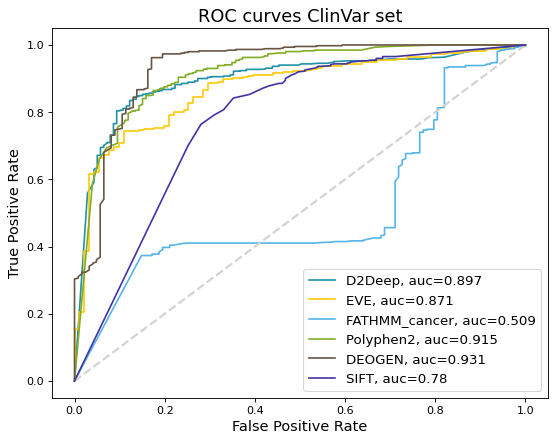

In [ ]:
figure(figsize=(8, 6), dpi=80)
lw=2
#D2D
# keep rows of resutls where D2D has values
selected_rows = clinvar_5genes[~clinvar_5genes['D2D_prediction'].isnull()]
fpr, tpr, _ = metrics.roc_curve(selected_rows['clinvar_label'],  selected_rows['D2D_prediction'])
auc = metrics.roc_auc_score(selected_rows['clinvar_label'], selected_rows['D2D_prediction']) #  probability estimates of the positive class
plt.plot(fpr,tpr,color="#2292a7",label="D2Deep, auc="+str(round(auc, 3))) #da5a47

#EVE
selected_rows = clinvar_5genes[~clinvar_5genes['EVE'].isnull()]
condition1 = (selected_rows['EVE'] >= 0.5) & (selected_rows['EVE'] <= 0.62)
selected_rows['EVE_inter'] =np.where(condition1, selected_rows['EVE'] - 0.13, selected_rows['EVE'] )

condition2 = (selected_rows['EVE'] >= 0.38) & (selected_rows['EVE'] < 0.5)
selected_rows['EVE_fin'] =np.where(condition2, selected_rows['EVE'] + 0.17, selected_rows['EVE_inter'] )

fpr, tpr, _ = metrics.roc_curve(selected_rows['clinvar_label'],  selected_rows['EVE_fin'])
auc = metrics.roc_auc_score(selected_rows['clinvar_label'], selected_rows['EVE_fin'])
plt.plot(fpr,tpr,color="#ffc907",label="EVE, auc="+str(round(auc, 3))) #8ba753

#FATHHM [-10, 10]
selected_rows = clinvar_5genes[~clinvar_5genes['FATHMM_cancer'].isnull()]
selected_rows['FATHMM_pos'] = 1- NormalizeData(selected_rows['FATHMM_cancer'])
condition1 = selected_rows['FATHMM_cancer'] < -0.75
selected_rows['FATHMM_inter'] =np.where(condition1, selected_rows['FATHMM_pos']+0.2, selected_rows['FATHMM_pos'] )
condition1 = selected_rows['FATHMM_cancer']<-9
value = 1
selected_rows['FATHMM_inter'] =np.where(condition1, value, selected_rows['FATHMM_inter'] )

fpr, tpr, _ = metrics.roc_curve(selected_rows['clinvar_label'],  selected_rows['FATHMM_inter']) #+0.75
auc = metrics.roc_auc_score(selected_rows['clinvar_label'], selected_rows['FATHMM_inter']) # +0.75
plt.plot(fpr,tpr,color="#56B4E9",label="FATHMM_cancer, auc="+str(round(auc, 3))) # 00bce4 ##02a388

#Polyphen2
selected_rows = clinvar_5genes[~clinvar_5genes['Polyphen2'].isnull()]
fpr, tpr, _ = metrics.roc_curve(selected_rows['clinvar_label'],  selected_rows['Polyphen2'])
auc = metrics.roc_auc_score(selected_rows['clinvar_label'], selected_rows['Polyphen2'])
plt.plot(fpr,tpr,color="#82ad27",label="Polyphen2, auc="+str(round(auc, 3))) # 00bce4 #0087b4

#DEOGEN2
selected_rows = clinvar_5genes[~clinvar_5genes['DEOGEN2'].isnull()]
fpr, tpr, _ = metrics.roc_curve(selected_rows['clinvar_label'],  selected_rows['DEOGEN2'])
auc = metrics.roc_auc_score(selected_rows['clinvar_label'], selected_rows['DEOGEN2'])
plt.plot(fpr,tpr,color="#695647",label="DEOGEN, auc="+str(round(auc, 3))) # 7d3f98 #5654a4
plt.plot([0, 1], [0, 1], color="lightgray", lw=lw, linestyle="--")

#SIFT [0, 1]
selected_rows = clinvar_5genes[~clinvar_5genes['SIFT'].isnull()]
selected_rows['SIFT_pos'] = 1 - selected_rows['SIFT']
condition1 = selected_rows['SIFT']<=0.05
selected_rows['SIFT_inter'] =np.where(condition1,  1- selected_rows['SIFT'], 1- selected_rows['SIFT'] -0.5 )
condition2 = selected_rows['SIFT_inter']<0
selected_rows['SIFT_values'] =np.where(condition2,  0, selected_rows['SIFT_inter'] )

fpr, tpr, _ = metrics.roc_curve(selected_rows['clinvar_label'], selected_rows['SIFT_values'])
auc = metrics.roc_auc_score(selected_rows['clinvar_label'], selected_rows['SIFT_values'])
plt.plot(fpr,tpr,color="#4234a4",label="SIFT, auc="+str(round(auc, 3))) #ee70a6
plt.legend(loc=4, prop={'size': 12})
plt.xlabel("False Positive Rate", fontname="Calibri",fontsize=13)
plt.ylabel("True Positive Rate", fontname="Calibri",fontsize=13)
plt.title("ROC curves ClinVar set",fontname="Calibri",fontsize=16)
plt.rcParams["figure.figsize"] = (8,8)

plt.show()

combine ClinVar and DRGN AUC metrics

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
x = np.array((0.897, 0.871, 0.509, 0.915, 0.931, 0.78))

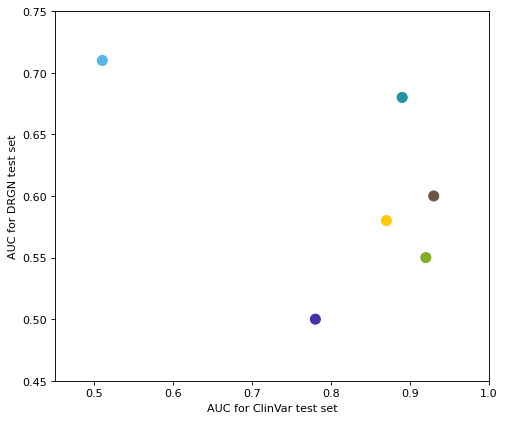

In [ ]:

figure(figsize=(7, 6), dpi=80)

x = np.array((0.89, 0.87, 0.51, 0.92, 0.93, 0.78))
y = np.array((0.68, 0.58, 0.71, 0.55, 0.6, 0.5))
colors = ['#2292a7', '#ffc907', '#56B4E9', '#82ad27', '#695647', '#4234a4']
# plt.scatter(x, y, s=80, facecolors='none', edgecolors=colors) # empty cycles
plt.scatter(x, y, s=80, facecolors=colors)
plt.xlim([0.45,1])
plt.ylim([0.45,0.75])
plt.ylabel('AUC for DRGN test set')
plt.xlabel('AUC for ClinVar test set')
plt.show()

### Test - OUTDATED

In [ ]:
# import difference for each mutation + labels
test = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_tp53brca1msh2pten_2200AA_57_maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

fl_dif = []
for x in test['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

test['fl_dif'] = fl_dif

N= 2200
fl_dif_pad, positions, proteins_temp =[], [], []
for i, mut in test.iterrows():
  mut_temp = mut.mutation.split('_')[1]
  proteins_temp.append(mut.mutation.split('_')[0])
  positions.append(mut_temp[1: -1])
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
test['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in test.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

stacked_drgn = torch.stack(stacked_flat_drgn)
print(stacked_drgn.shape)

torch.Size([8799, 2200])


In [ ]:
tp53 = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/tp53_mut_clinvar_missense_labels_correct.csv')
brca1 =pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/brca1_mut_clinvar_missense_labels_correct.csv')
msh2 = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/msh2_mut_clinvar_missense_labels_correct.csv')
pten = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/pten_mut_clinvar_missense_labels_correct.csv')

all_mut = pd.concat([tp53,brca1, msh2, pten], ignore_index=True)
all_mut = all_mut.reset_index(drop=True)

In [ ]:
del test['label'] # they are not the '_correct'' labels
test['label'] = all_mut['label']

In [ ]:
#test = dif_mut_drgn[dif_mut_drgn['label'] != 'VUS']
lab_num = []
labels_drgn = test['label'].tolist()
for k in labels_drgn:
  if k == 'VUS':
    lab_num.append(-1)
  elif k == 'pathogenic':
    lab_num.append(2)
  elif k == 'Likely pathogenic':
    lab_num.append(1)
  else:
    lab_num.append(0)

labels_drgn = lab_num
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
my_net.eval()

with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = my_net(X_batch)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

In [ ]:
test['pos'] = positions
test['D2D_values'] = flat_list
test['proteins']  = proteins_temp
test['condit'] = all_mut['Condition(s)']
test_tp53 = test[test['proteins'] == 'P04637']
test_tp53 = test[test['proteins'] == 'P04637']
test_tp53.to_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/tp53_D2D.csv', index=False)

In [ ]:
test['pos'] = positions
test['D2D_values'] = flat_list
test['proteins']  = proteins_temp
test['condit'] = all_mut['Condition(s)']
test['pos'] = pd.to_numeric(test['pos'],errors='coerce')
test = test.sort_values(by='pos', ascending=True)

lab =[]
for i, mut in test.iterrows():
  if mut['label'] == 'VUS' and mut['D2D_values'] < 0.5:
    lab.append('VUS, D2D benign')
  elif mut['label'] == 'VUS' and mut['D2D_values'] >= 0.5:
     lab.append('VUS, D2D deleterious')
  else:
    lab.append(mut['label'])
test['label_proc'] = lab

### TP53 - How many Clinvar cancer-related pathogenic it predicts correctly? - OUTDATED

In [ ]:
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R342P'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R337H'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R337C'))]['D2D_values'].values) # INCORRECT - In COSMIC: Tier 3 - SIFT predicts benign (0.01), Clinvar: A study conducted in human cell lines indicates that this alteration is deficient at growth suppression but has no dominant negative effect (Giacomelli AO et al. Nat. Genet. 2018 Oct;50:1381-1387). This variant is considered to be rare based on population cohorts in the Genome Aggregation Database (gnomAD). This amino acid position is well conserved in available vertebrate species.
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('E286K'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('E285V'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('E285K'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R282P'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R282G'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R282W'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('D281V'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('D281G'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('D281N'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('D281Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R280S'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G279E'))]['D2D_values'].values) # INCORRECT - In COSMIC: Tier 3, SIFT: not provided - Clinvar: no functional evidence , uncertain significance in study
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('A276G'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C275F'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C275Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R273L'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R273P'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R273H'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R273G'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R273S'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R273C'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('V272M'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('F270S'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R267W'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G266E'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G266R'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('L265P'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('E258K'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('I254N'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('I251L'))]['D2D_values'].values) # INCORRECT- In COSMIC: Tier 3, SIFT: 0.001, Clinvar: probably has functional consequence. No evidence was found for (p.I251L) TP53 gene variant in stomach cancer so far. However, this variant has been observed in a male patient suffering from carcinoma of the stomach and in addition, this alteration is predicted to be deleterious by in silico analysis. el, has been reported previously in association with Li-Fraumeni syndrome (Wu et al., 2011). Additionally, the NHLBI ESP Exome Variant Server reports I251L was not observed in approximately 6,500 samples from individuals of European and African American backgrounds, indicating it is not a common benign variant in these populations. Therefore, I251L is interpreted as a disease-causing variant.
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R249T'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R248P'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R248L'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R248Q'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R248W'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('M246V'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G245D'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G245V'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G245S'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G245C'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G244A'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G244D'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G244S'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C242Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('S241Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C238W'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C238S'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C238F'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C238Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C238G'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C238R'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('M237I'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('Y234C'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('Y234H'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('I232N'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('Y220C'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('Y220S'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('S215I'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R213P'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R213Q'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('Y205C'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('I195T'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('H193P'))]['D2D_values'].values)

[0.99903154]
[0.88921124]
[0.17788906]
[0.9998666]
[0.99985862]
[0.99870884]
[0.99641955]
[0.999861]
[0.99993801]
[0.99996817]
[0.99991775]
[0.99716598]
[0.99998963]
[0.99992013 0.99992013]
[0.43560258]
[0.99351984]
[0.99902904]
[0.99655461]
[0.9999907]
[0.99999988]
[0.99995697]
[0.99999332]
[0.9998982]
[0.99999154]
[0.93725419]
[0.99999356]
[1.]
[0.9998399]
[0.99581581 0.99581581]
[0.99920815]
[0.99999809]
[0.99811006]
[0.44041809]
[0.99976963]
[1.]
[1.]
[0.99968362]
[1.]
[0.99797946]
[0.99997127]
[0.99977714]
[0.99993634]
[1.]
[0.9764483]
[0.99798298]
[0.99098831]
[0.99970859]
[1.]
[0.99999964]
[0.99928147 0.99928147]
[0.99999547]
[0.99998736]
[0.9999609]
[0.99999845]
[0.99874997 0.99874997]
[0.99998224]
[0.99922025]
[0.9999398]
[0.99650627]
[0.99969327]
[0.99185115]
[1.]
[0.9995752]
[0.97501922]
[0.99649543]
[0.9999944]


In [ ]:
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('H193R'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('H193Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R181P'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R181H'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('H179Q'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('H179Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('P177R'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C176Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R175L'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R175H'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R175G'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('V173A'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('V173L'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('V173M'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('Y163C'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R158L'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R158H'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R158S'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R158G'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('V157A'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('P152R'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('P152L'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('P151R'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('P151A'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('P151S'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('P151T'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C141Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C135R'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('M133T'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('K132R'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('K132E'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('N131I'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('N131Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('L130P'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('S127Y'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('S127P'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('T125R'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('T125K'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R110L'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R110P'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('G105R'))]['D2D_values'].values)

[0.99968672]
[0.99980205]
[0.99919981]
[0.98772848]
[0.9994635 0.9994635]
[0.9853543]
[0.99999988]
[0.99989843]
[0.99988353]
[0.99284911]
[0.99998927]
[0.99998879]
[0.99953437]
[0.99883765]
[0.9995926]
[0.9999994]
[0.99999511]
[0.99998796]
[0.99999833]
[0.99326634]
[0.99979538]
[0.99998248]
[0.99926287]
[0.9985525]
[0.99997401]
[0.99944657]
[0.99980098]
[0.99871671]
[0.9966085]
[0.99892265]
[0.99999022]
[0.99995029]
[0.99894363]
[0.99997926]
[0.94394481]
[0.9909724]
[0.70200831]
[0.94842386]
[0.68323237]
[0.98238927]
[0.65870392]


In [ ]:
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('L35F'))]['D2D_values'].values)

In [ ]:
# Benign
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('C182G'))]['D2D_values'].values) # INCORRECT
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('T312S'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R158H'))]['D2D_values'].values) # INCORRECT - There is a double label in Clinvar for both pathogenic and benign
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('R290H'))]['D2D_values'].values) # INCORRECT - There is a double label in Clinvar for both pathogenic and benign
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('N235S'))]['D2D_values'].values) # INCORRECT
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('V73M'))]['D2D_values'].values) # INCORRECT
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('P72R'))]['D2D_values'].values)
print(test[(test['proteins'] == 'P04637-1') & (test['mutation'].str.contains('P47S'))]['D2D_values'].values)

[0.52071255]
[0.01545629]
[0.99999511]
[0.6706084]
[0.98400879]
[0.73847246]
[0.0018834]
[0.04610837]


### PTEN - OUtDATED ?

In [ ]:
test_cancer = test[test['condit'].str.contains('cancer') | test['condit'].str.contains('Lynch') | test['condit'].str.contains('tumor')]

In [ ]:
tp53=test_cancer[test_cancer['proteins'] == 'P04637']
fig = px.scatter(tp53, x='pos', y='D2D_values',
                 color =  tp53['label_proc'],
                 symbol = tp53['label_proc'],
                 symbol_sequence= ['circle-open','circle-open','x', 'x', 'x', 'x'],
                 color_discrete_sequence = ['green', 'gold', 'lightskyblue', 'blue', 'salmon', 'red'], opacity = 0.55, width =1300, height =400,  hover_data=['mutation', 'D2D_values' ])

# Change the bar mode
fig.update_layout(barmode='group', title="TP53 Gene - cancer related mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

In [ ]:
tp53=test[test['proteins'] == 'P04637']

fig = px.scatter(tp53, x='pos', y='D2D_values',
                 color =  tp53['label_proc'],
                 symbol = tp53['label_proc'],
                 symbol_sequence= ['circle-open','circle-open','x', 'x', 'x', 'x'],
                 color_discrete_sequence = ['green', 'gold', 'lightskyblue',  'red', 'blue','salmon'], opacity = 0.55, width =1300, height =400,  hover_data=['mutation', 'D2D_values' ])

# Change the bar mode
fig.update_layout(barmode='group', title="TP53 Gene - all mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

In [ ]:
pten=test_cancer[test_cancer['proteins'] == 'P60484']
fig = px.scatter(pten, x='pos', y='D2D_values',
                 color =  pten['label_proc'],
                 symbol = pten['label_proc'],
                 symbol_sequence= ['x','circle-open', 'circle-open', 'x', 'x'],
                 color_discrete_sequence = ['red', 'gold', 'green',  'salmon', 'lightskyblue'], opacity = 0.55, width =1300, height =400)


# Change the bar mode
fig.update_layout(barmode='group', title="PTEN Gene - cancer related mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

In [ ]:
pten=test[test['proteins'] == 'P60484']

fig = px.scatter(pten, x='pos', y='D2D_values',
                 color =  pten['label_proc'],
                 symbol = pten['label_proc'],
                 symbol_sequence= ['x','circle-open', 'circle-open', 'x', 'x'],
                 color_discrete_sequence = ['red', 'gold', 'green',  'salmon', 'lightskyblue'], opacity = 0.55, width =1300, height =400)


# Change the bar mode
fig.update_layout(barmode='group', title="PTEN Gene - all mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

In [ ]:
msh2=test[test['proteins'] == 'P43246']

fig = px.scatter(msh2, x='pos', y='D2D_values',
                 color =  msh2['label_proc'],
                 symbol = msh2['label_proc'],
                 symbol_sequence= ['circle-open',  'circle-open', 'x','x', 'x', 'x'],
                 color_discrete_sequence = ['green', 'gold','lightskyblue','blue','salmon',  'red' ], opacity = 0.55, width =1300, height =400)

# Change the bar mode
fig.update_layout(barmode='group', title="MSH2 Gene - all mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

In [ ]:
msh2=test_cancer[test_cancer['proteins'] == 'P43246']

fig = px.scatter(msh2, x='pos', y='D2D_values',
                 color =  msh2['label_proc'],
                 symbol = msh2['label_proc'],
                 symbol_sequence= ['circle-open', 'x','x', 'circle-open','x', 'x'],
                 color_discrete_sequence = ['green', 'lightskyblue','blue','gold','salmon',  'red' ], opacity = 0.55, width =1300, height =400)

# Change the bar mode
fig.update_layout(barmode='group', title="MSH2 Gene - cancer related mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

In [ ]:
brca1=test[test['proteins'] == 'P38398']

fig = px.scatter(brca1, x='pos', y='D2D_values',
                 color =  brca1['label_proc'],
                 symbol = brca1['label_proc'],
                 symbol_sequence= ['x','circle-open','x',  'circle-open', 'x', 'x'],
                 color_discrete_sequence = [ 'red', 'gold', 'salmon', 'green', 'lightskyblue','blue'], opacity = 0.55, width =1300, height =400)

# Change the bar mode
fig.update_layout(barmode='group', title="brca1 Gene - all mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

In [ ]:
brca1=test_cancer[test_cancer['proteins'] == 'P38398']

fig = px.scatter(brca1, x='pos', y='D2D_values',
                 color =  brca1['label_proc'],
                 symbol = brca1['label_proc'],
                 symbol_sequence= ['x','circle-open','x',  'circle-open', 'x', 'x'],
                 color_discrete_sequence = [ 'red', 'gold', 'salmon', 'green', 'lightskyblue','blue'], opacity = 0.55, width =1300, height =400)

# Change the bar mode
fig.update_layout(barmode='group', title="brca1 Gene - cancer related mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

In [ ]:
brca1 = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/brca1_mut_clinvar_missense_labels_correct.csv')
brca1 = brca1.sort_values(by='uniprot id')
brca1 = brca1.drop_duplicates(
  subset = ['AA_orig', 'AA_targ', 'position']).reset_index(drop = True)

In [ ]:
lab_num = []
labels_drgn = repres_brca['label'].tolist()
for k in labels_drgn:
  if k == 'VUS':
    lab_num.append(-1)
  elif k == 'pathogenic':
    lab_num.append(2)
  elif k == 'Likely pathogenic':
    lab_num.append(1)
  else:
    lab_num.append(0)

labels_drgn = lab_num
X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
my_net.eval()

with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = my_net(X_batch)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

In [ ]:
repres_brca['pos'] = positions
repres_brca['D2D_values'] = flat_list
repres_brca['proteins']  = proteins_temp
repres_brca['condit'] = brca1['Condition(s)']

In [ ]:
repres_brca['pos'] = pd.to_numeric(repres_brca['pos'],errors='coerce')
#repres_brca['D2D_values'] = pd.to_numeric(repres_brca['D2D_values'],errors='coerce')
repres_brca = repres_brca.sort_values(by='pos', ascending=True)

In [ ]:
# Pathogenic in clinvar
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R71G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C64W'))]['D2D_values'].values) # INCORRECT- no significance in COSMIC - likely pathogenic / pathogenic clinvar
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C39R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L22S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1V'))]['D2D_values'].values) # likely pathogenic / pathogenic clinvar: functional studies with LOF
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1T'))]['D2D_values'].values) # likely pathogenic / pathogenic clinvar: functional studies with LOF
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1R'))]['D2D_values'].values) # INCORRECT - M1? Tier 3 in COSMIC
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1K'))]['D2D_values'].values) # INCORRECT - M1? Tier 3 in COSMIC
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1I'))]['D2D_values'].values) # INCORRECT - M1? Tier 3 in COSMIC
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M18T'))]['D2D_values'].values) # reviewed by expert panel
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C24R'))]['D2D_values'].values) # criteria provided, multiple submitters, no conflicts
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C24G'))]['D2D_values'].values) # criteria provided, multiple submitters, no conflicts
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('I26N'))]['D2D_values'].values) # no assertion criteria provided
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T37R'))]['D2D_values'].values) # criteria provided, multiple submitters, no conflicts
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T37K'))]['D2D_values'].values) # reviewed by expert panel
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C39S'))]['D2D_values'].values) # criteria provided, multiple submitters, no conflicts
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C39R'))]['D2D_values'].values) # reviewed by expert panel
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C39G'))]['D2D_values'].values) # criteria provided, multiple submitters, no conflicts
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C39Y'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C39F'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C39W'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('H41Y'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('H41R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C44S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C44R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C44Y'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C44F'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S770L'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D96V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D96G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R71T'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R71M'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R71K'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C64S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C64Y'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC! - reviewed by expert panel
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C64R'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC! - criteria provided, multiple submitters, no conflicts
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C64G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C61Y'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C61R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C61S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C61G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C47F'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C47Y'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C47R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C47S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('P1812A'))]['D2D_values'].values) # no significance in COSMIC - likely pathogenic / pathogenic clinvar
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1775R'))]['D2D_values'].values) # no significance in COSMIC - likely pathogenic / pathogenic clinvar
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('A1708E'))]['D2D_values'].values) # no significance in COSMIC - PATHOGENIC in Clnvar !
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R1699Q'))]['D2D_values'].values) # no significance in COSMIC - likely pathogenic / pathogenic clinvar
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R1699W'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('H1686R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('A1623G'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC - likely pathogenic / pathogenic clinvar: no functional studies
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('E1559Q'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC - likely pathogenic / pathogenic clinvar: On commments: The c.4675G>C variant (also known as p.E1559Q) is located in coding exon 13 of the BRCA1 gene. This variant results from a G to C substitution at nucleotide position 4675. The glutamic acid at codon 1559 is replaced by glutamine, an amino acid with highly similar properties. However, this change occurs in the last base pair of coding exon 13 which makes it likely to have some effect on normal mRNA splicing. In silico splice site analysis predicts that this alteration will weaken the native splice donor site and will result in the creation or strengthening of a novel splice donor site. RNA analysis showed that this alteration induces expression of a transcript lacking 11 nucleotides at the end of coding exon 13 (also called exon 15 in the literature-Ambry internal data; Davy G et al. Eur. J. Hum. Genet., 2017 10;25:1147-1154). Furthermore, a close match alteration at the same nucleotide position, BRCA1 c.4675G>A has been shown in multiple studies to have the same splice defect as this alteration (Wappenschmidt B et al. PLoS ONE, 2012 Dec; Wangensteen T et al. Hered Cancer Clin Pract, 2019 May;17:14; Koczkowska M et al. Cancers (Basel), 2018 Nov;10: ). This alteration was functional in a protein assay (Woods NT et al. NPJ Genom Med, 2016 Mar;1) and is predicted to be tolerated by in silico analysis. Based on the supporting evidence, this alteration is interpreted as a disease-causing mutation.

[0.99999452]
[1.]
[1.]
[1.]
[0.99984086]
[0.99998212]
[0.99757904 0.99757904]
[0.98897982]
[0.99862599]
[0.96526772]
[0.85258484]
[0.57049137]
[0.99987781]
[0.9998759]
[0.99999964 0.99999964]
[0.99998605]
[0.99999118]
[0.9998281]


In [ ]:
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('Y1853C'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L1839S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V1838E'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('W1837C'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('W1837G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('W1837R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V1833M'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('A1823S'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC! -	criteria provided, single submitter - The p.A1823S pathogenic mutation (also known as c.5467G>T), located in coding exon 21 of the BRCA1 gene, results from a G to T substitution at nucleotide position 5467. The amino acid change results in alanine to serine at codon 1823, an amino acid with similar properties. However, this change occurs in the last base pair of coding exon 21, which makes it likely to have some effect on normal mRNA splicing. One functional study found that this nucleotide substitution is deleterious in a high throughput genome editing haploid cell survival assay and indicated to have an RNA defect (Findlay GM et al. Nature. 2018 10;562:217-222). This nucleotide position is highly conserved in available vertebrate species. In silico splice site analysis predicts that this alteration will weaken the native splice donor site. RNA studies have demonstrated that this alteration results in abnormal splicing in the set of samples tested (Ambry internal data). Based on the supporting evidence, this alteration is interpreted as a disease-causing mutation.
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('A1823T'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC! - criteria provided, multiple submitters, no conflicts
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D1818G'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC! - criteria provided, multiple submitters, no conflicts
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G1788V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C1787S'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC! - reviewed by expert panel
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L1780P'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1775K'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G1770V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('I1766N'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('I1766S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L1764P'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('A1752E'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('P1749R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G1748D'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D1739V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G1738V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G1738E'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G1738R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V1736G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V1736A'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1722F'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('W1718C'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1715R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1715N'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1715R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V1714G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V1713G'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC! - criteria provided, single submitter
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G1706E'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G1706R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L1705P'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('C1697R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('F1695V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D1692Y'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D1692H'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D1692N'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T1691I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T1691K'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1689R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T1685I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T1685A'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1655F'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('E1559K'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC! - reviewed by expert panel but no functional studies - Variant summary: BRCA1 c.4675G>A (p.Glu1559Lys) results in a conservative amino acid change in the encoded protein sequence. Four of five in-silico tools predict a benign effect of the variant on protein function. This sequence change occurs at the last nucleotide of exon 14. Several computational tools predict a significant impact on normal splicing: Four predict the variant abolishes a 5 splicing donor site. Consistent with these predications, a functional study report that this alteration activated a cryptic splice site resulting in the loss of the last 11 nucleotides of the exon 14 (Wappenschmidt_2012). The variant was absent in 251130 control chromosomes (gnomAD). c.4675G>A has been reported in the literature in individuals affected with Hereditary Breast and Ovarian Cancer Syndrome (Rebbeck_2018). These data indicate that the variant is likely to be associated with disease. Six ClinVar submitters including an expert panel (ENIGMA) cite the variant as pathogenic/likely pathogenic. Based on the evidence outlined above, the variant was classified as pathogenic.
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R1495T'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC! - reviewed by expert panel but no functional evidence
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R1495M'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC!
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R1495K'))]['D2D_values'].values) # INCORRECT - no significance in COSMIC!

[1.]
[0.99999833]
[1.]
[1. 1.]
[1.]
[1. 1.]
[0.9999752]
[0.00080488]
[0.00037084]


In [ ]:
# benign
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('H1860P'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('P1859R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('I1858L'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L1844R'))]['D2D_values'].values) # INCORRECT - reviewed by expert panel , however :residue is not conserved in mammals and computational analyses (PolyPhen-2, SIFT, AlignGVGD, BLOSUM, MutationTaster) provide inconsistent predictions regarding the impact to the protein; this information is not very predictive of pathogenicity. The variant occurs outside of the splicing consensus sequence and in silico or computational prediction software programs (SpliceSiteFinder, MaxEntScan, NNSPLICE, GeneSplicer) do not predict a difference in splicing. In summary, based on the above information the clinical significance of this variant cannot be determined with certainty at this time. This variant is classified as a variant of uncertain significance. (less)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('N1819S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V1804D'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G1801D'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1783L'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R1751Q'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D1733G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T1720A'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G1706A'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('E1682K'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T1675I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L1664P'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('F1662S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1652I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1652T'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('P1637L'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1628T'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('P1614S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1613G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1613C'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('K1606E'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1577P'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L1564P'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T1561I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D1546Y'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D1546N'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V1534M'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1512I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R1507T'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('N1468H'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R1443G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('E1419Q'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('H1402Y'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V1378I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M1361L'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T1349M'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R1347G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('E1346K'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1320P'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('I1275V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S1266T'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('E1250K'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V1247I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T1242A'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('P1238L'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('A622V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R612G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('E597K'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L574F'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('P568L'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('N550H'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T539M'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L512F'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R504H'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R496H'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R496C'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('F486L'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('H476R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('N473I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('N473S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('F461L'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D411E'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S387T'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('I379M'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D369N'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('Q356R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('P346S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('P334L'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T333A'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S316G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('M297I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('A280G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('T276R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G275D'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('G275S'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L246V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('H239R'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('L218V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D214G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('V191I'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('S186Y'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('Y179C'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R170W'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('Q155E'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('E143K'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('P142H'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('R133C'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('N132K'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('I124V'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('Y105C'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('A102G'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('D67Y'))]['D2D_values'].values)
print(repres_brca[(repres_brca['proteins'] == 'P38398-1') & (repres_brca['mutation'].str.contains('K45Q'))]['D2D_values'].values)

[0.02665622]
[0.45698985]
[0.06371068]
[1.]
[0.10633264]
[0.9958567]
[0.99998927]
[0.00089131 0.00089131]


In [ ]:
lab =[]
for i, mut in repres_brca.iterrows():
  if mut['label'] == 'VUS' and mut['D2D_values'] < 0.5:
    lab.append('VUS, D2D benign')
  elif mut['label'] == 'VUS' and mut['D2D_values'] >= 0.5:
     lab.append('VUS, D2D deleterious')
  else:
    lab.append(mut['label'])
repres_brca['label_proc'] = lab

In [ ]:
len(repres_brca[repres_brca['D2D_values'] >= 0.5]) / len(repres_brca)

0.3243738546120953

In [ ]:
repres_brca.head()

mutation                                     log_difference  \
4910  P38398-1_M1V  [69.24113113170046, 14.459747595244224, 10.462...   
1637  P38398-1_M1I  [42.95406635025003, 16.787349144337952, 9.1603...   
1636  P38398-1_M1I  [42.95406635025003, 16.787349144337952, 9.1603...   
1635  P38398-1_M1I  [42.95406635025003, 16.787349144337952, 9.1603...   
1634  P38398-1_M1K  [43.92650304346721, 15.598711305351358, 11.991...   

                  label                                             fl_dif  \
4910         pathogenic  [69.24113113170046, 14.459747595244224, 10.462...   
1637  Likely pathogenic  [42.95406635025003, 16.787349144337952, 9.1603...   
1636         pathogenic  [42.95406635025003, 16.787349144337952, 9.1603...   
1635         pathogenic  [42.95406635025003, 16.787349144337952, 9.1603...   
1634         pathogenic  [43.92650304346721, 15.598711305351358, 11.991...   

                                             fl_dif_pad  pos  D2D_values  \
4910  [69.24113113170046, 14.459747595244224, 10.462...    1    0.940090   
1637  [42.95406635025003, 16.787349144337952, 9.1603...    1    0.627399   
1636  [42.95406635025003, 16.787349144337952, 9.1603...    1    0.627399   
1635  [42.95406635025003, 16.787349144337952, 9.1603...    1    0.627399   
1634  [43.92650304346721, 15.598711305351358, 11.991...    1    0.351124   

      proteins                                             condit  
4910  P38398-1                                                NaN  
1637  P38398-1  Hereditary cancer-predisposing syndrome|Heredi...  
1636  P38398-1  Breast-ovarian cancer, familial, susceptibilit...  
1635  P38398-1  Breast-ovarian cancer, familial, susceptibilit...  
1634  P38398-1  Breast-ovarian cancer, familial, susceptibilit...

In [ ]:
fig = px.scatter(repres_brca, x='pos', y='D2D_values',
                 color =  repres_brca['label_proc'],
                 symbol = repres_brca['label_proc'],
                 symbol_sequence= [ 'x', 'x','circle-open', 'circle-open', 'x', 'x'],
                 color_discrete_sequence = ['red',  'salmon','gold', 'green', 'lightblue', 'blue' ], opacity = 0.55, width =1300, height =400)

# Change the bar mode
fig.update_layout(barmode='group', title="BRCA1 Gene - all mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

In [ ]:
test_cancer = repres_brca[repres_brca['condit'].str.contains('cancer') | repres_brca['condit'].str.contains('Lynch') | repres_brca['condit'].str.contains('tumor')]

In [ ]:
fig = px.scatter(test_cancer, x='pos', y='D2D_values',
                 color =  test_cancer['label_proc'],
                 symbol = test_cancer['label_proc'],
                 symbol_sequence= [ 'x', 'x','circle-open', 'circle-open', 'x', 'x'],
                 color_discrete_sequence = ['red',  'salmon','gold', 'green', 'lightblue', 'blue' ], opacity = 0.55, width =1300, height =400)
# Change the bar mode
fig.update_layout(barmode='group', title="BRCA1 Gene - cancer related mutations",
    xaxis_title="Position",
    yaxis_title="D2D prediction",
    font_family="Arial",
    legend_title="Groundtruth",
    title_font_family="Arial")
fig.show()

# DMS

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def normalise_confidence(gene_confidence):

  gene_confidence['log_normalized'] = gene_confidence['Log_prob'] /100 # normalise with 100

  condition1 = gene_confidence['prediction'] >= 0.5
  condition2 = (gene_confidence['log_normalized'] >= 0.5) & (gene_confidence['prediction'] < 0.5)
  condition3 = (gene_confidence['log_normalized'] < 0.5) & (gene_confidence['prediction'] < 0.5)

  #gene_confidence.loc[condition1, 'overall_confidence'] = gene_confidence.loc[condition1, 'log_normalized']*1.25   # Set values in 'B' as half of values in 'C' when the condition is met
  #gene_confidence.loc[condition2, 'overall_confidence'] = gene_confidence.loc[condition2, 'log_normalized'] / 2  # Set values in 'B' as half of values in 'D' when the condition is not met
  #gene_confidence.loc[condition3, 'overall_confidence'] = 1- gene_confidence.loc[condition3, 'log_normalized']
  gene_confidence.loc[condition1, 'overall_confidence'] = gene_confidence.loc[condition1, 'log_normalized']*1.4   # Set values in 'B' as half of values in 'C' when the condition is met
  gene_confidence.loc[condition2, 'overall_confidence'] = gene_confidence.loc[condition2, 'log_normalized'] / 2  # Set values in 'B' as half of values in 'D' when the condition is not met
  gene_confidence.loc[condition3, 'overall_confidence'] = 1- gene_confidence.loc[condition3, 'log_normalized'] *1.2

  return gene_confidence

In [ ]:
dms_mutations = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/DMS_mutations.csv')

In [ ]:
dms_mutations['uniprot id'].unique()

array(['P12931-1', 'P46937-1', 'P01112-1', 'P04637-1', 'P51681-1',
       'P61073-1', 'P07550-1', 'P60484-1', 'P51580-1', 'P38398-1',
       'P35520-1', 'P0DP23-1', 'P63165-1', 'Q9H3S4-1', 'P63279-1'],
      dtype=object)

TP53

In [ ]:
path = '/content/drive/MyDrive/my_colab/3rdYear/GMM/confidence/'
tp53_confidenceAB =pd.read_csv(path+'TP53_confidenceAB.csv')

In [ ]:
dms_mutations_tp53 = dms_mutations[dms_mutations['uniprot id'] == 'P04637-1']
dms_mutations_tp53['position'] = dms_mutations_tp53['position'].astype(str)

tp53_predictions = pd.read_csv('/content/drive/MyDrive/TP53_d2d_results2.csv')
tp53_predictions['Log_prob'] = tp53_confidenceAB['Log_prob']
tp53_predictions= normalise_confidence(tp53_predictions)
# for converting d2d_results to d2d_performance_vs_clinvar format
temp = tp53_predictions.mutation.str.split(pat='_',expand=True)[0]
tp53_predictions['uniprot id'] = temp

temp = tp53_predictions.mutation.str.split(pat='_',expand=True)[1]
tp53_predictions= tp53_predictions.drop('mutation', axis=1)
tp53_predictions['mutation']= temp

tp53_predictions['AA_orig'] = tp53_predictions['mutation'].str[:1]
tp53_predictions['AA_targ'] = tp53_predictions['mutation'].str[-1:]
tp53_predictions['position'] = tp53_predictions['mutation'].str[1:-1]

# Merge df1 and df2 based on columns "AA_orig", "AA_targ", "position"
merged_df = pd.merge(tp53_predictions, dms_mutations_tp53,  on=["AA_orig", "AA_targ", "position"])
# Select the values from df1's "contin_label" and df2's "prediction"
selected_values = merged_df[["contin_label", "prediction",  "overall_confidence"]]

<ipython-input-19-85eef32cff47>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dms_mutations_tp53['position'] = dms_mutations_tp53['position'].astype(str)


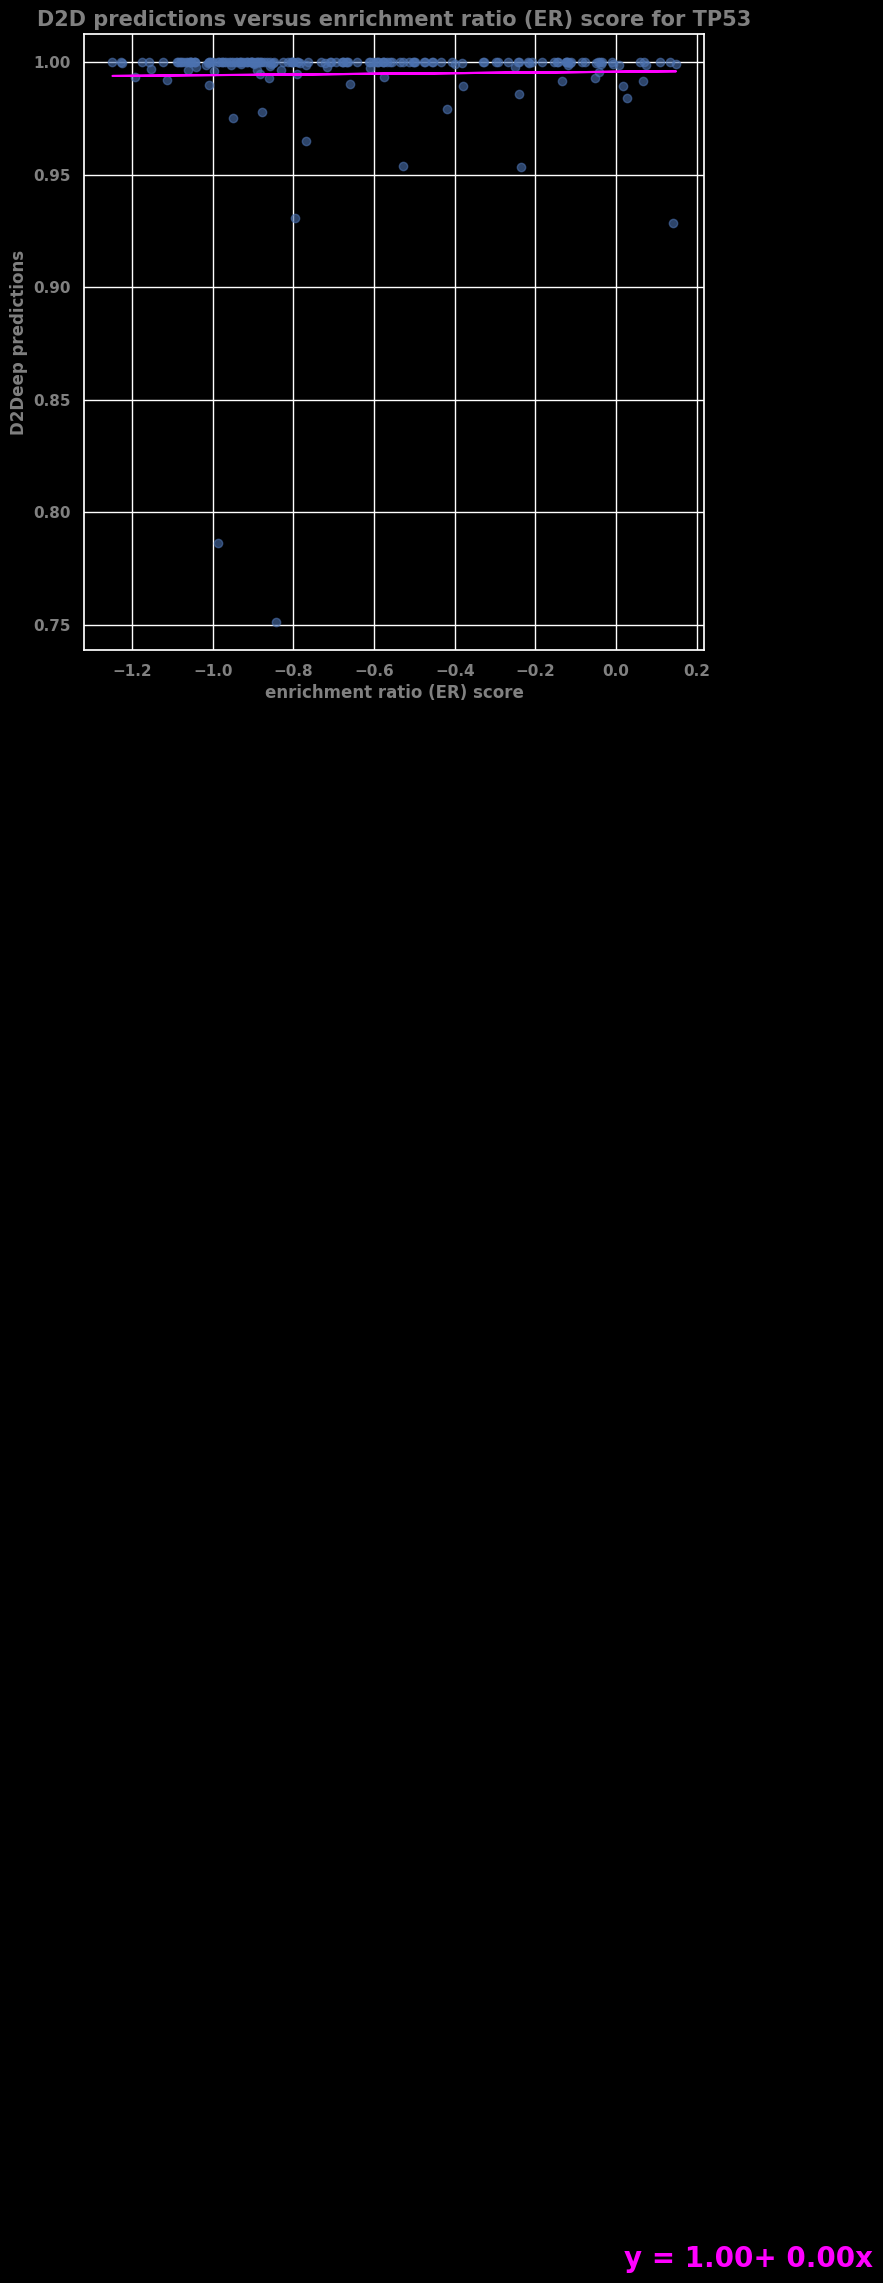

In [ ]:
# high confidence
# plot correlation
selected_values_high = selected_values[selected_values['overall_confidence'] >= 0.8]
correlation, p_value = stats.pearsonr(selected_values_high['contin_label'], selected_values_high['prediction'])

sns.set_theme()
plt.rcParams["figure.figsize"] = (8,8)
plt.figure(facecolor='black')

plt.rcParams['axes.facecolor'] = 'black'

#plt.scatter(selected_values['contin_label'], selected_values['prediction'], alpha=0.6, c = selected_values['contin_label'], cmap="viridis")
plt.scatter(selected_values_high['contin_label'], selected_values_high['prediction'], alpha=0.6)
plt.xlabel('enrichment ratio (ER) score', fontweight='bold', color = 'grey' )
plt.ylabel('D2Deep predictions', fontweight='bold', color = 'grey')

#find line of best fit
a, b = np.polyfit(selected_values_high['contin_label'], selected_values_high['prediction'],1)
plt.plot(selected_values_high['contin_label'], a*selected_values_high['contin_label']+b, color = 'magenta')

plt.xticks(color = 'grey',fontweight='bold')
plt.yticks(color = 'grey',fontweight='bold')
plt.text(0.02, 0.02, 'y = ' + '{:.2f}'.format(b) + '+' + ' {:.2f}'.format(a) + 'x', size=20, color='magenta',  fontweight='bold')
plt.title("D2D predictions versus enrichment ratio (ER) score for TP53",fontsize = 15, fontweight='bold', color = 'grey')
plt.show()

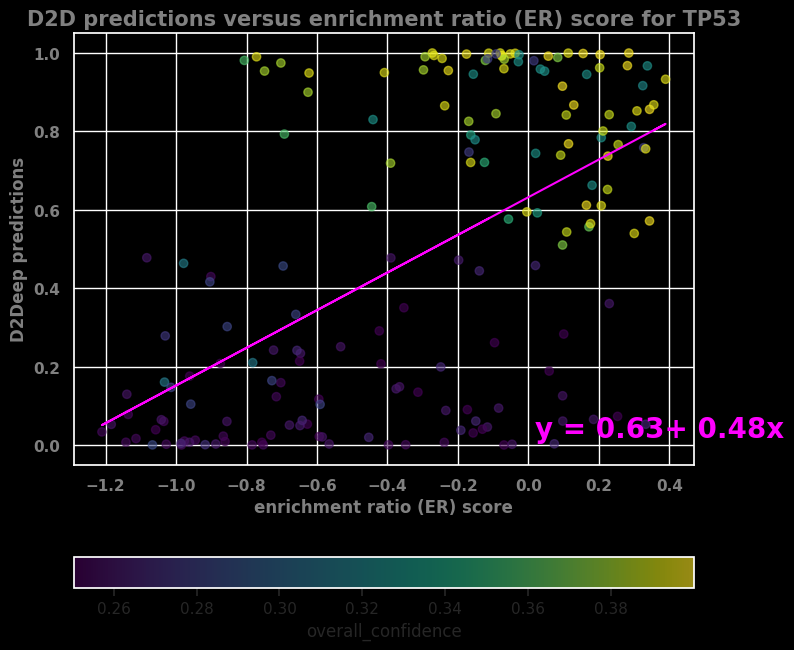

In [ ]:
# low confidence
# plot correlation
selected_values_low = selected_values[selected_values['overall_confidence'] <= 0.4]
correlation, p_value = stats.pearsonr(selected_values_low['contin_label'], selected_values_low['prediction'])

sns.set_theme()
plt.rcParams["figure.figsize"] = (8,8)
plt.figure(facecolor='black')

plt.rcParams['axes.facecolor'] = 'black'

#plt.scatter(selected_values['contin_label'], selected_values['prediction'], alpha=0.6, c = selected_values['contin_label'], cmap="viridis")
plt.scatter(selected_values_low['contin_label'], selected_values_low['prediction'], alpha=0.6, c = selected_values_low['overall_confidence'], cmap="viridis")
plt.xlabel('enrichment ratio (ER) score', fontweight='bold', color = 'grey' )
plt.ylabel('D2Deep predictions', fontweight='bold', color = 'grey')

#find line of best fit
a, b = np.polyfit(selected_values_low['contin_label'], selected_values_low['prediction'],1)
plt.plot(selected_values_low['contin_label'], a*selected_values_low['contin_label']+b, color = 'magenta')

plt.xticks(color = 'grey',fontweight='bold')
plt.yticks(color = 'grey',fontweight='bold')
plt.text(0.02, 0.02, 'y = ' + '{:.2f}'.format(b) + '+' + ' {:.2f}'.format(a) + 'x', size=20, color='magenta',  fontweight='bold')
plt.title("D2D predictions versus enrichment ratio (ER) score for TP53",fontsize = 15, fontweight='bold', color = 'grey')
# plt.colorbar(label="Continuous predictions", orientation="horizontal")
plt.colorbar(label="overall_confidence", orientation="horizontal")
plt.show()

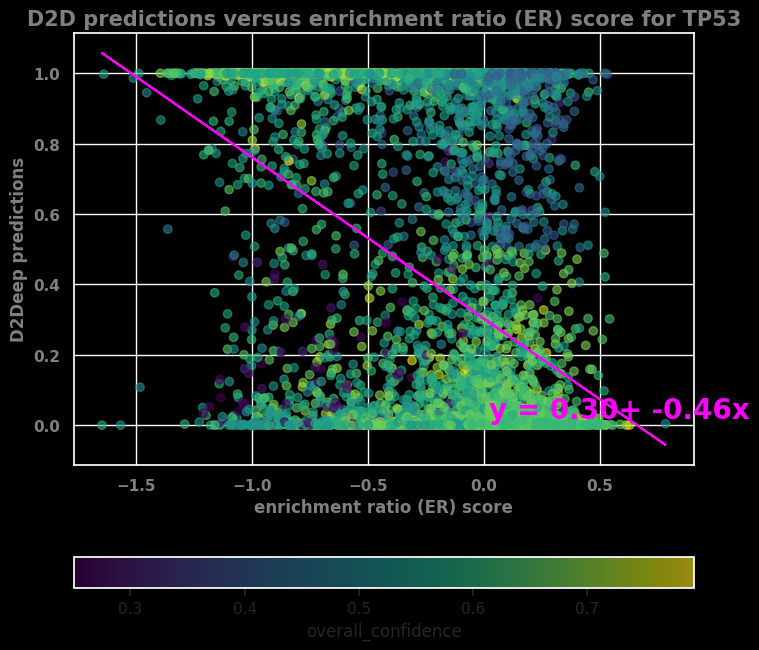

In [ ]:
# plot correlation
correlation, p_value = stats.pearsonr(selected_values['contin_label'], selected_values['prediction'])

sns.set_theme()
plt.rcParams["figure.figsize"] = (8,8)
plt.figure(facecolor='black')

plt.rcParams['axes.facecolor'] = 'black'

#plt.scatter(selected_values['contin_label'], selected_values['prediction'], alpha=0.6, c = selected_values['contin_label'], cmap="viridis")
plt.scatter(selected_values['contin_label'], selected_values['prediction'], alpha=0.6, c = selected_values['overall_confidence'], cmap="viridis")
plt.xlabel('enrichment ratio (ER) score', fontweight='bold', color = 'grey' )
plt.ylabel('D2Deep predictions', fontweight='bold', color = 'grey')

#find line of best fit
a, b = np.polyfit(selected_values['contin_label'], selected_values['prediction'],1)
plt.plot(selected_values['contin_label'], a*selected_values['contin_label']+b, color = 'magenta')

plt.xticks(color = 'grey',fontweight='bold')
plt.yticks(color = 'grey',fontweight='bold')
plt.text(0.02, 0.02, 'y = ' + '{:.2f}'.format(b) + '+' + ' {:.2f}'.format(a) + 'x', size=20, color='magenta',  fontweight='bold')
plt.title("D2D predictions versus enrichment ratio (ER) score for TP53",fontsize = 15, fontweight='bold', color = 'grey')
# plt.colorbar(label="Continuous predictions", orientation="horizontal")
plt.colorbar(label="overall_confidence", orientation="horizontal")
plt.show()

In [ ]:
print(correlation, p_value )

-0.4048164239752649 9.365567695469062e-292


PTEN

In [ ]:
tp53_confidenceAB =pd.read_csv(path+'PTEN_confidenceAB.csv')

In [ ]:
dms_mutations_pten = dms_mutations[dms_mutations['uniprot id'] == 'P60484-1']
dms_mutations_pten['position'] = dms_mutations_pten['position'].astype(str)

tp53_predictions = pd.read_csv('/content/drive/MyDrive/PTEN_d2d_results.csv')
tp53_predictions['Log_prob'] = tp53_confidenceAB['Log_prob']
tp53_predictions= normalise_confidence(tp53_predictions)
# for converting d2d_results to d2d_performance_vs_clinvar format
temp = tp53_predictions.mutation.str.split(pat='_',expand=True)[0]
tp53_predictions['uniprot id'] = temp

temp = tp53_predictions.mutation.str.split(pat='_',expand=True)[1]
tp53_predictions= tp53_predictions.drop('mutation', axis=1)
tp53_predictions['mutation']= temp

tp53_predictions['AA_orig'] = tp53_predictions['mutation'].str[:1]
tp53_predictions['AA_targ'] = tp53_predictions['mutation'].str[-1:]
tp53_predictions['position'] = tp53_predictions['mutation'].str[1:-1]


# Merge df1 and df2 based on columns "AA_orig", "AA_targ", "position"
merged_df = pd.merge(tp53_predictions, dms_mutations_pten,  on=["AA_orig", "AA_targ", "position"])
# Select the values from df1's "contin_label" and df2's "prediction"
selected_values = merged_df[["contin_label", "prediction",  "overall_confidence"]]

<ipython-input-42-81343ac5a001>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dms_mutations_pten['position'] = dms_mutations_pten['position'].astype(str)


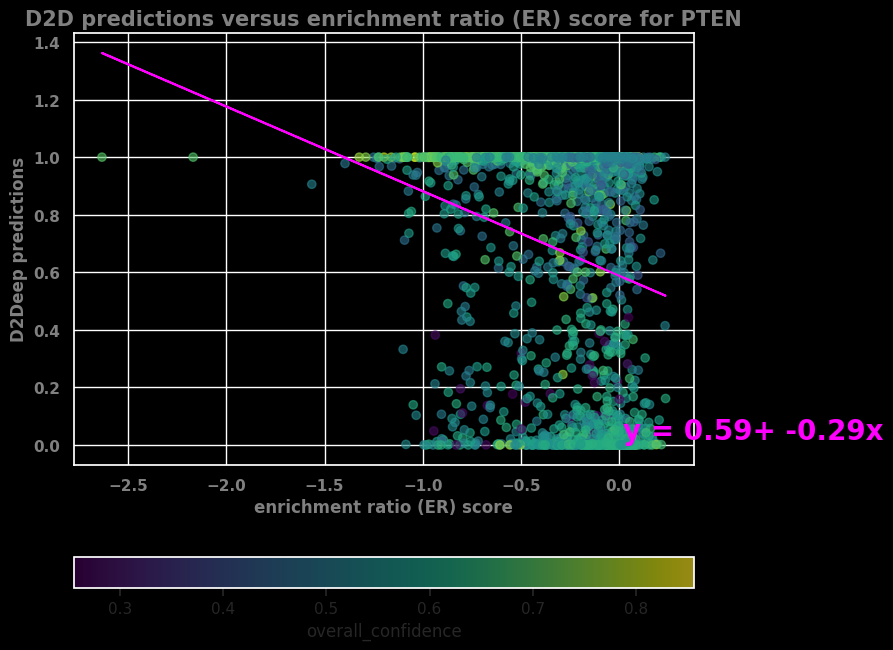

In [ ]:
# plot correlation
correlation, p_value = stats.pearsonr(selected_values['contin_label'], selected_values['prediction'])

sns.set_theme()
plt.rcParams["figure.figsize"] = (8,8)
plt.figure(facecolor='black')

plt.rcParams['axes.facecolor'] = 'black'

#plt.scatter(selected_values['contin_label'], selected_values['prediction'], alpha=0.6, c = selected_values['contin_label'], cmap="viridis")
plt.scatter(selected_values['contin_label'], selected_values['prediction'], alpha=0.6, c = selected_values['overall_confidence'], cmap="viridis")
plt.xlabel('enrichment ratio (ER) score', fontweight='bold', color = 'grey' )
plt.ylabel('D2Deep predictions', fontweight='bold', color = 'grey')

#find line of best fit
a, b = np.polyfit(selected_values['contin_label'], selected_values['prediction'],1)
plt.plot(selected_values['contin_label'], a*selected_values['contin_label']+b, color = 'magenta')

plt.xticks(color = 'grey',fontweight='bold')
plt.yticks(color = 'grey',fontweight='bold')
plt.text(0.02, 0.02, 'y = ' + '{:.2f}'.format(b) + '+' + ' {:.2f}'.format(a) + 'x', size=20, color='magenta',  fontweight='bold')
plt.title("D2D predictions versus enrichment ratio (ER) score for PTEN",fontsize = 15, fontweight='bold', color = 'grey')
# plt.colorbar(label="Continuous predictions", orientation="horizontal")
plt.colorbar(label="overall_confidence", orientation="horizontal")
plt.show()

In [ ]:
print(correlation, p_value )

-0.21011756999116088 1.5301678927386085e-24
